In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())
torch.set_default_device('cuda:0')

True


In [84]:
def l1_proj_vec(u_batch, max_on=15):
    d,n = u_batch.shape
    batch_idx = torch.linspace(0,n-1,n).int()
    u_batch.clamp_(min=0, max=1)
    u_proj = torch.zeros_like(u_batch)
    sort_idx = torch.argsort(u_batch, dim=0, descending=True)
    running_sum = torch.zeros(n)
    max_j = torch.zeros(n)
    max_sum = torch.zeros(n)
    for j in range(d):
        uj = u_batch[sort_idx[j,:], torch.arange(n)]
        running_sum += uj
        good = uj - (running_sum - max_on) / (j+1) > 0
        max_j[good] = j+1
        max_sum[good] = running_sum[good].clone()    
    theta = torch.divide(max_sum - max_on,max_j)
    u_batch_l1 = torch.linalg.norm(u_batch, axis=0)
    theta[u_batch_l1 < max_on] = 0
    u_proj = u_batch - torch.outer(torch.ones(d),theta)
    u_proj.clamp_(min=0)
    u_batch.data = u_proj
    return u_batch

61.363101959228516
18.834592819213867
10.048583984375
6.573957443237305
4.825697422027588
3.7943406105041504
3.1252858638763428
2.660616636276245
2.3221511840820312
2.0660295486450195
1.866753339767456
1.7077040672302246
1.5823445320129395
1.4841502904891968
1.4077626466751099
1.3449511528015137
1.2937936782836914
1.2511858940124512
1.214832067489624
1.1838324069976807
1.1571519374847412
1.133707046508789
1.112993597984314
1.094722032546997
1.078418493270874
1.0639020204544067
1.0508763790130615
1.0393762588500977
1.0290859937667847
1.0201945304870605
1.012128233909607
1.0048860311508179
0.99836266040802
0.9926605820655823
0.9876410961151123
0.9831291437149048
0.9790558815002441
0.9752471446990967
0.9716618061065674
0.9683456420898438
0.9652110934257507
0.962267279624939
0.9595656394958496
0.9571322798728943
0.9548527002334595
0.9526711106300354
0.9505948424339294
0.9486267566680908
0.9467321038246155
0.9449103474617004
0.9431643486022949
0.9415029287338257
0.9398810863494873
0.9383288

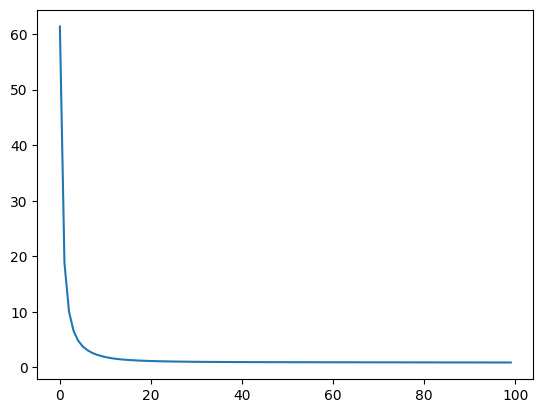

In [157]:
def Dsigmoid(x):
    return torch.divide(1, torch.pow(1 + torch.exp(-x), 2))

def input_design(W, n_iters, num_batches, l1_constraint, k=None):
    W = torch.tensor(W).float()
    d = W.shape[0]
    
    U = torch.tensor(0.1*torch.randn(d,num_batches), requires_grad=True, dtype=torch.float32)
    with torch.no_grad():
        U = l1_proj_vec(U, max_on=l1_constraint)
    optimizer = optim.Adam([U], lr=0.1)
    
    if k is not None:
        _,_,V_true = torch.linalg.svd(W)
        V_true = V_true[0:k,:]
        cov_reg = 0.0001 * torch.eye(k)
    else:
        V_true = torch.eye(d)
        cov_reg = 0.0001 * torch.eye(d)
    
    loss_vals = []
    for n in range(n_iters):
        optimizer.zero_grad()
        Dsig_val = Dsigmoid(W @ U)
        loss = 0
        for i in range(d):
            Dsig_vali = torch.sqrt(Dsig_val[i,:])
            #Ui = torch.einsum('i,ji->ji', Dsig_vali, U)
            Ui = U
            covi = V_true @ Ui @ Ui.T @ V_true.T + cov_reg
            loss += torch.trace(torch.linalg.inv(covi))
        
        loss_vals.append(loss.item())
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            U = l1_proj_vec(U, max_on=l1_constraint)
        print(loss_vals[-1])
    plt.plot(loss_vals)
    plt.show()
    return U.detach()

# d = 100
# N = 200
# W = torch.randn(d,d)
# X_design_k1 = input_design(W_true,100,50,10,1)
# X_design_half = input_design(W_true,100,51,10)
# X_design_full = input_design(W_true,100,101,10)
X_design_nosig = input_design(W_true,100,101,10)

In [148]:
def l1_proj(u_batch, max_on=15):
    if torch.linalg.norm(u_batch, 1) <= max_on:
        return u_batch
    d = u_batch.shape[0]
    u_proj = torch.zeros_like(u_batch)
    sort_idx = torch.argsort(u_batch, descending=True)
    running_sum = 0
    max_j = 0
    max_sum = 0
    for j in range(d):
        uj = u_batch[sort_idx[j]]
        running_sum += uj
        if uj - (running_sum - max_on) / (j+1) > 0:
            max_j = j + 1
            max_sum = running_sum.clone()
    theta = (max_sum - max_on) / max_j
    u_proj = u_batch - theta
    u_proj.clamp_(min=0)
    return u_proj


def fit_glm(X,Y,n_iters):
    X = torch.tensor(X, device='cuda:0').float()
    Y = torch.tensor(Y, device='cuda:0').float()
    d = X.shape[0]
    
    W = torch.tensor(0.1*torch.randn(d,d), requires_grad=True, dtype=torch.float32)
    optimizer = optim.Adam([W], lr=0.05)
    
    loss_vals = []
    for n in range(n_iters):
        optimizer.zero_grad()
        loss = torch.linalg.norm(Y - torch.sigmoid(W @ X), ord='fro')**2
        #loss = torch.linalg.norm(Y - W @ X, ord='fro')**2
        #loss += 0.0001 * torch.linalg.norm(W, ord='fro')**2
        loss.backward()
        optimizer.step()
        
        loss_vals.append(loss.item())
    plt.plot(loss_vals)
    plt.show()
    return W.detach()


def fit_glm_nuc(X,Y,reg,n_iters):
    X = torch.tensor(X, device='cuda:0').float()
    Y = torch.tensor(Y, device='cuda:0').float()
    d = X.shape[0]
    
    W = torch.tensor(0.1*torch.randn(d,d), requires_grad=True, dtype=torch.float32)
    optimizer = optim.Adam([W], lr=0.05)
    
    loss_vals = []
    for n in range(n_iters):
        optimizer.zero_grad()
        loss = torch.linalg.norm(Y - torch.sigmoid(W @ X), ord='fro')**2
        #loss = torch.linalg.norm(Y - W @ X, ord='fro')**2
        #loss += 0.0001 * torch.linalg.norm(W, ord='fro')**2
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())
        with torch.no_grad():
            U,S,V = torch.linalg.svd(W)
            S = l1_proj(S, max_on=reg)
            W.data = U @ torch.diag(S) @ V
    plt.plot(loss_vals)
    plt.show()
    return W.detach()

tensor([1.0000e+00, 2.0877e-08, 1.5145e-08, 5.7073e-10, 3.6129e-10],
       device='cuda:0')


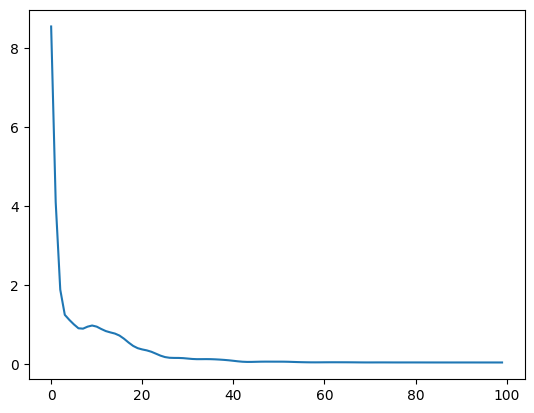

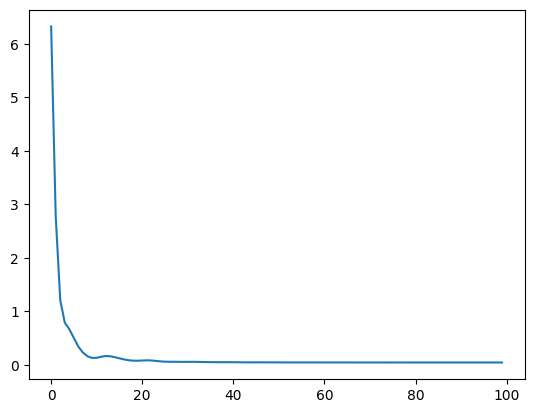

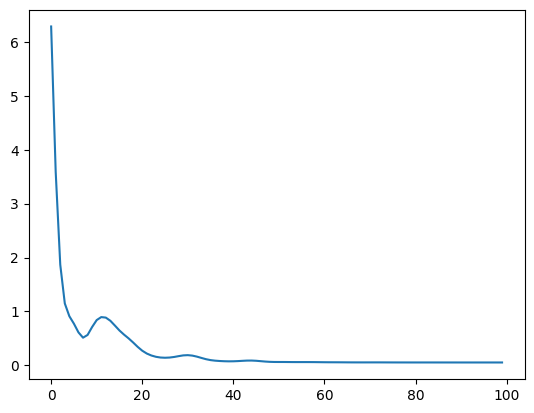

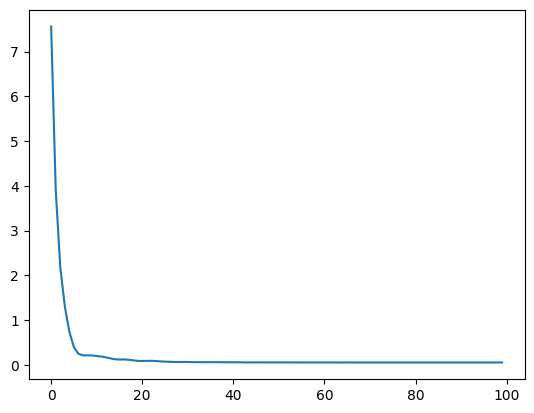

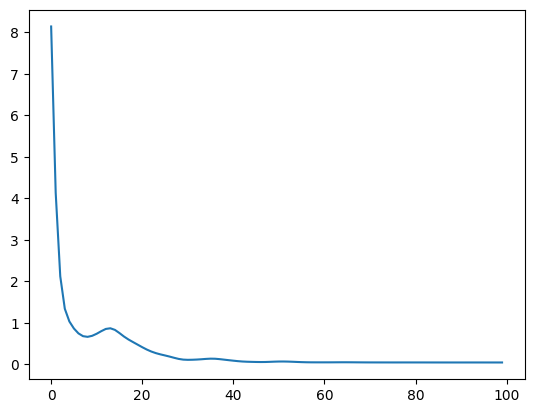

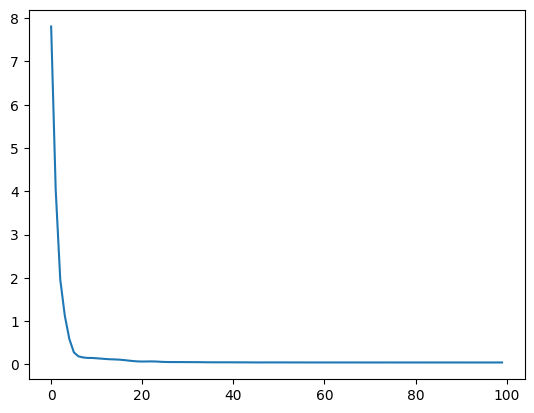

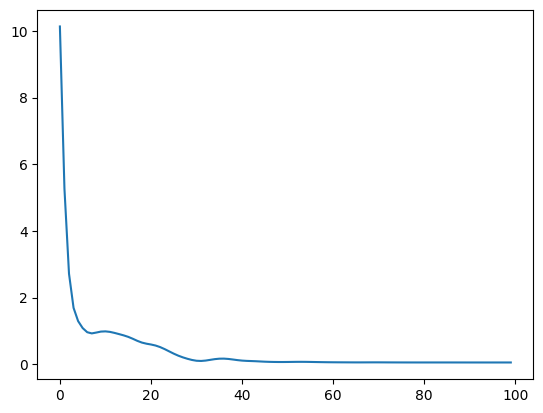

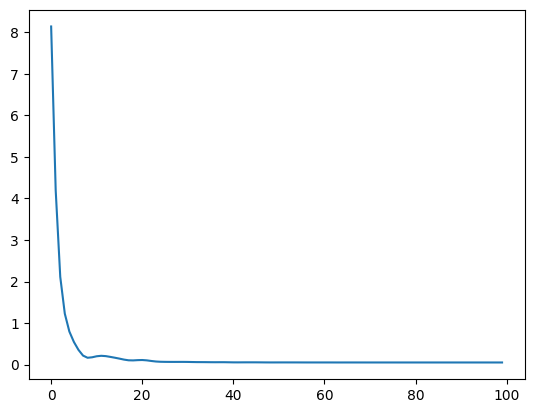

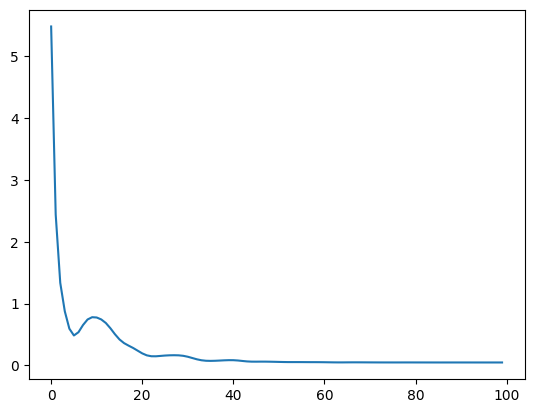

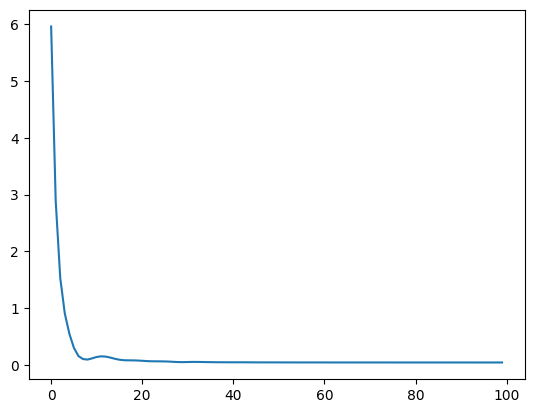

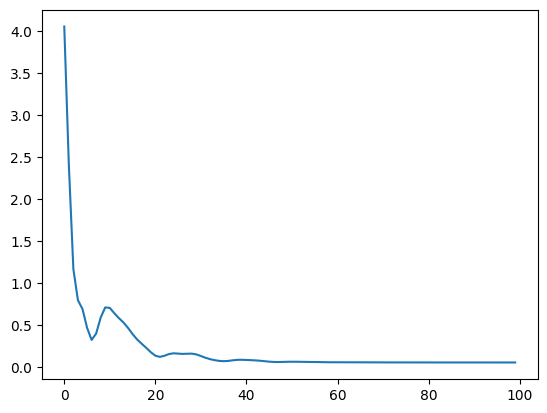

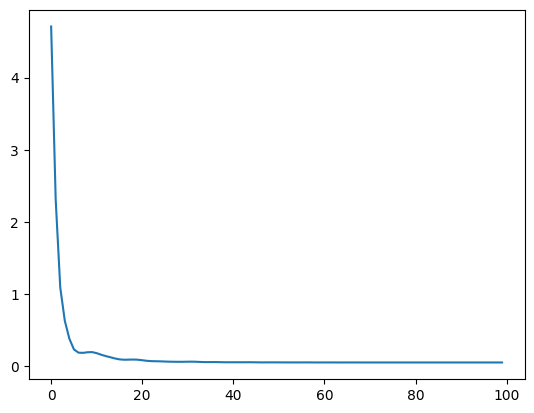

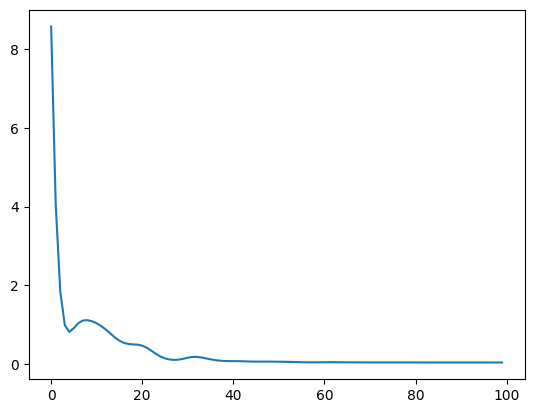

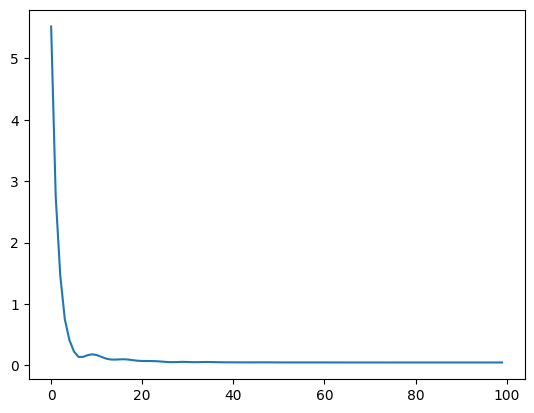

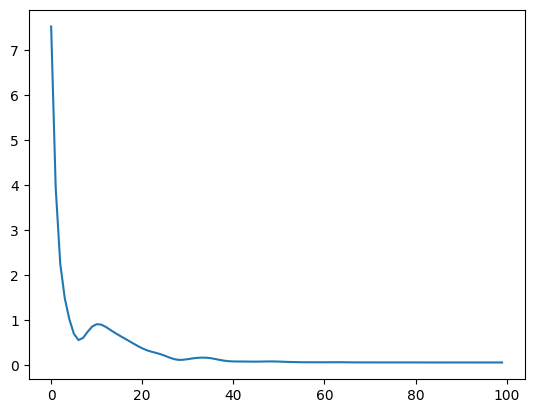

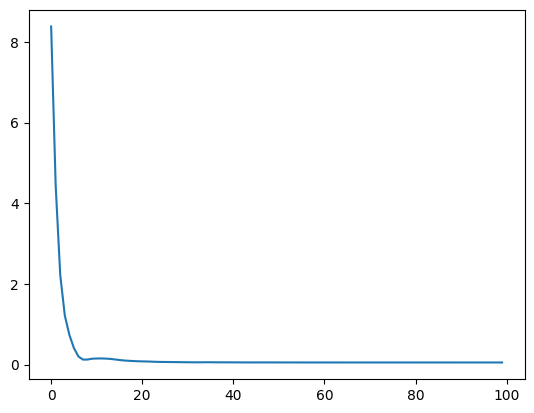

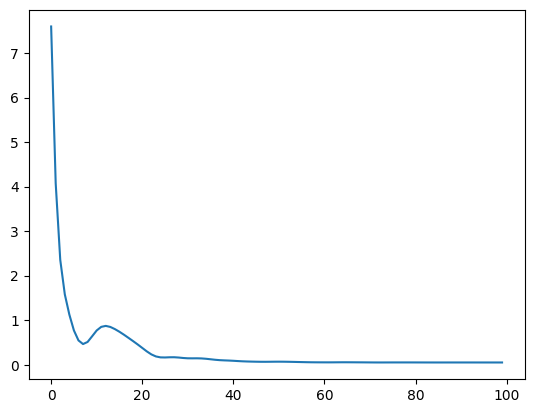

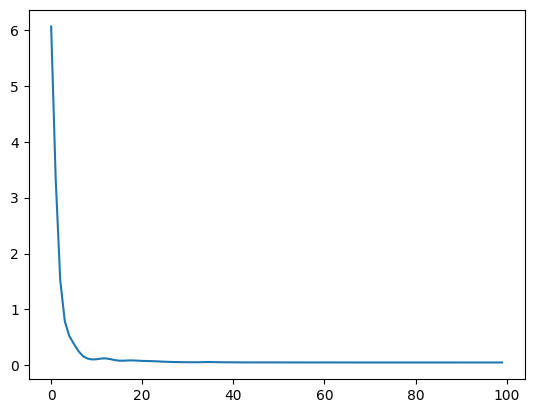

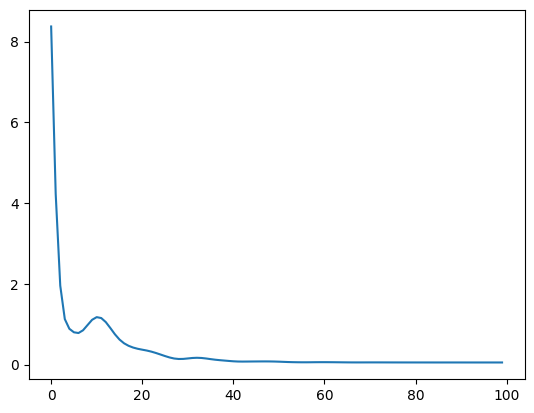

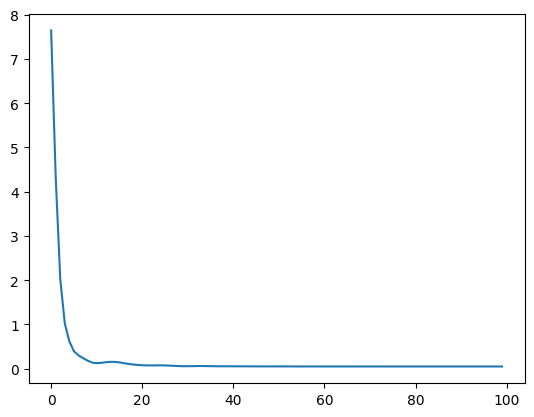

tensor(0.2305, device='cuda:0') tensor(0.2261, device='cuda:0')


In [115]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

u = torch.randn(5)
v = torch.randn(5)
u = u / torch.linalg.norm(u)
v = v / torch.linalg.norm(v)
#W_true = torch.randn(5,5)
W_true = torch.outer(u,v)
_,S,_ = torch.linalg.svd(W_true)
print(S)

T = 101
X = torch.randn(5,T)
#X = l1_proj_vec(X, 1)
Y = torch.zeros(5,T)
e_passive = []

e1 = 0
e2 = 0
for i in range(10):
    for t in range(T):
        x = torch.randn(5)
        y = torch.sigmoid(W_true @ x) + 0.01*torch.randn(5)
        X[:,t] = x
        Y[:,t] = y
    #     if np.mod(t,20) == 0 and t > 0:
    #         W_hat = fit_glm(X[:,:t],Y[:,:t],100)
    #         e_passive.append(torch.linalg.norm(W_hat - W_true).detach().cpu().numpy())

    #plt.plot(e_passive)
    W1 = fit_glm(X,Y,100)
    W2 = fit_glm_nuc(X,Y,1.1,100)
    e1 += torch.linalg.norm(W_true - W1)
    e2 += torch.linalg.norm(W_true - W2)
# print(torch.linalg.norm(W_true - W1))
# print(torch.linalg.norm(W_true - W2))
print(e1,e2)

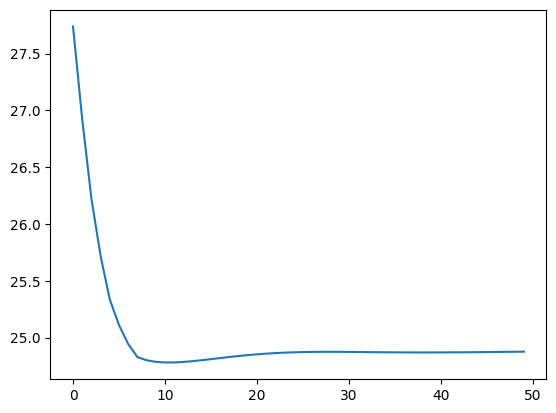

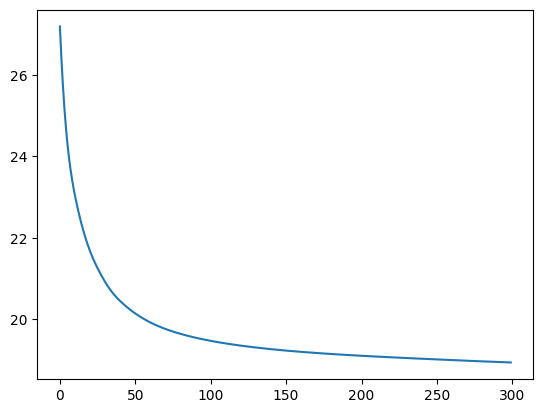

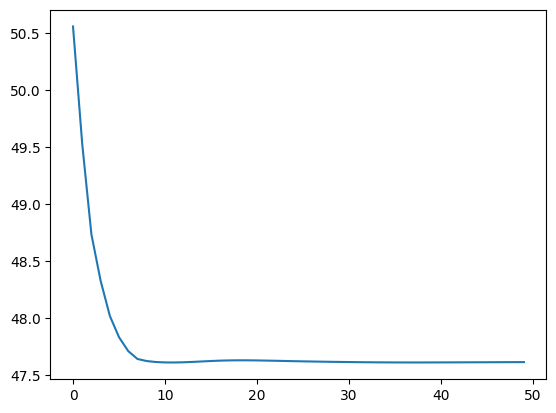

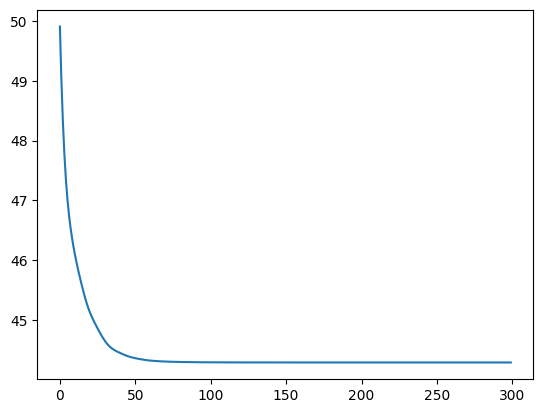

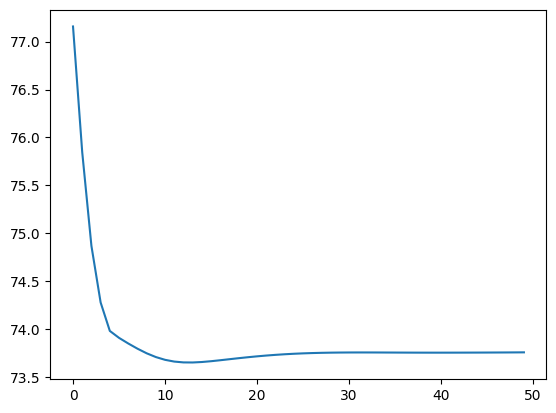

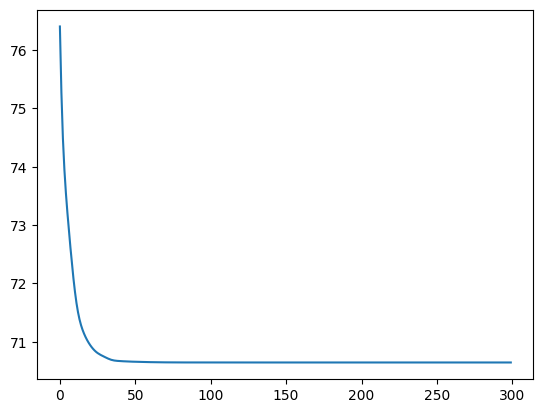

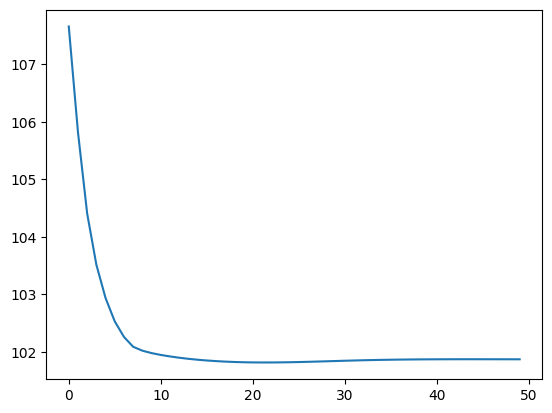

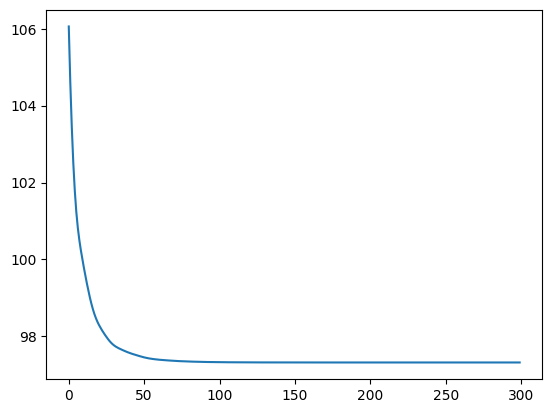

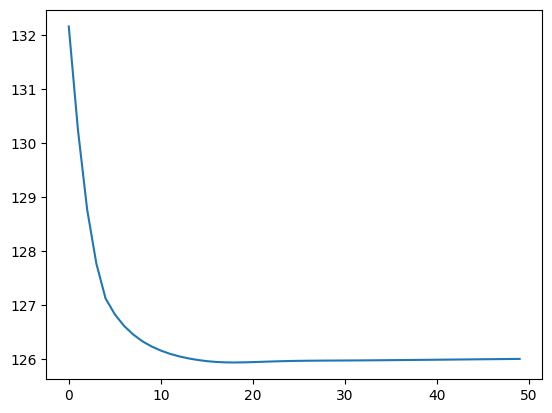

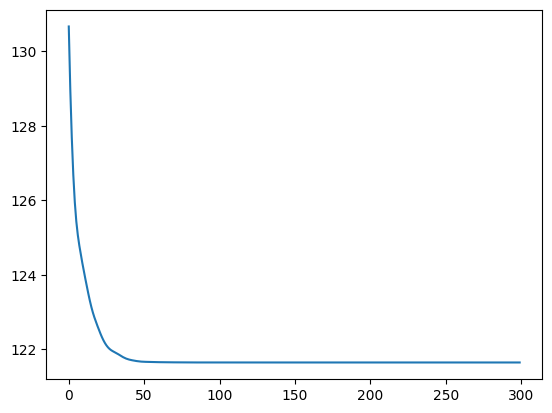

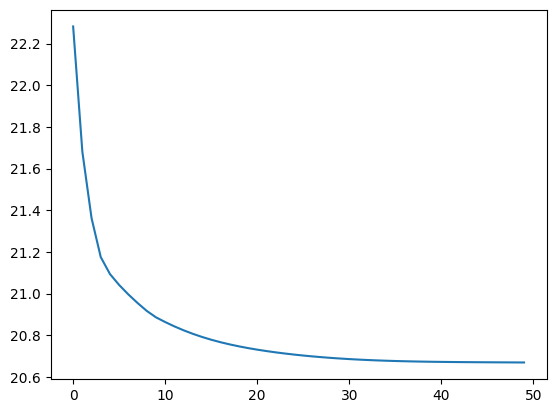

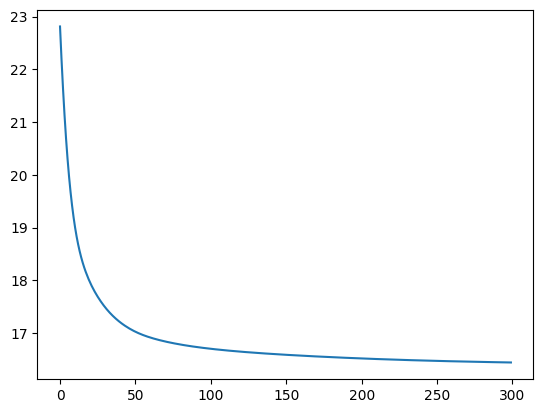

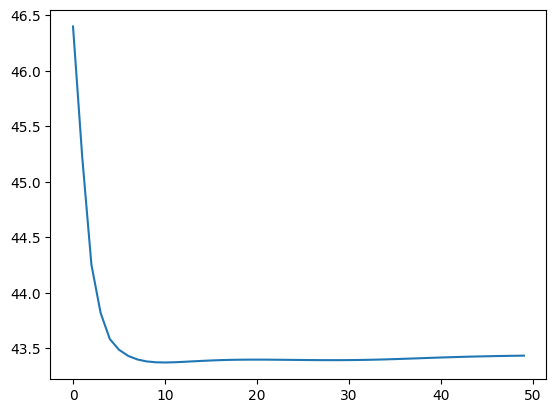

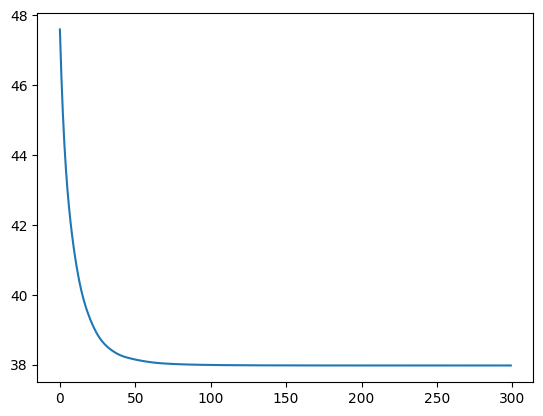

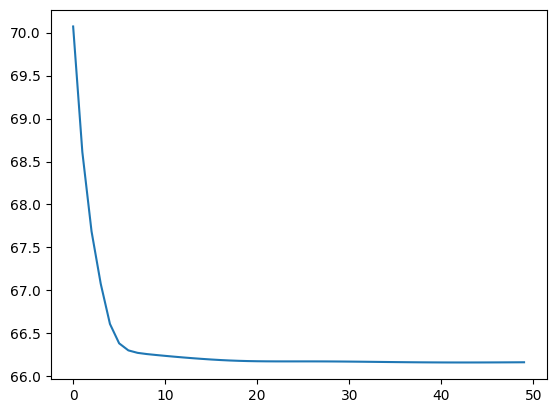

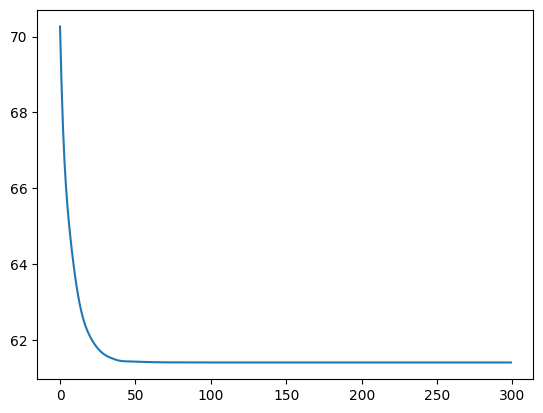

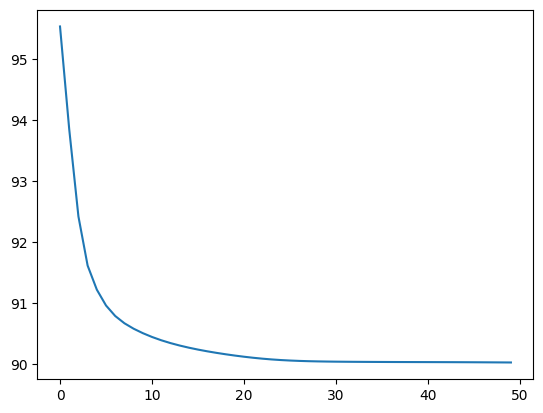

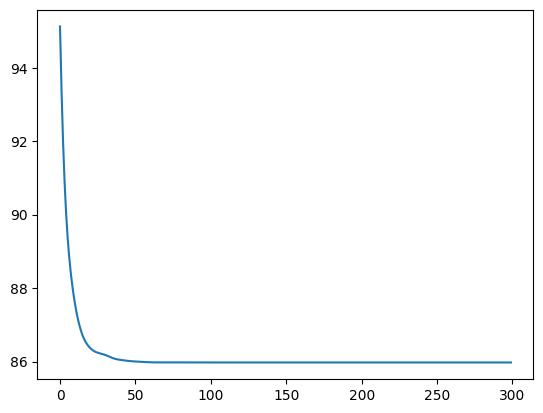

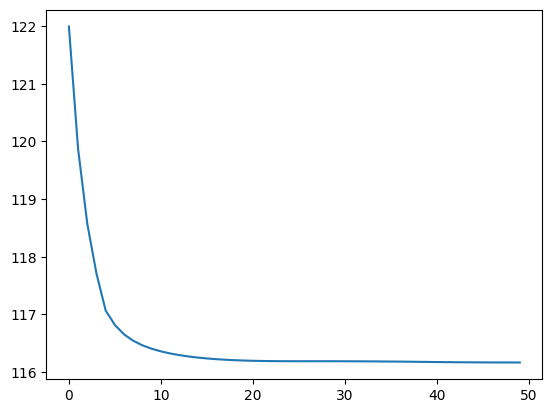

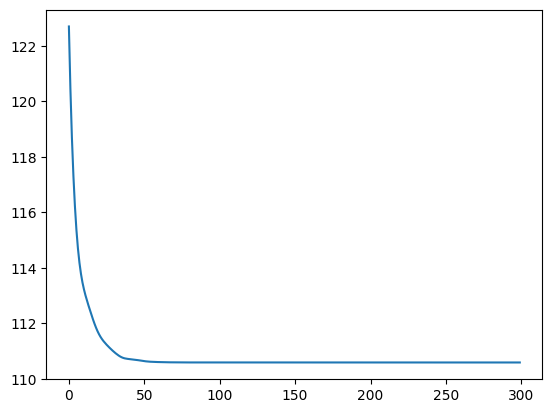

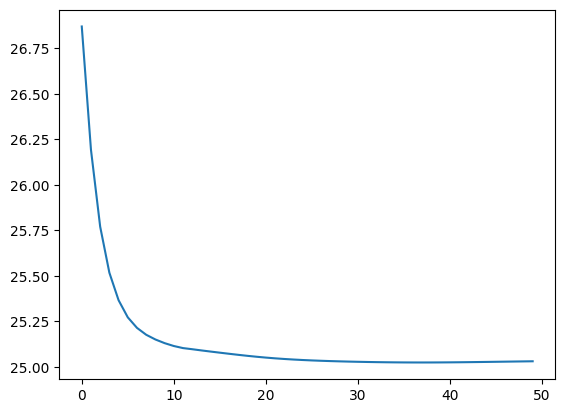

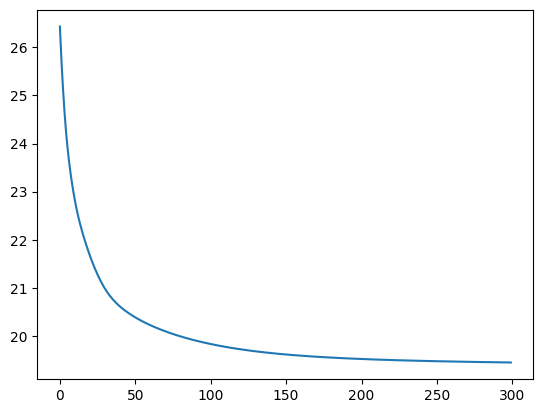

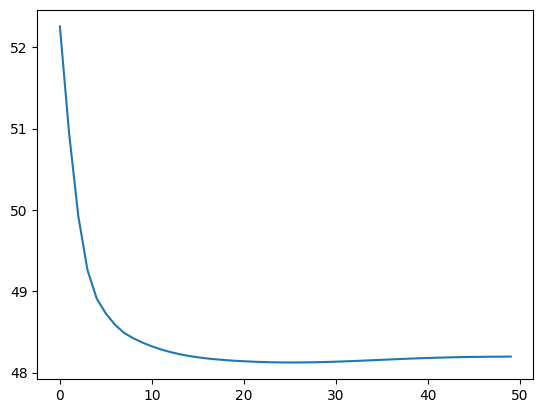

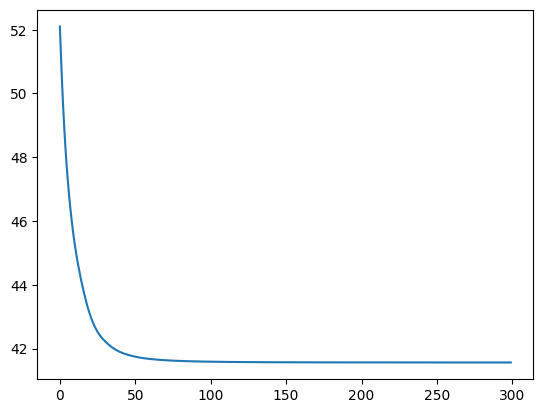

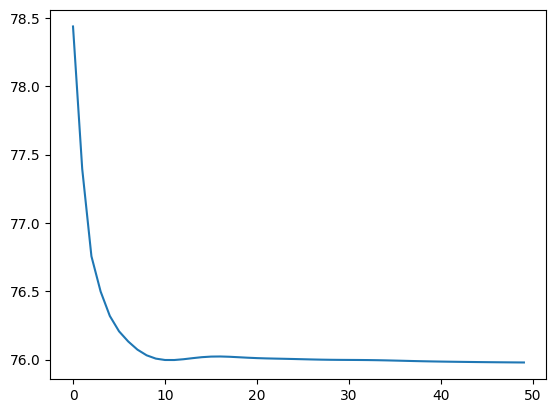

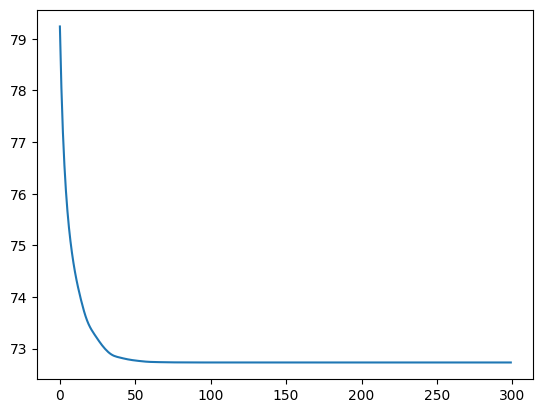

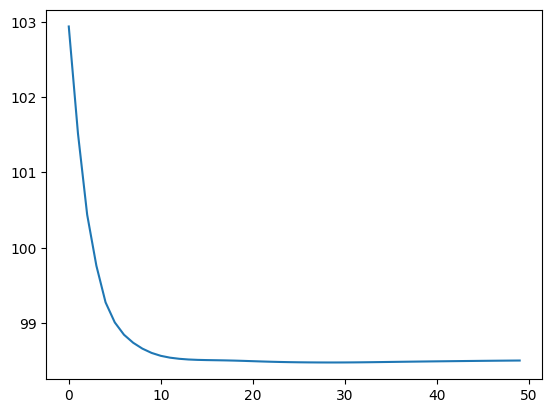

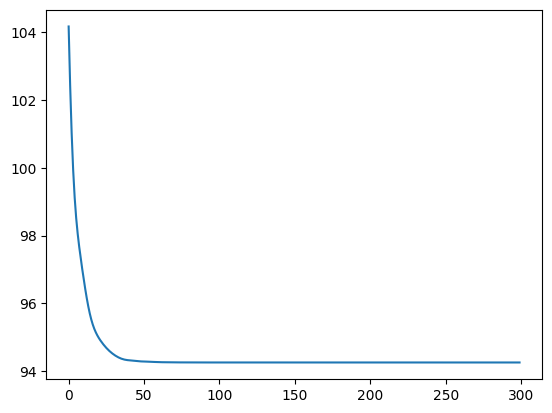

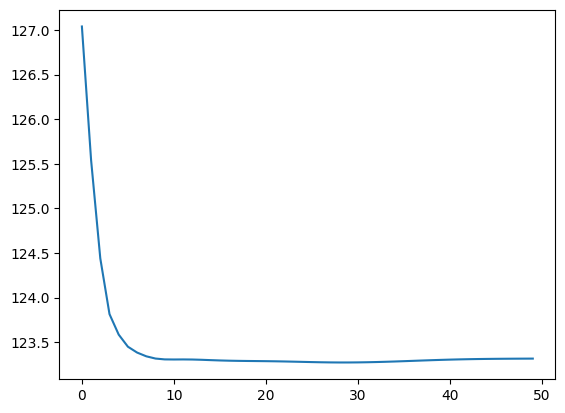

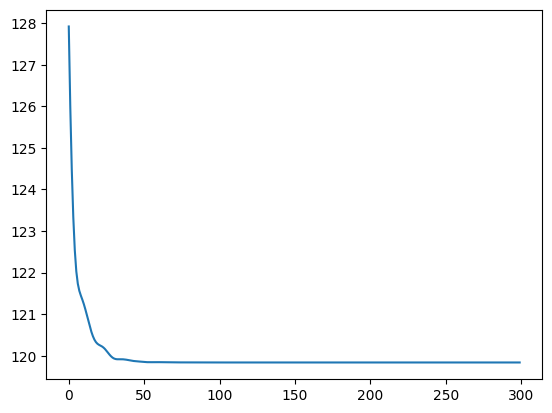

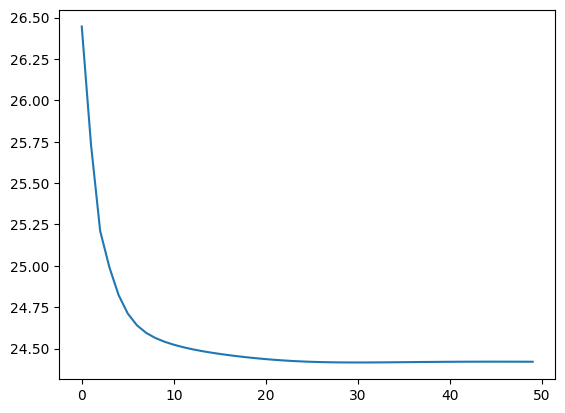

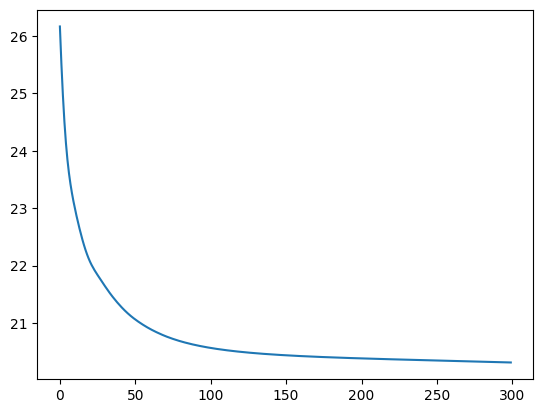

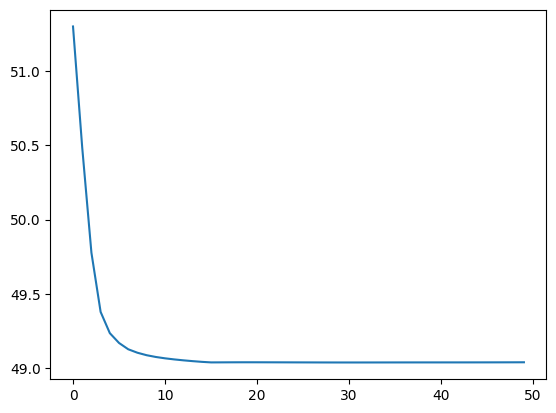

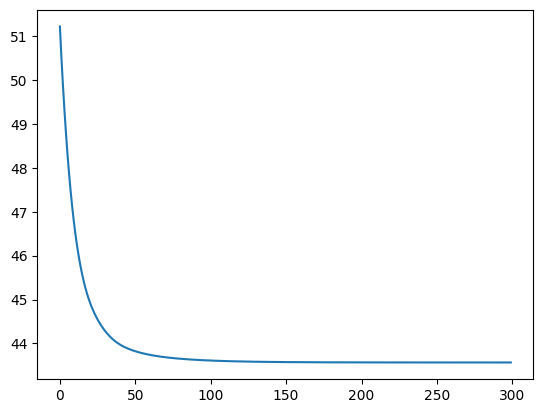

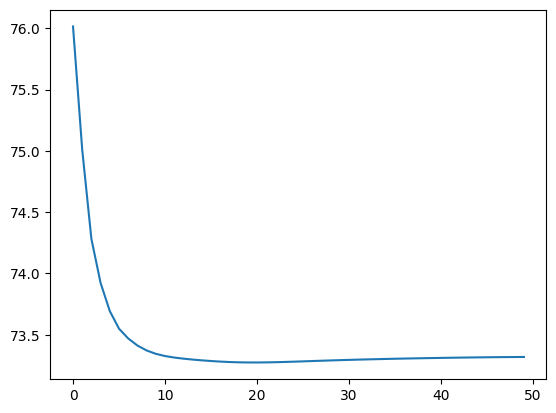

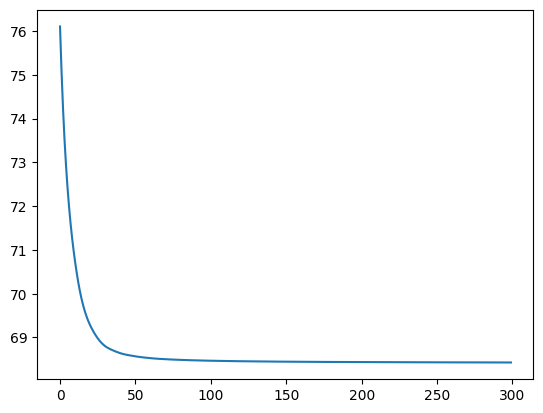

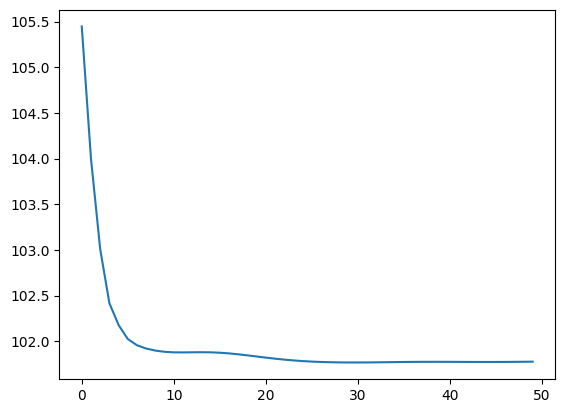

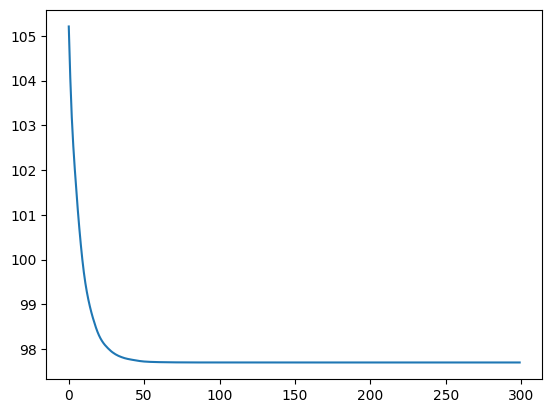

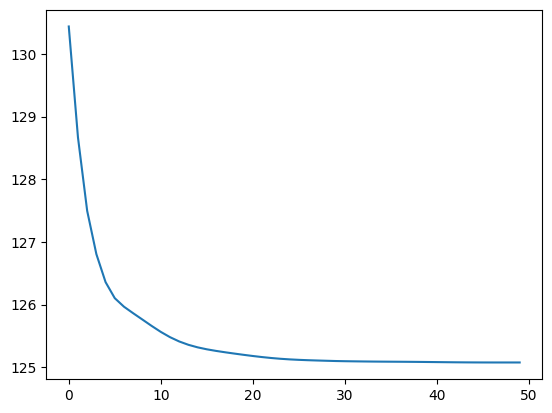

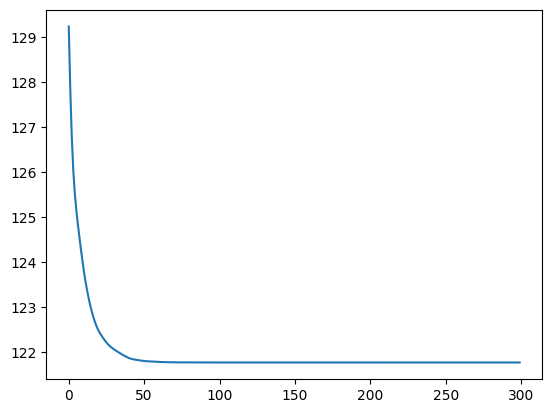

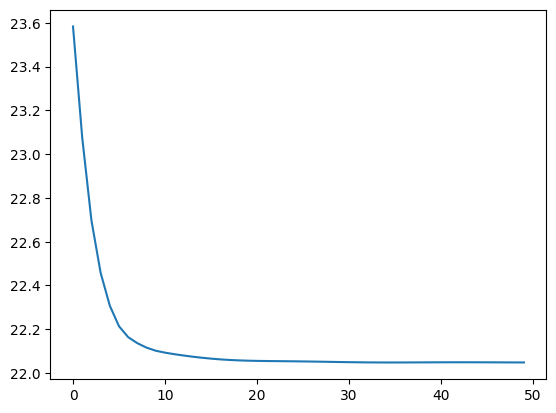

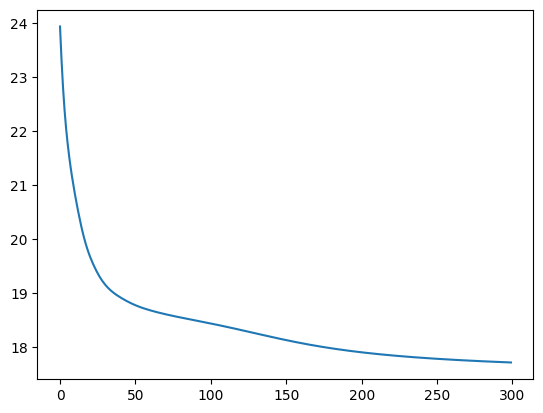

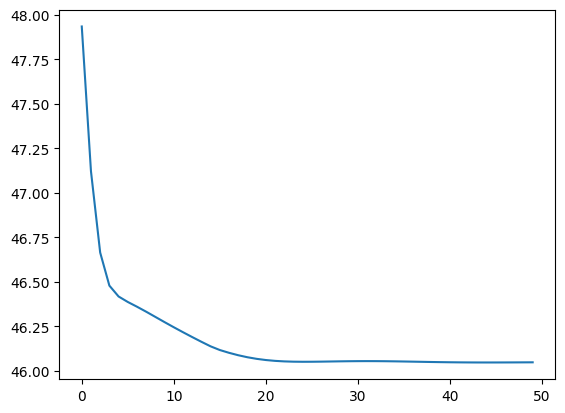

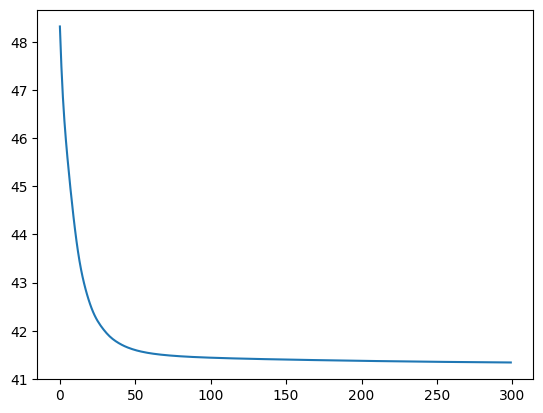

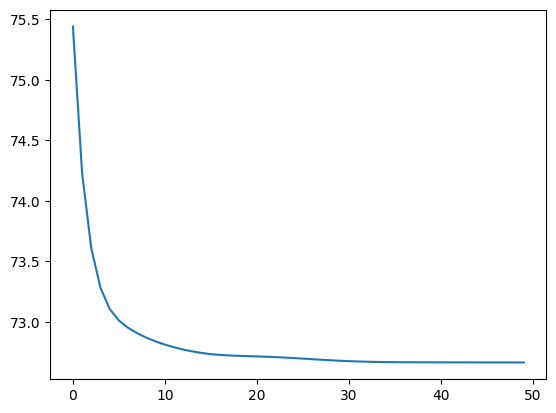

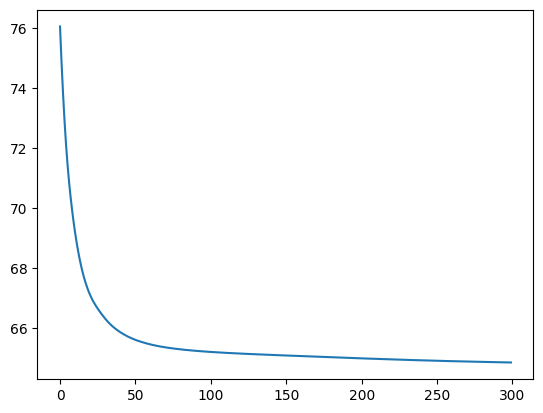

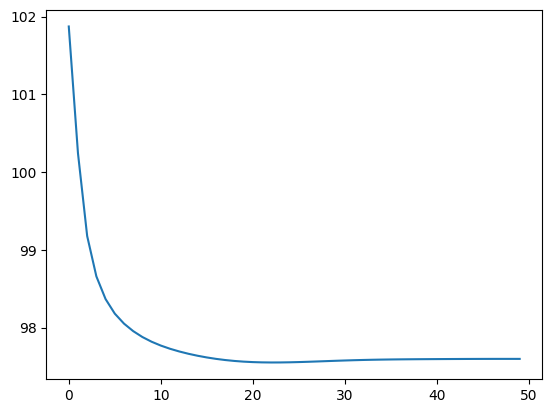

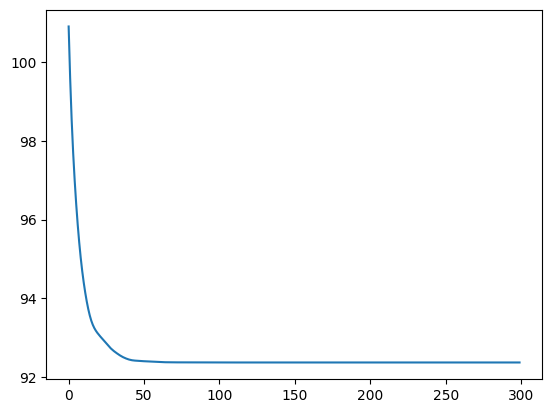

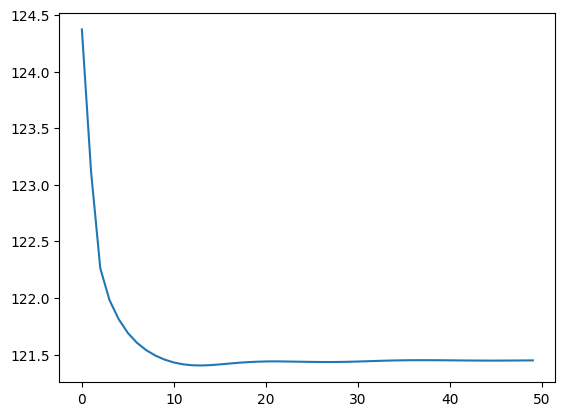

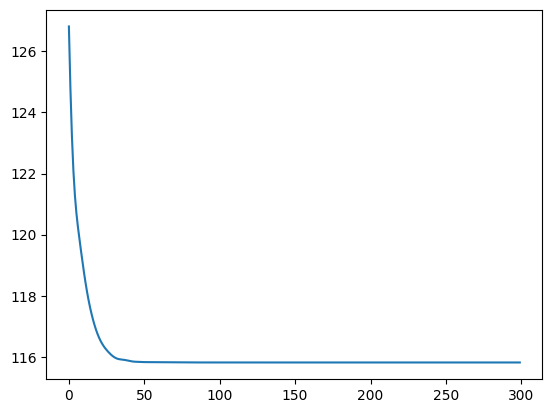

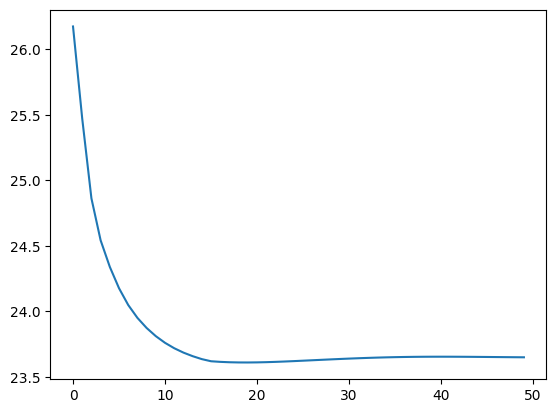

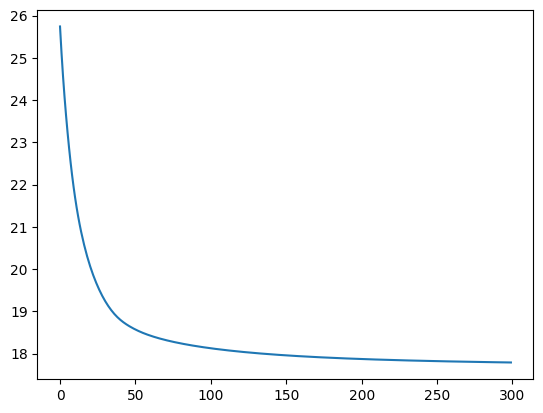

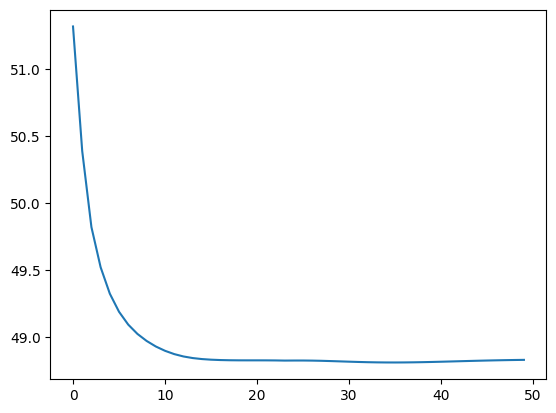

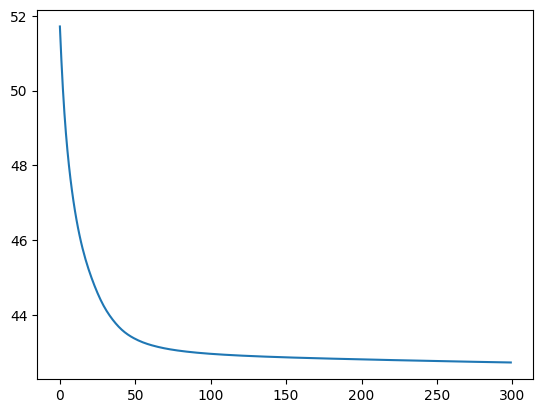

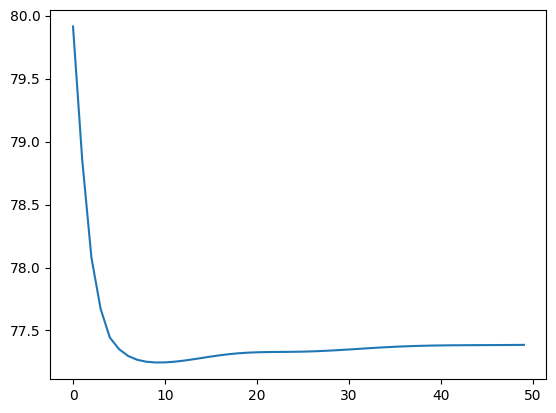

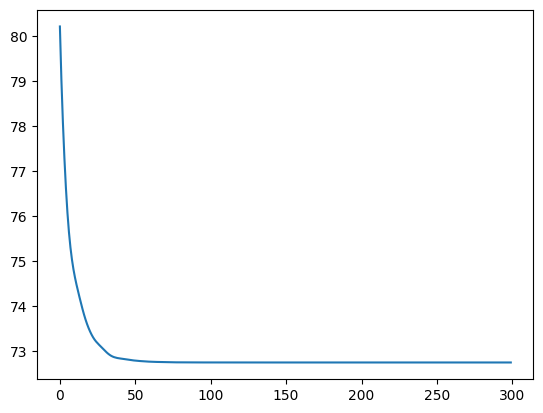

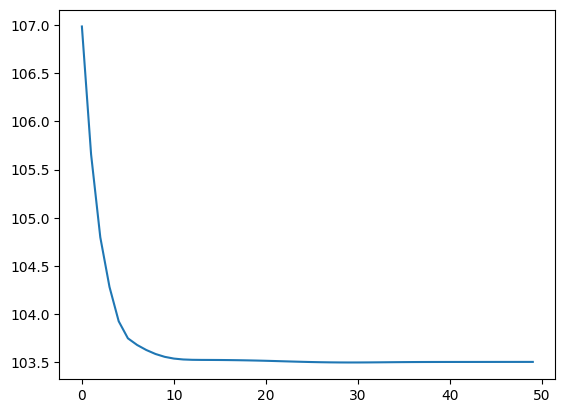

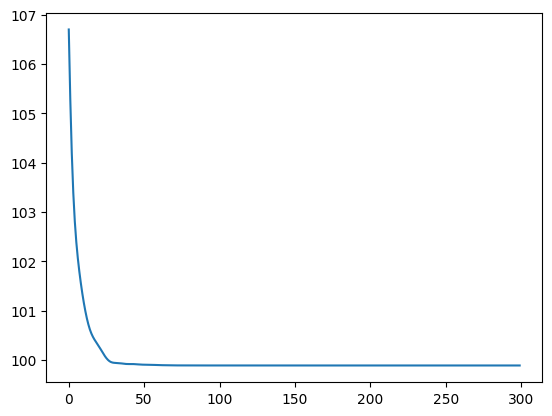

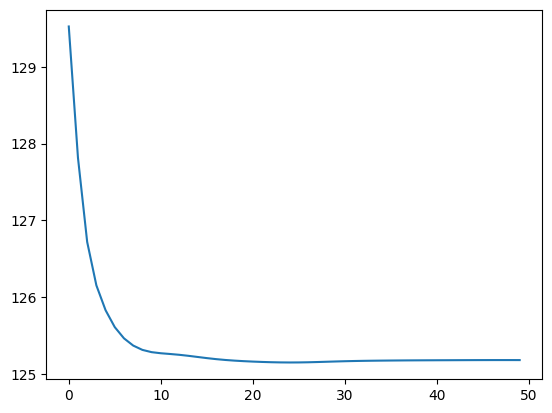

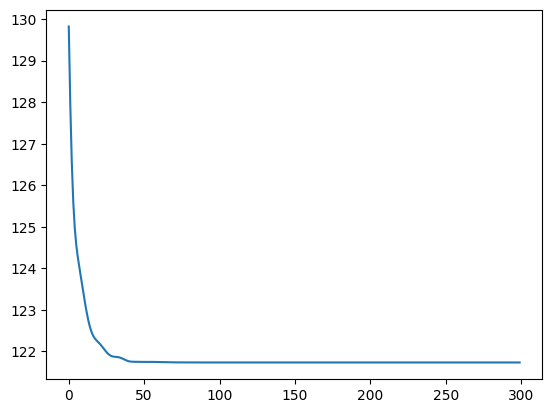

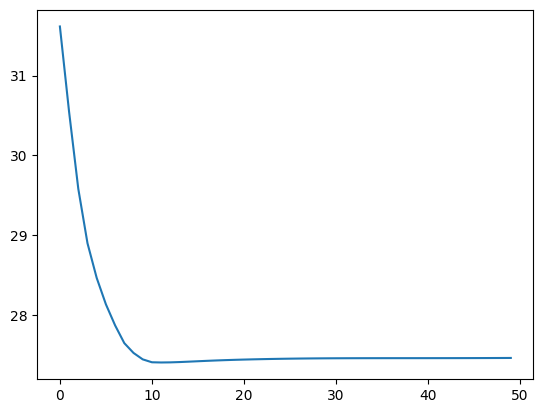

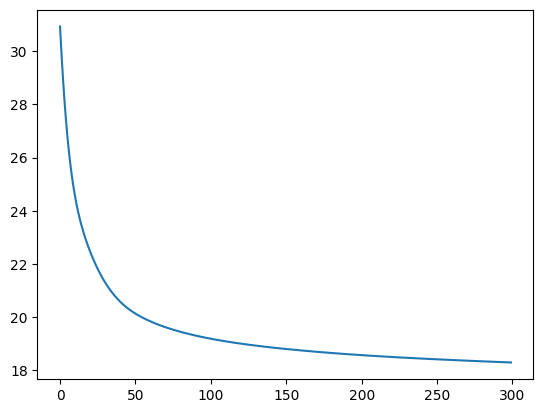

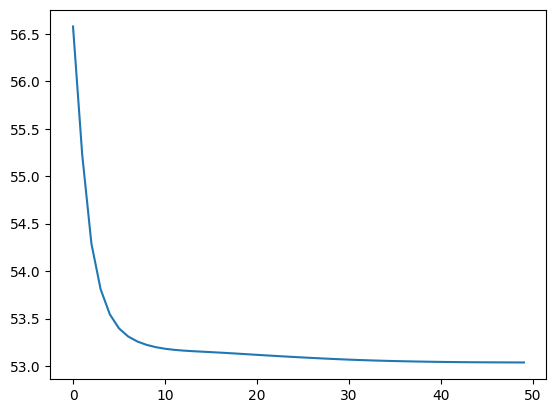

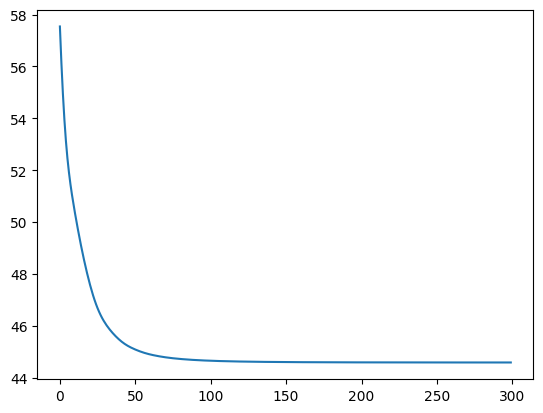

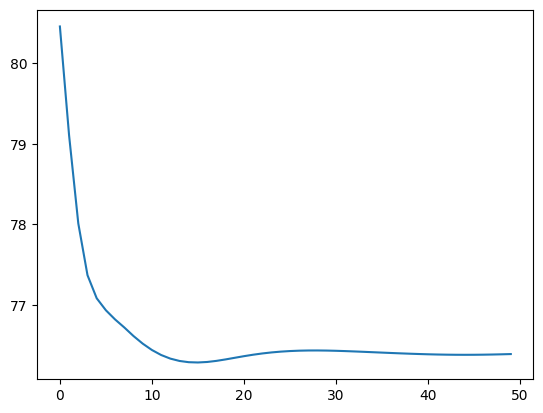

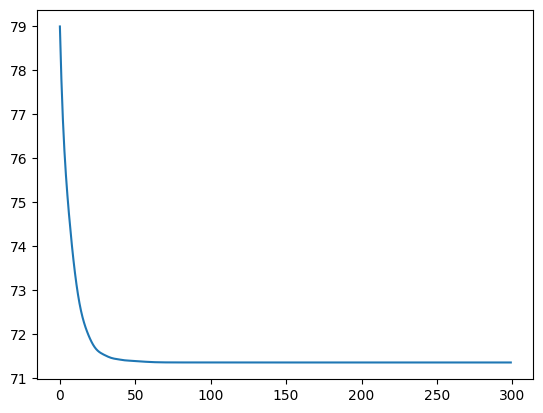

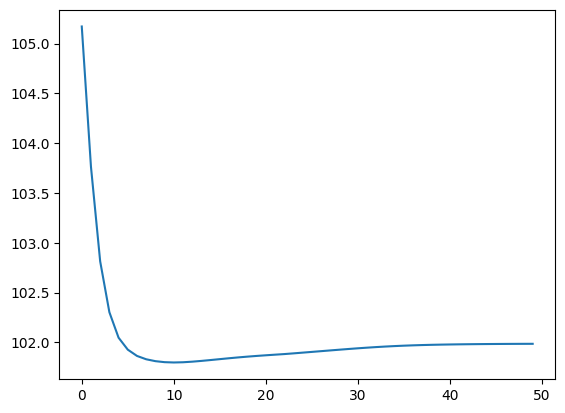

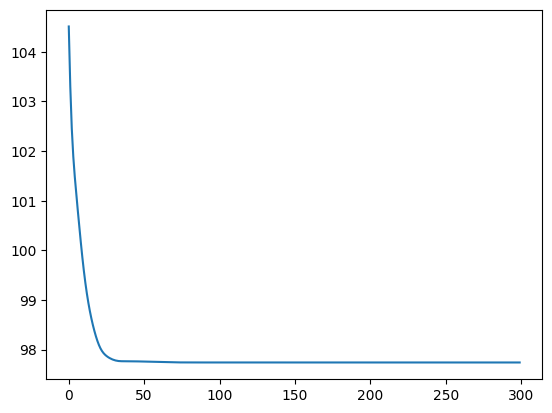

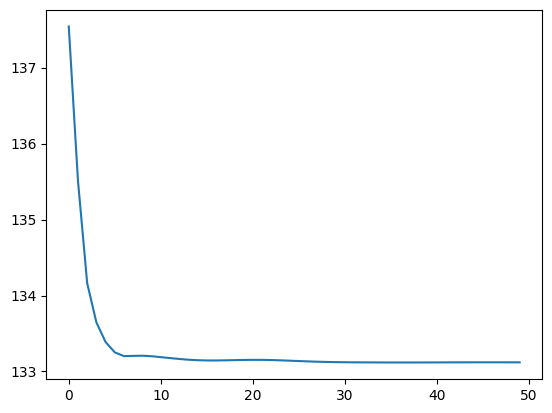

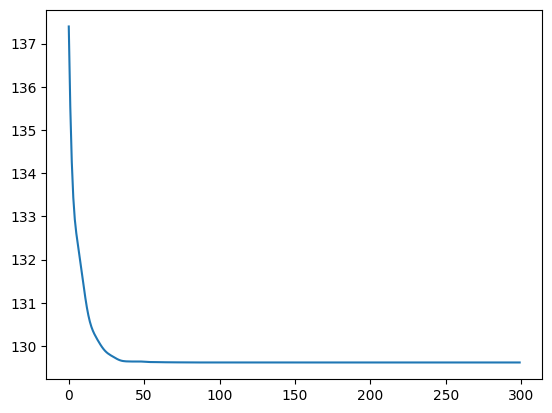

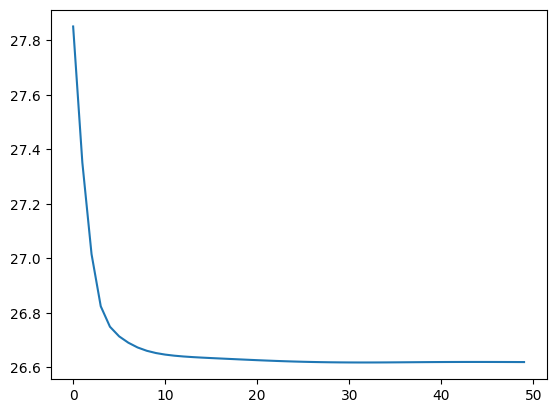

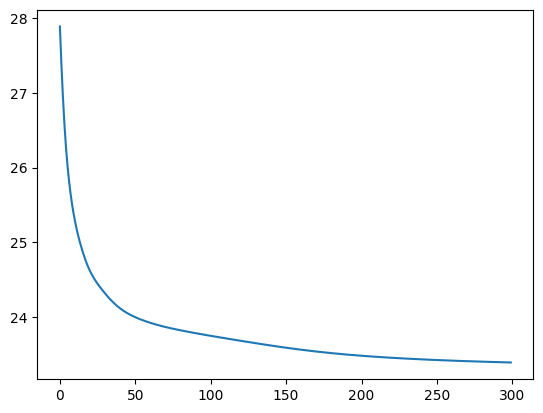

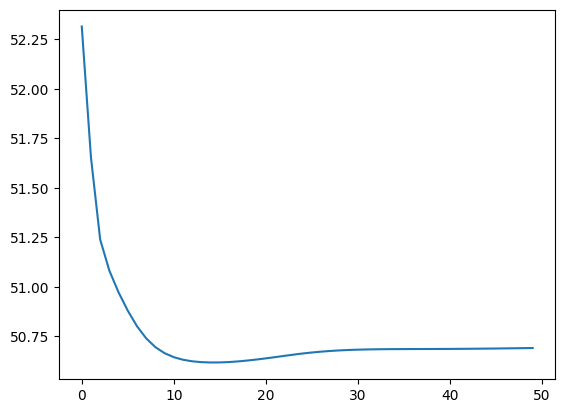

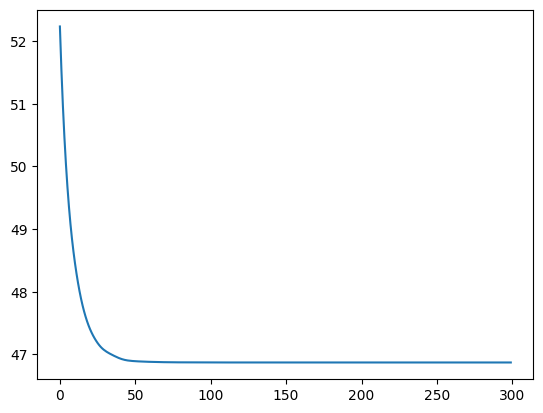

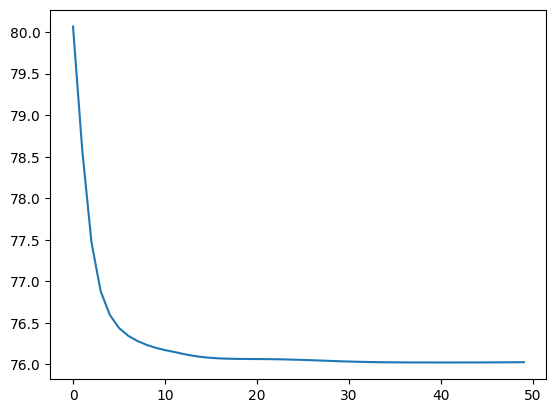

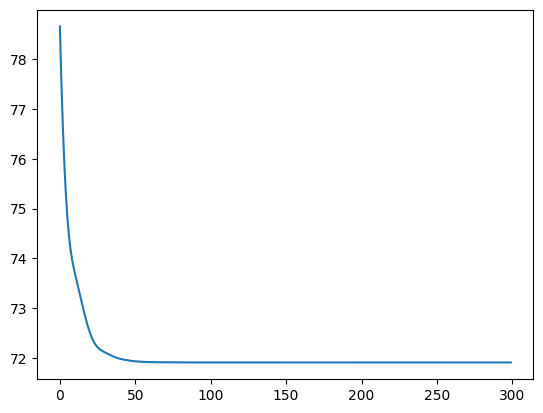

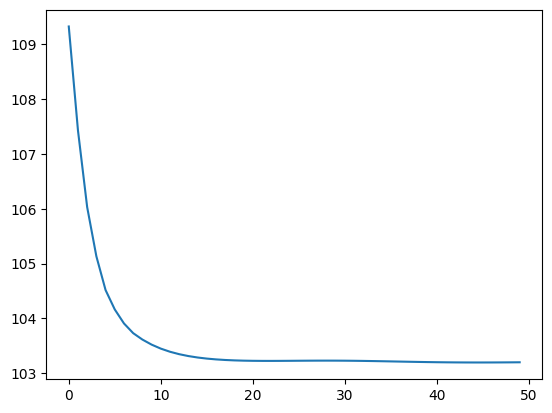

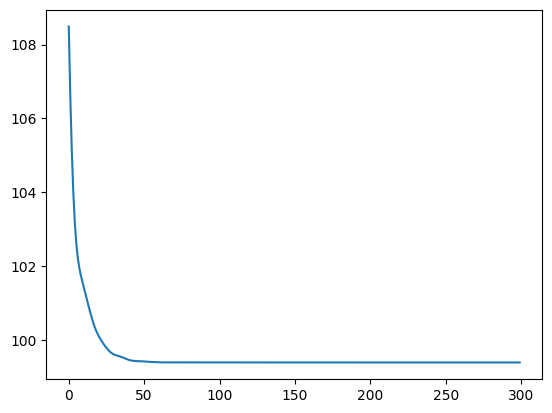

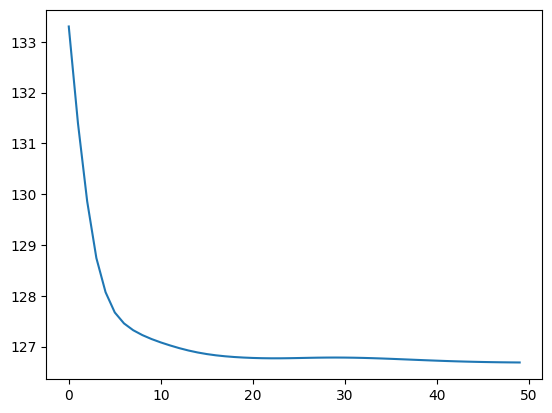

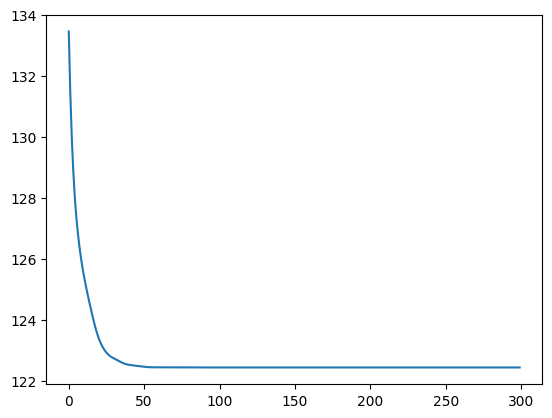

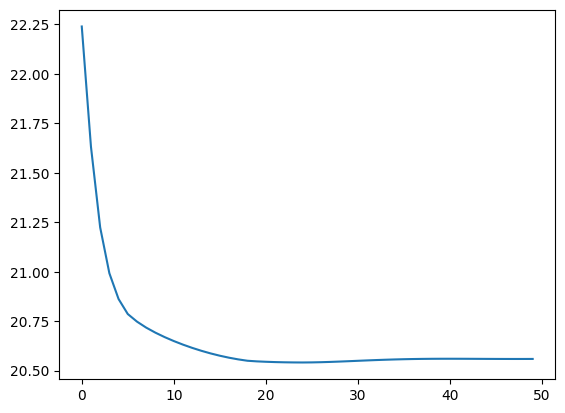

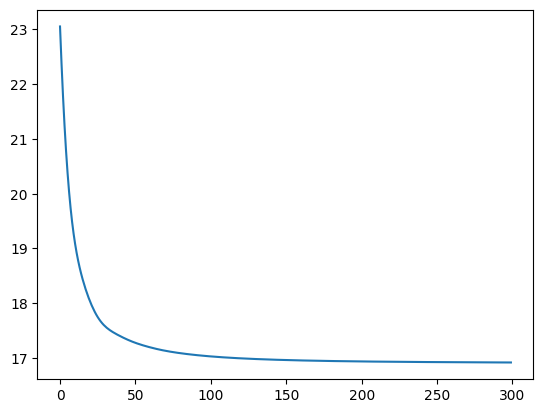

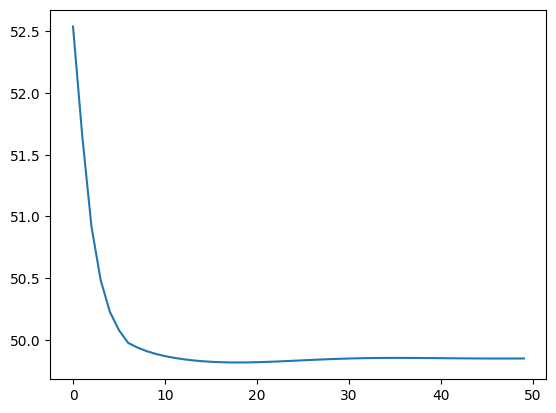

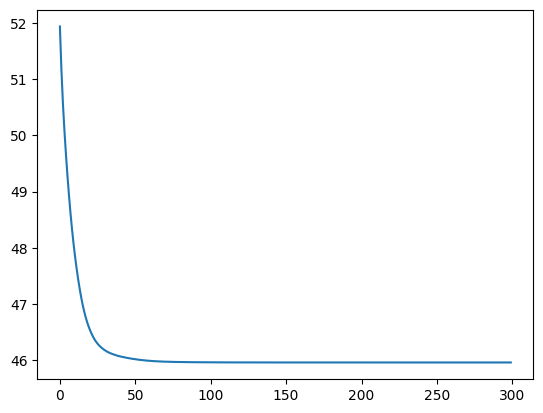

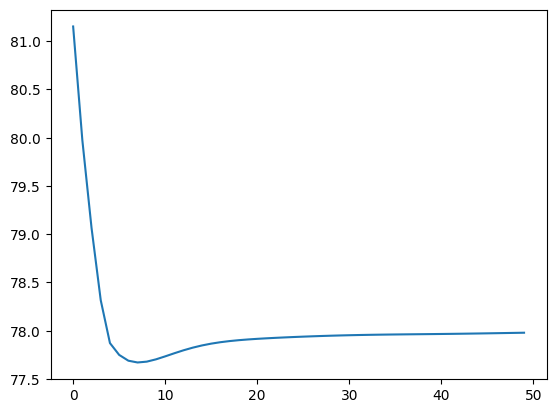

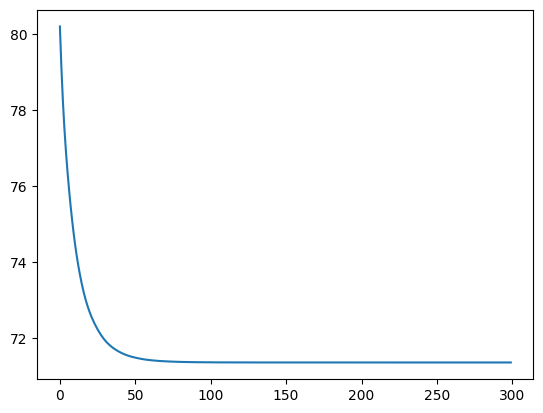

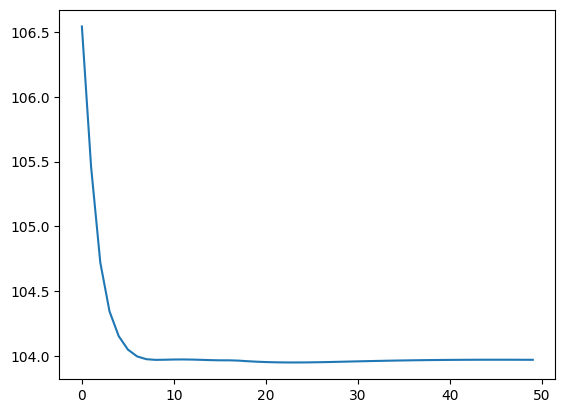

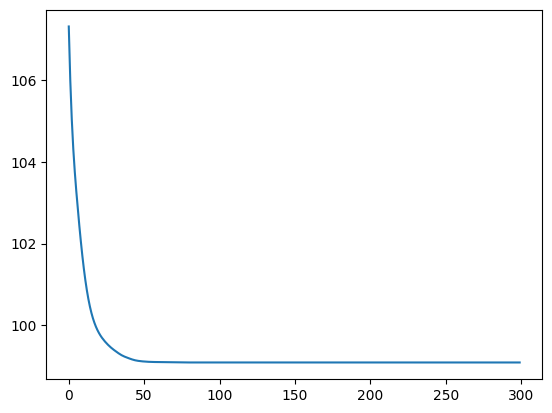

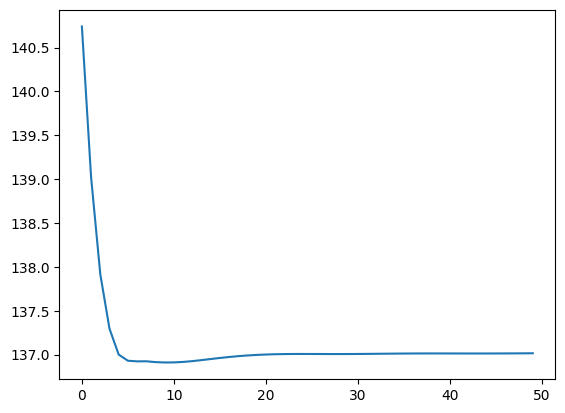

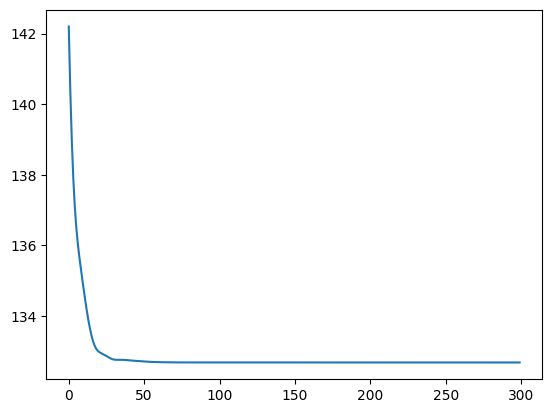

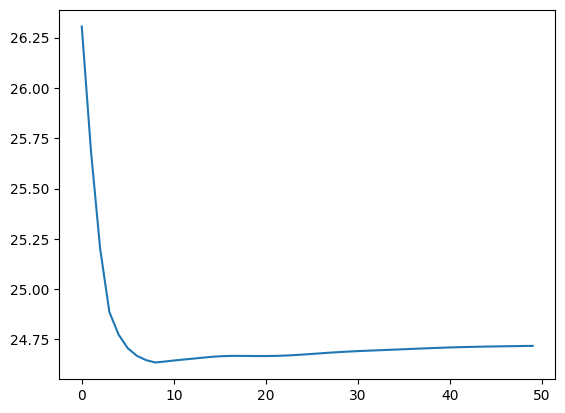

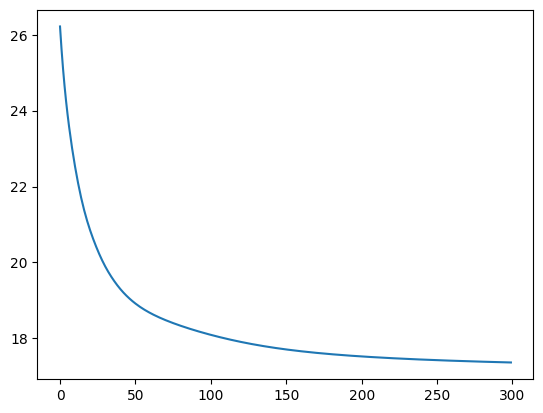

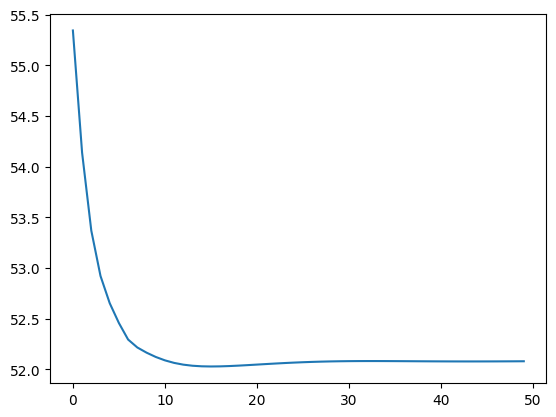

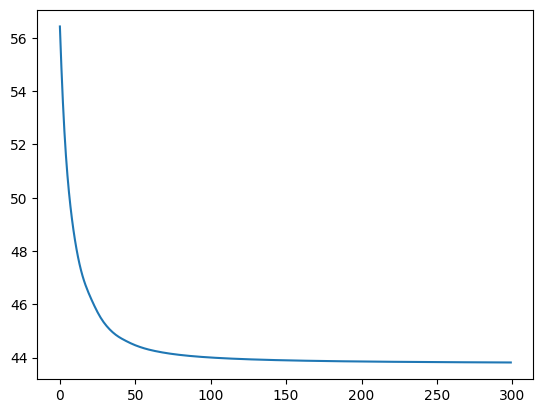

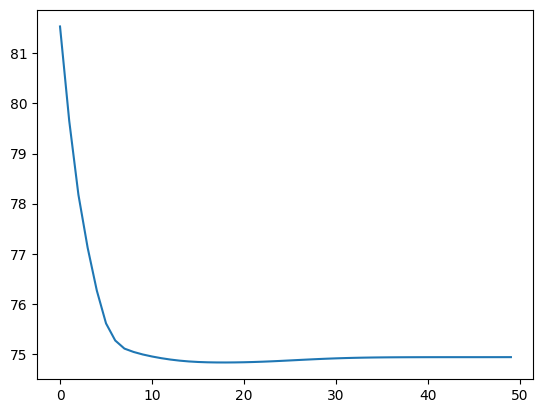

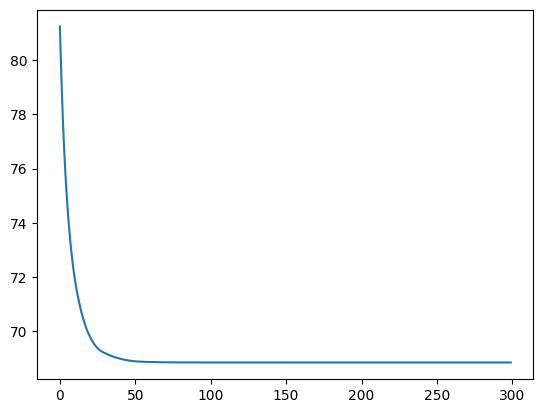

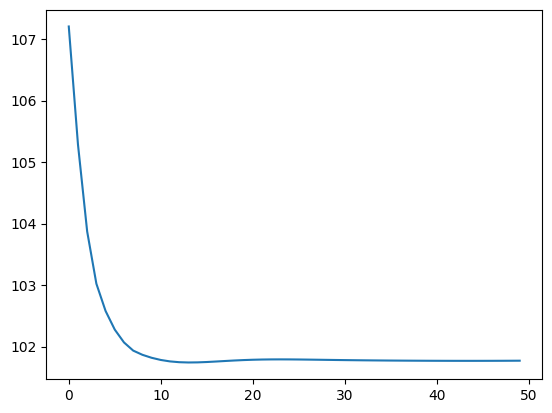

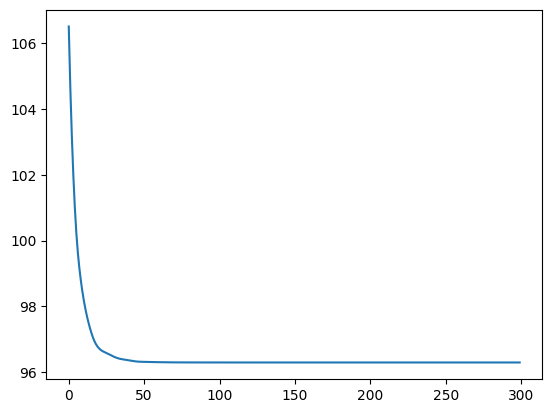

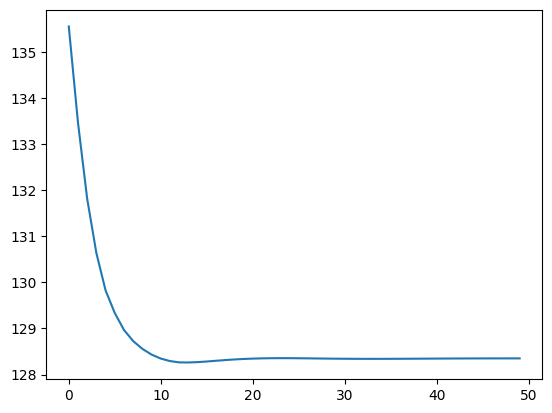

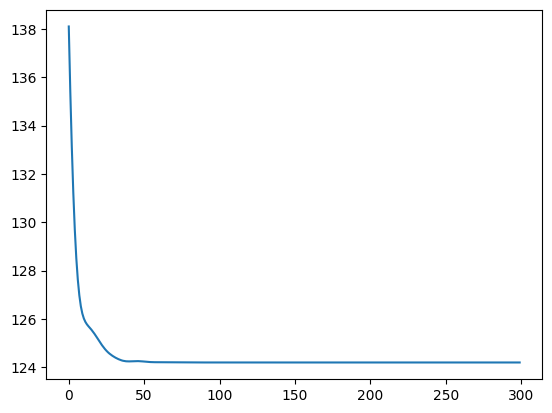

In [153]:
X = torch.zeros(5,T)
Y = torch.zeros(5,T)
e_lr_ls = np.zeros(5)
e_lr_nuc = np.zeros(5)

for i in range(10):
    e_idx = 0
    idx1 = 0
    idx2 = 0
    for t in range(T):
        if np.mod(t,2) == 0:
            x = X_design_half[:,idx1]
            idx1 += 1
        else:
            x = X_design_k1[:,idx2]
            idx2 += 1
        y = torch.sigmoid(W_true @ x) + 0.5*torch.randn(5)
        #y = W_true @ x + 0.5*torch.randn(5)
        X[:,t] = x
        Y[:,t] = y
        if np.mod(t,20) == 0 and t > 0:
            W_hat = fit_glm_nuc(X[:,:t],Y[:,:t],1.1,50)
            #e_design.append(torch.linalg.norm(W_hat - W_true).detach().cpu().numpy())
            e_lr_nuc[e_idx] += torch.linalg.norm(W_hat - W_true).detach().cpu().numpy() / 10
            W_hat = fit_glm(X[:,:t],Y[:,:t],300)
            e_lr_ls[e_idx] += torch.linalg.norm(W_hat - W_true).detach().cpu().numpy() / 10
            e_idx += 1

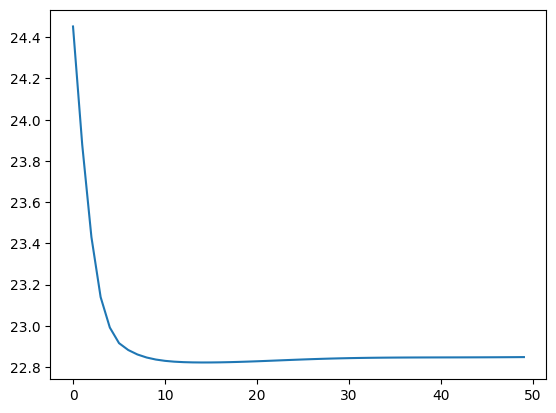

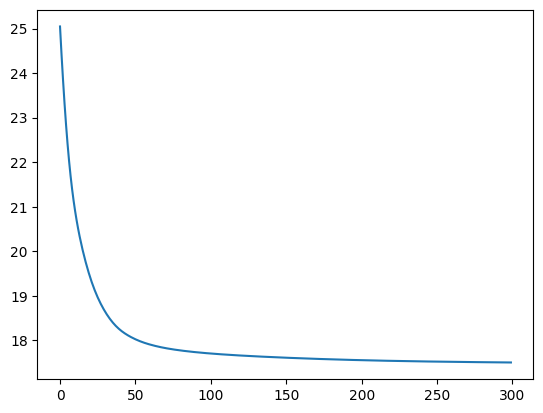

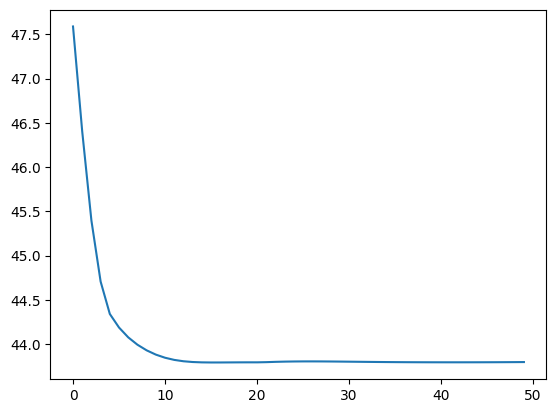

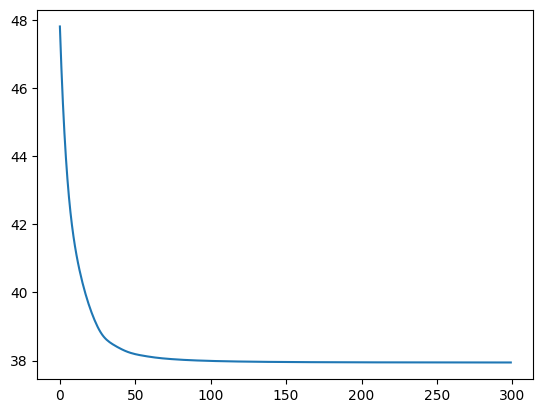

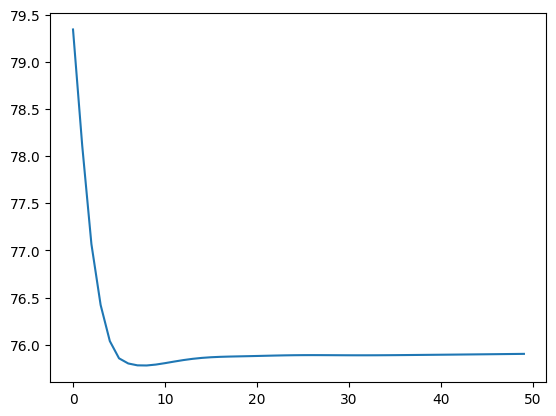

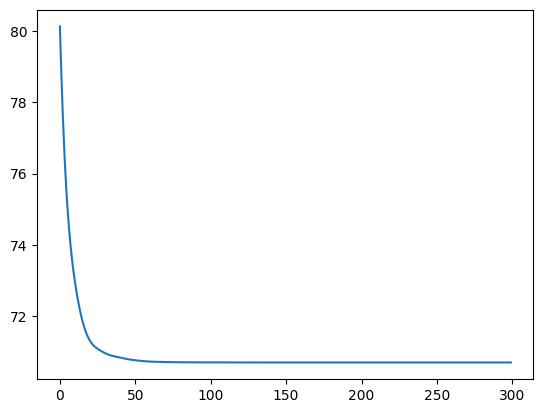

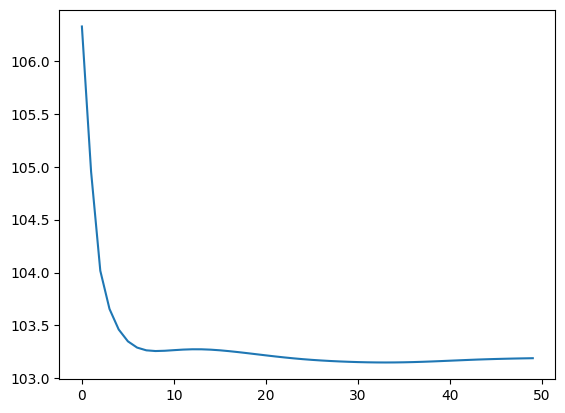

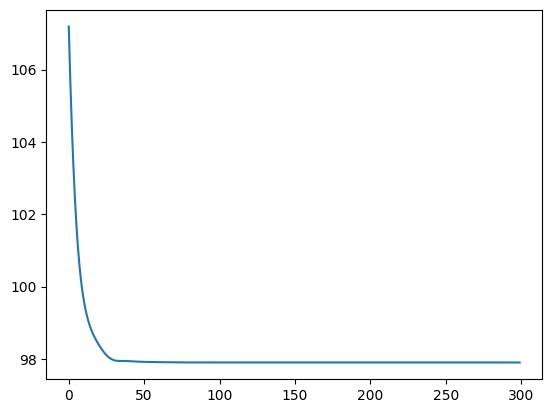

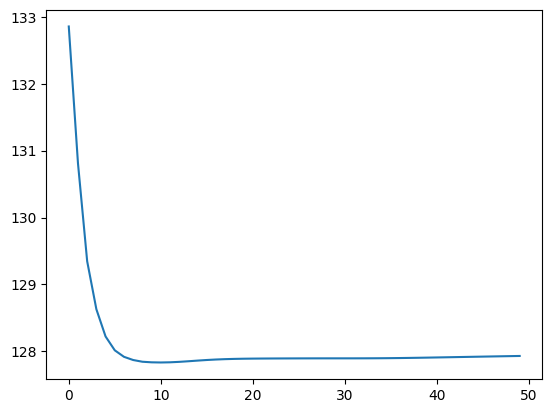

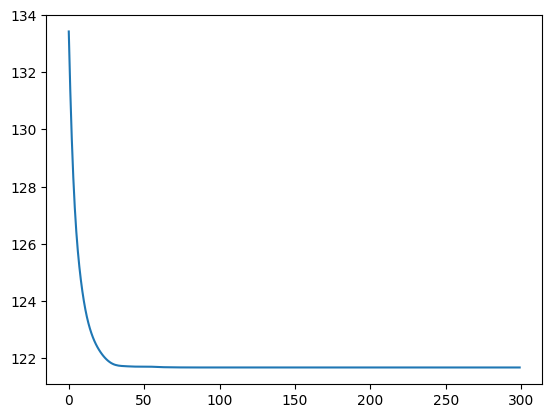

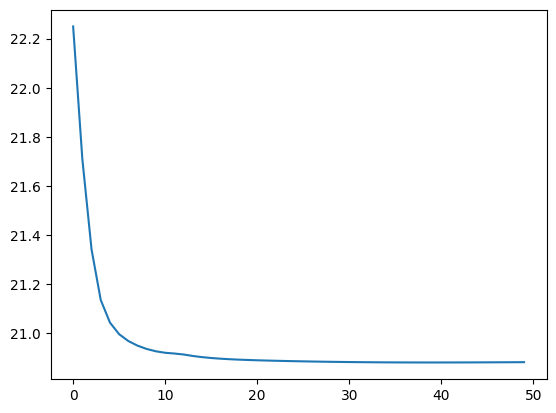

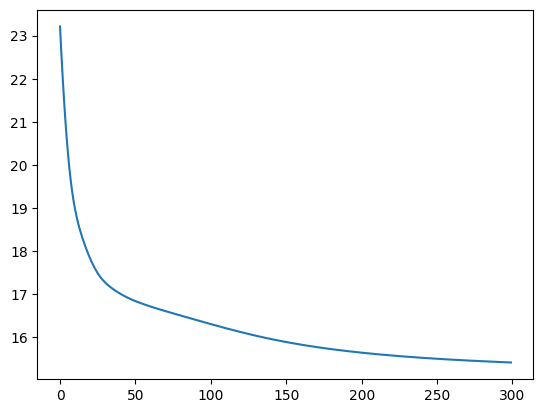

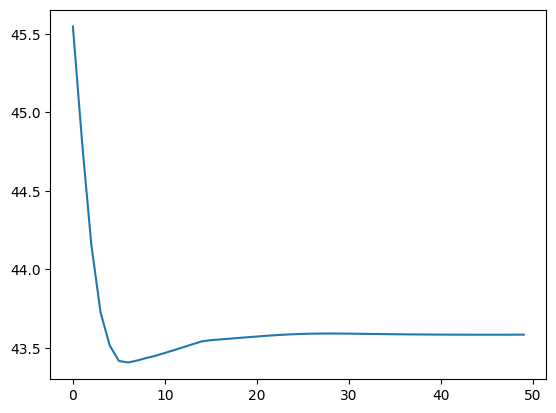

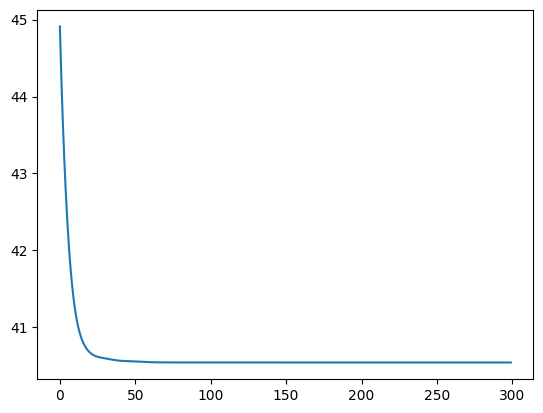

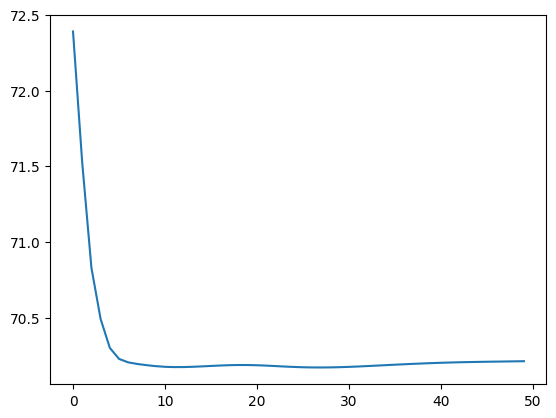

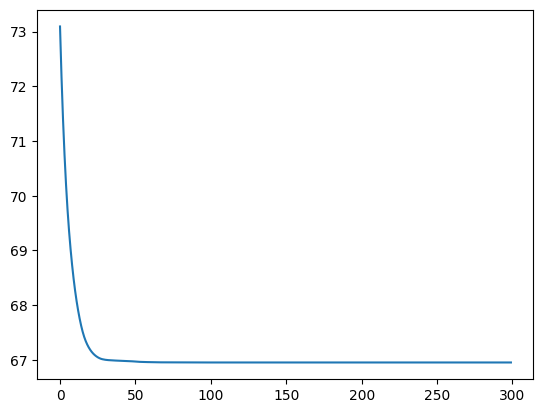

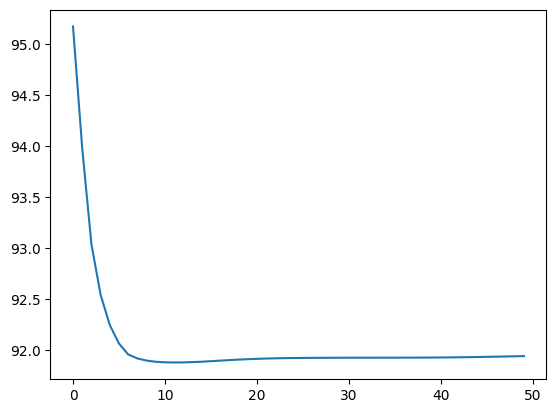

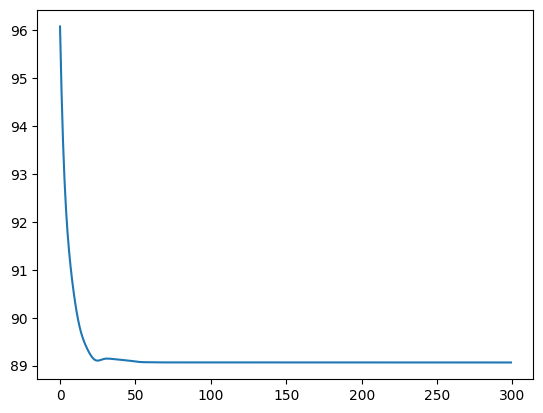

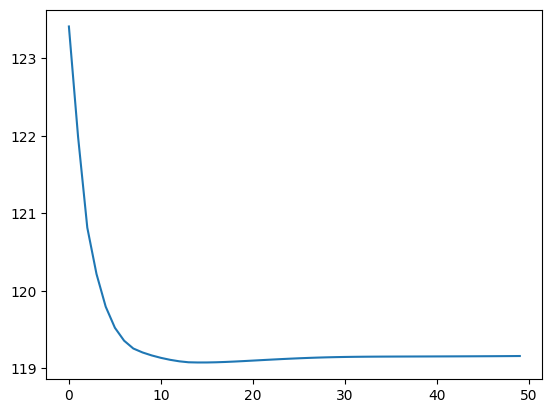

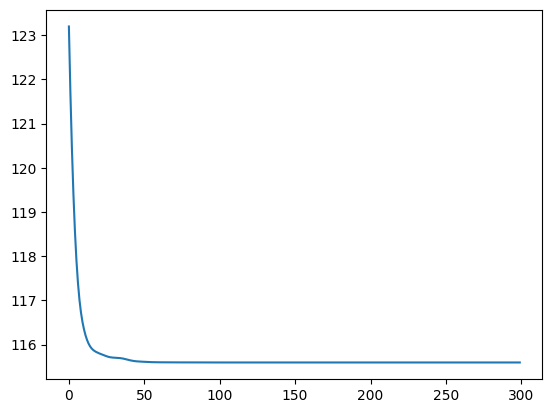

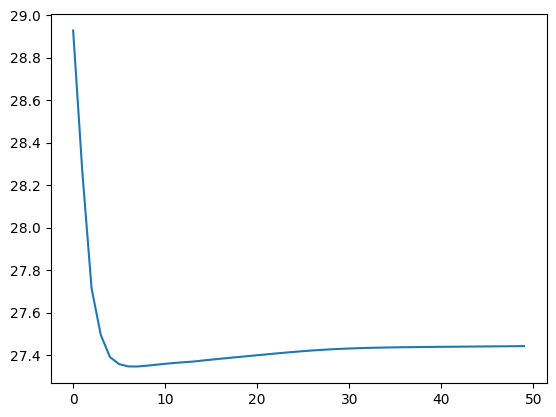

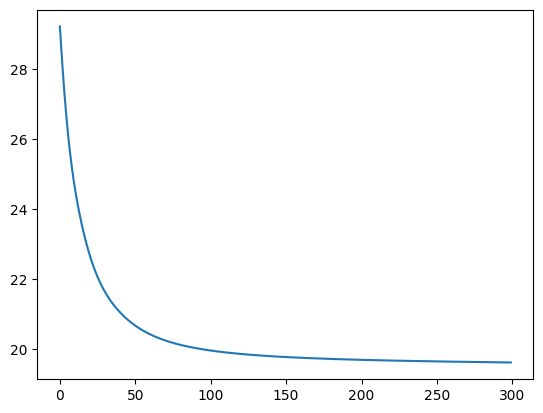

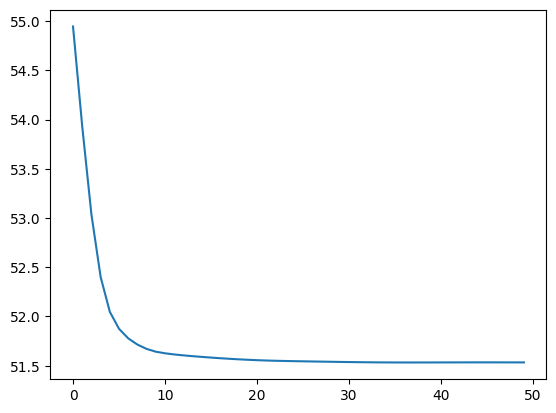

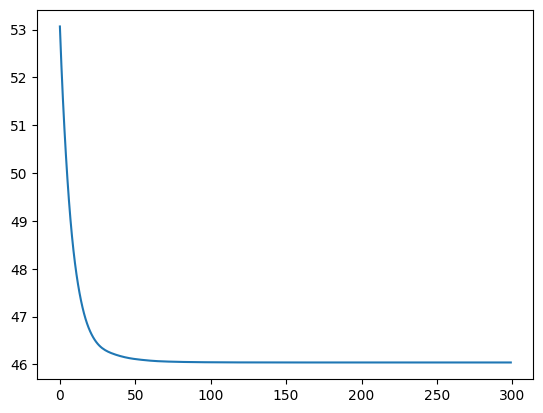

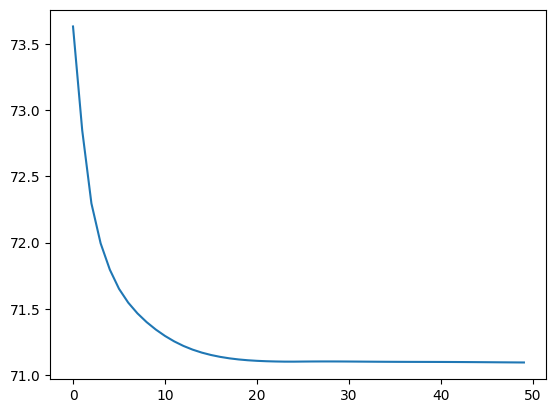

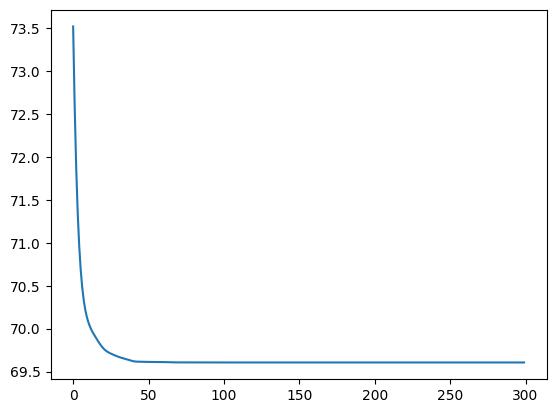

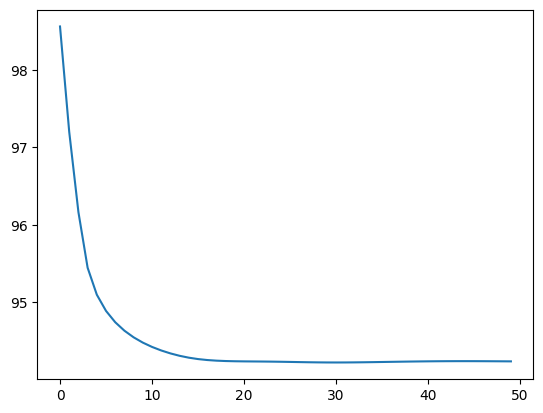

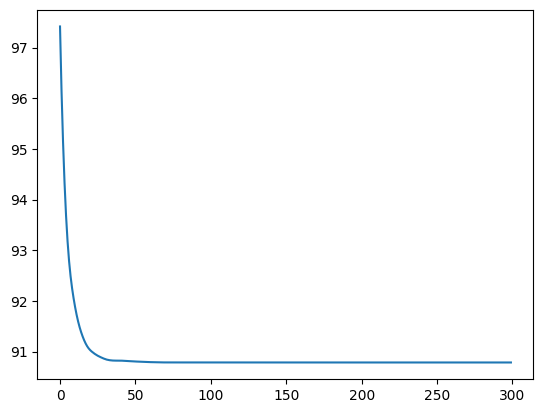

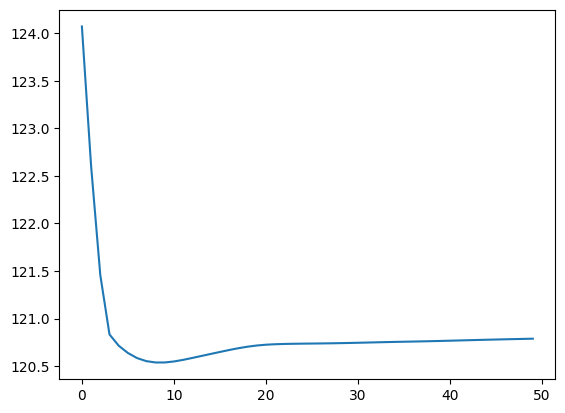

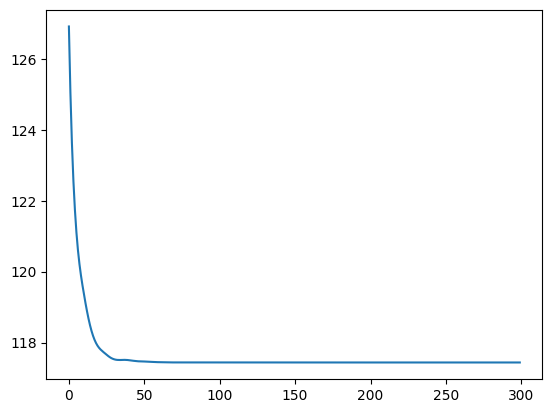

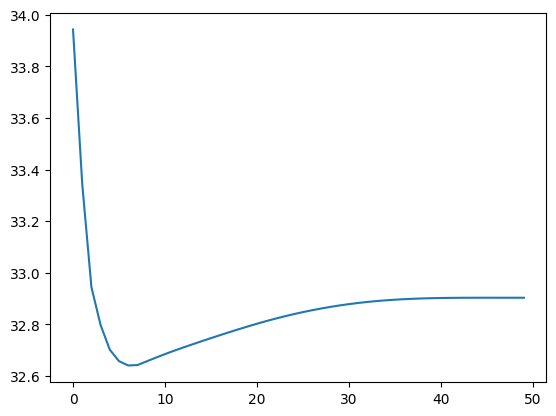

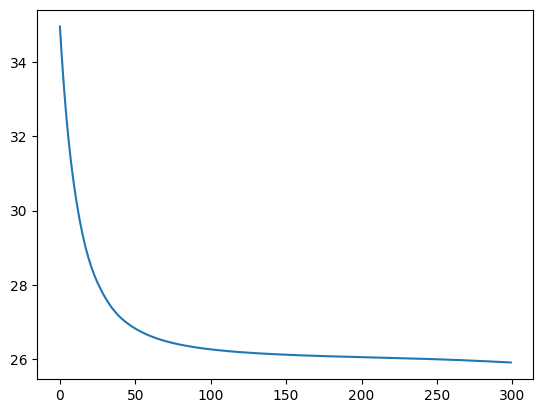

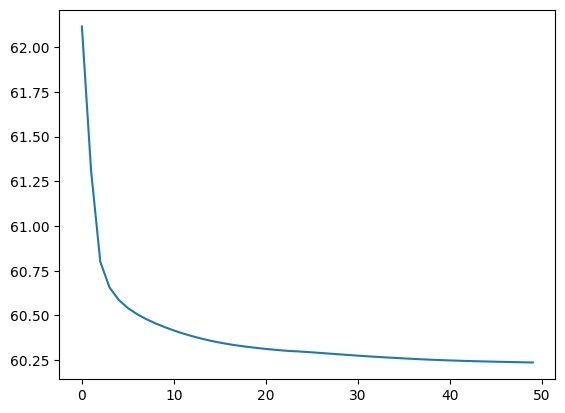

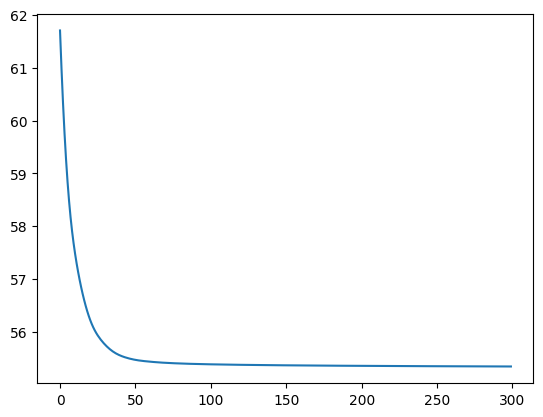

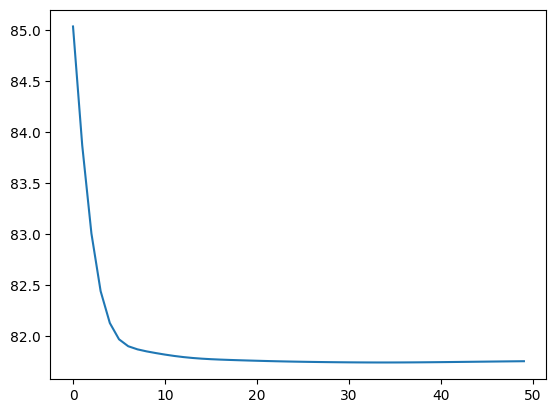

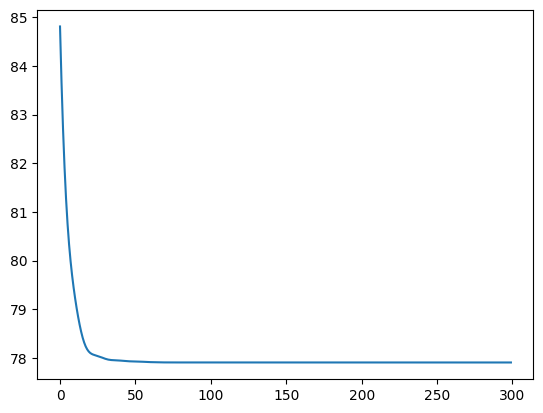

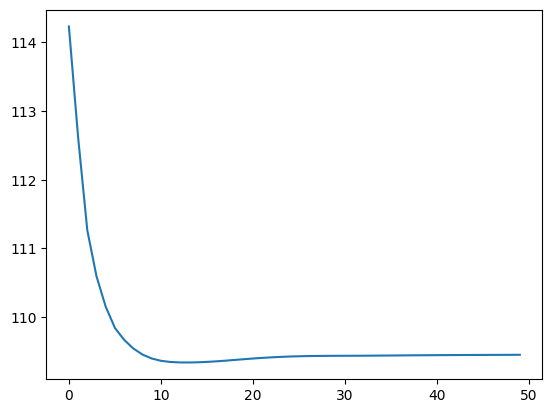

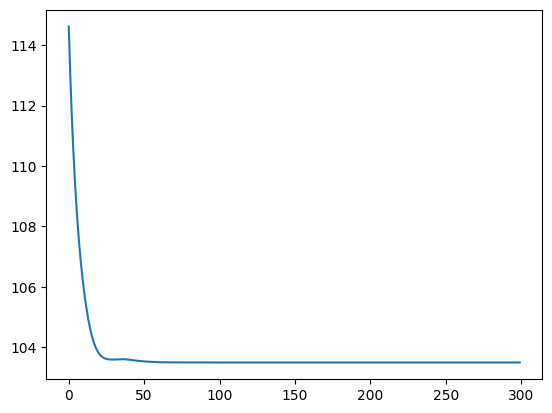

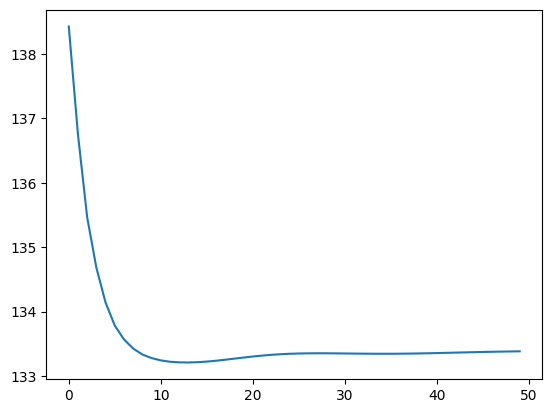

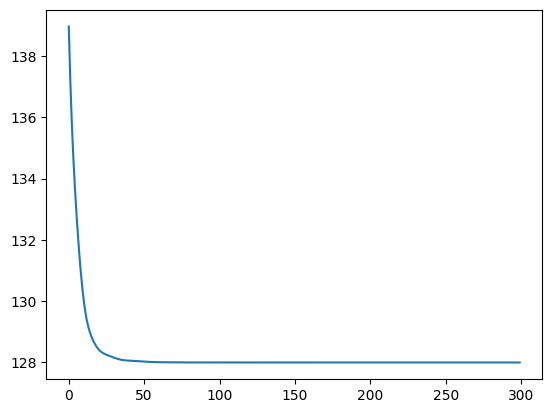

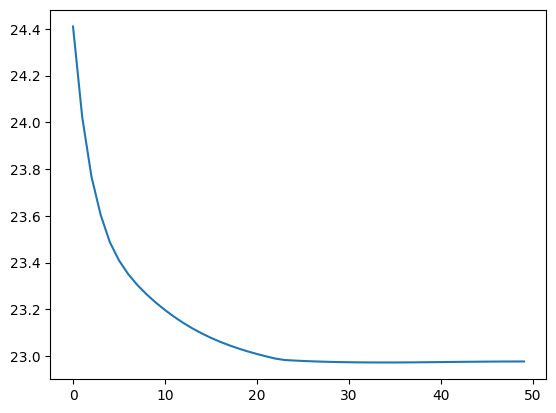

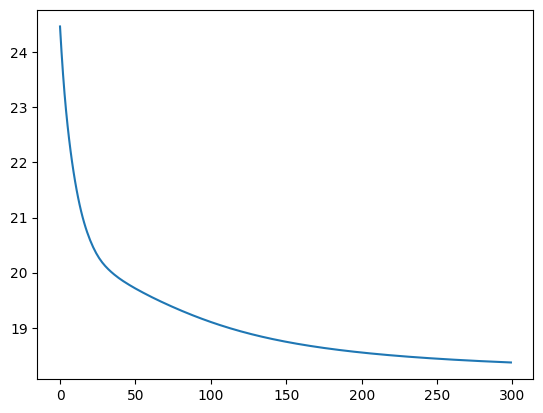

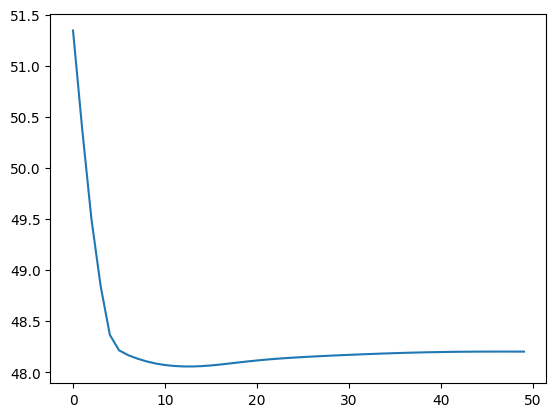

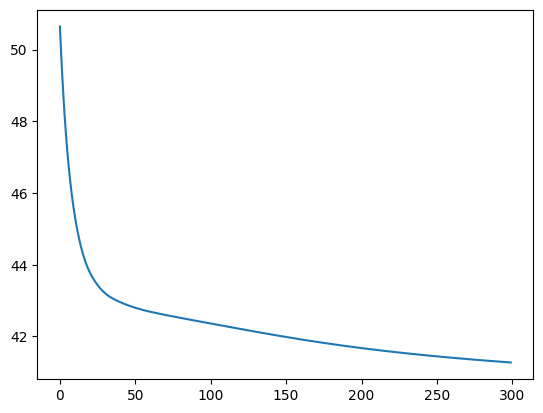

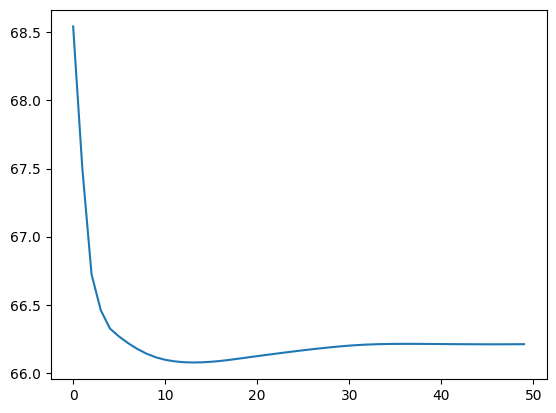

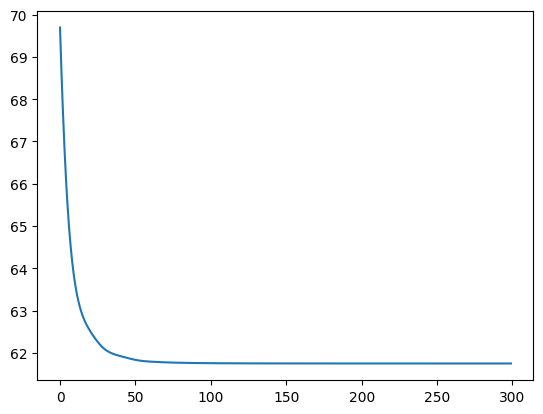

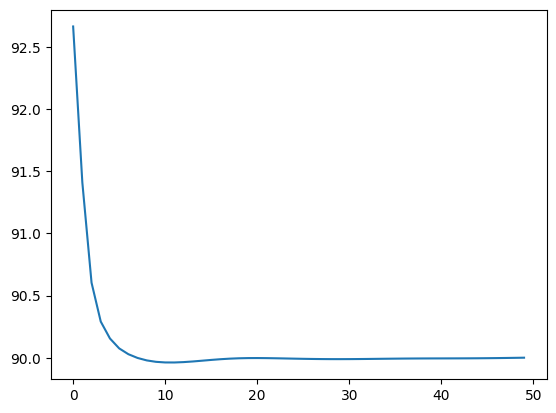

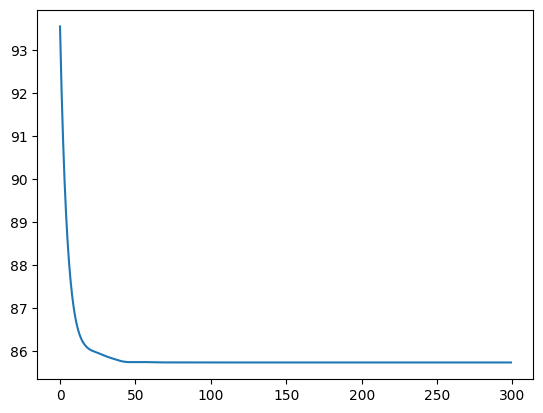

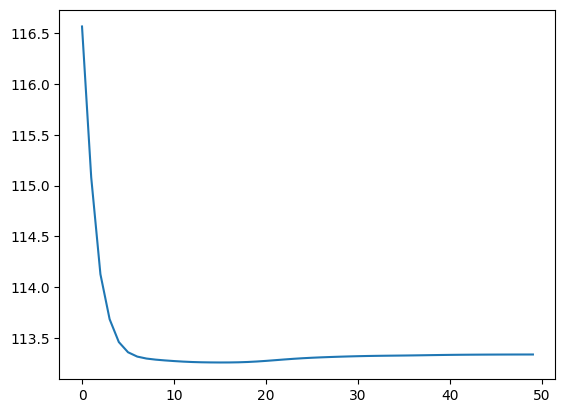

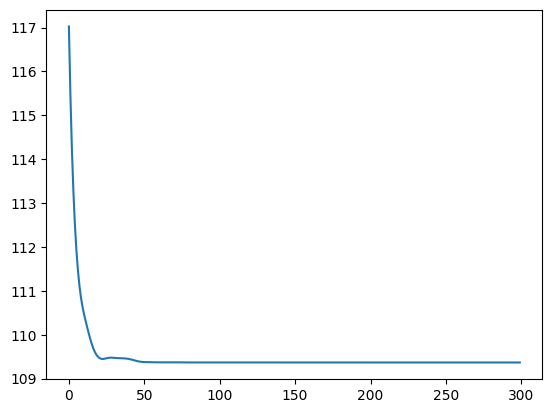

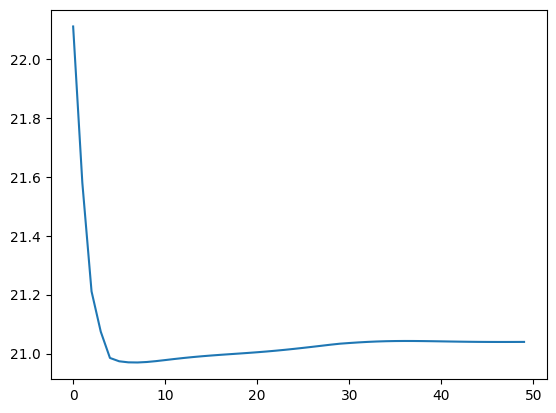

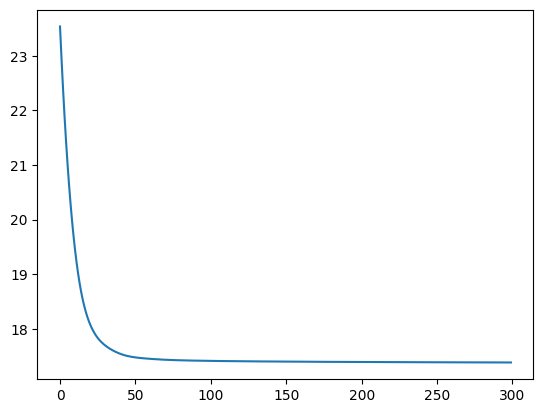

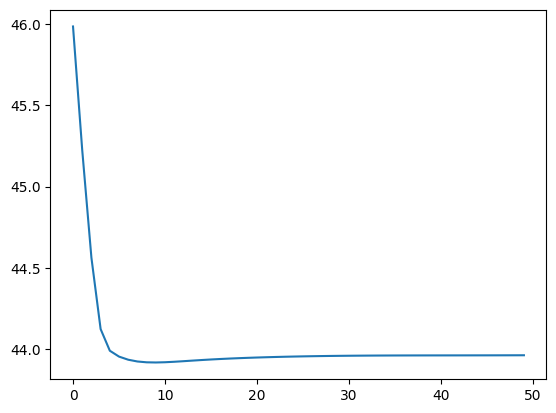

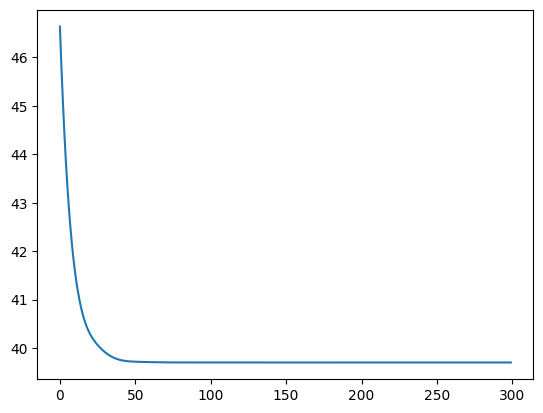

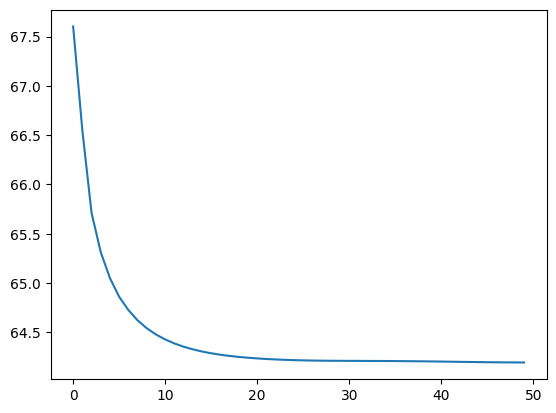

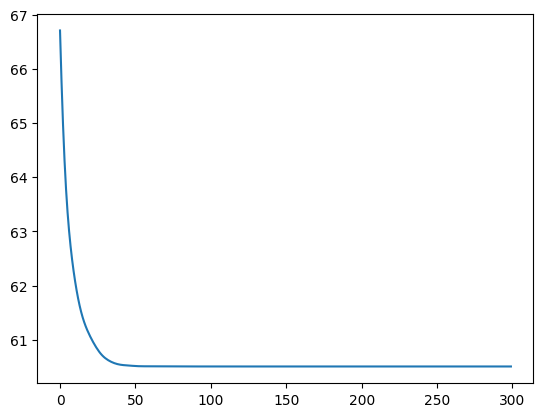

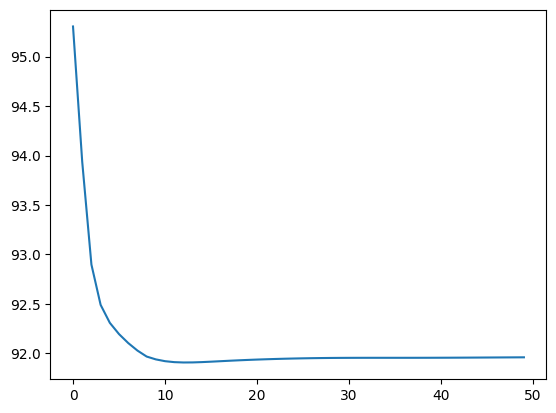

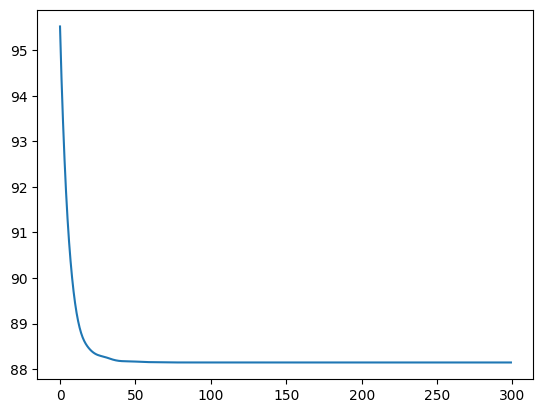

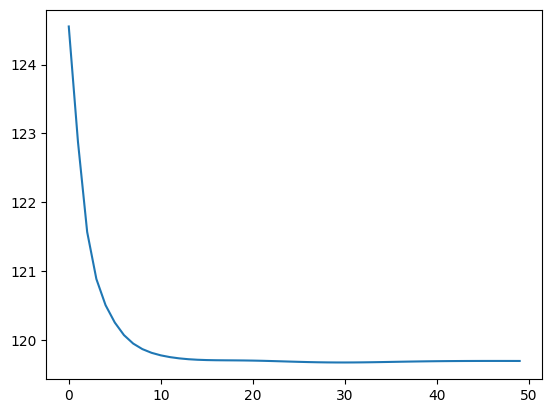

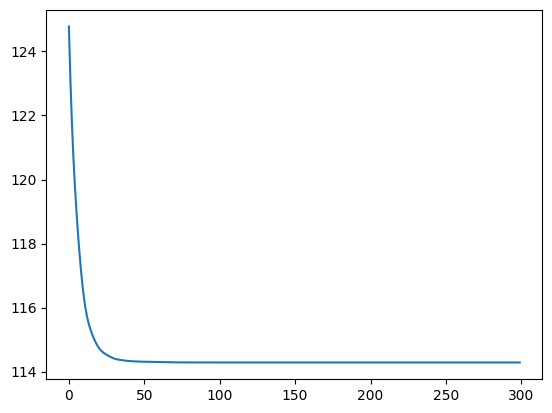

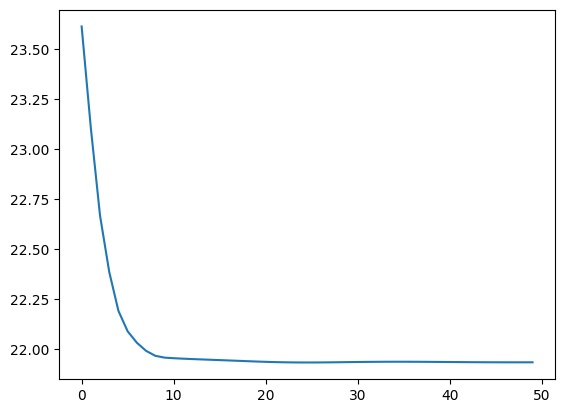

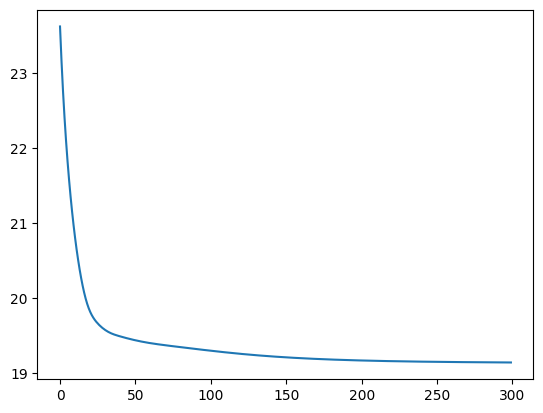

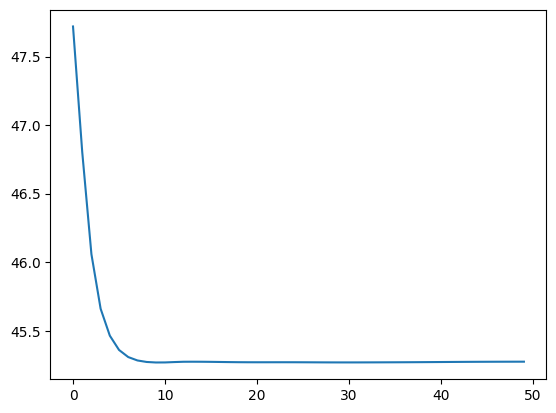

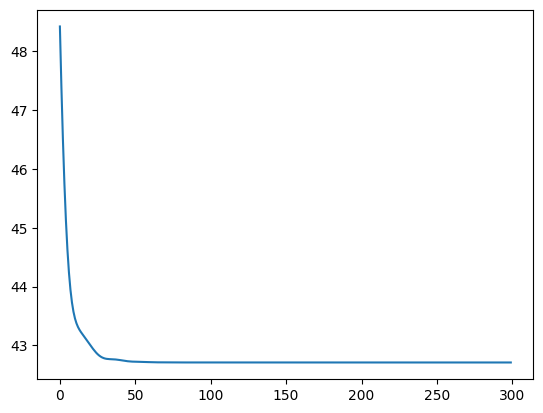

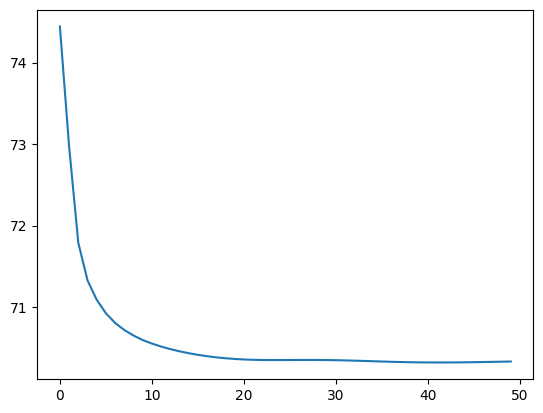

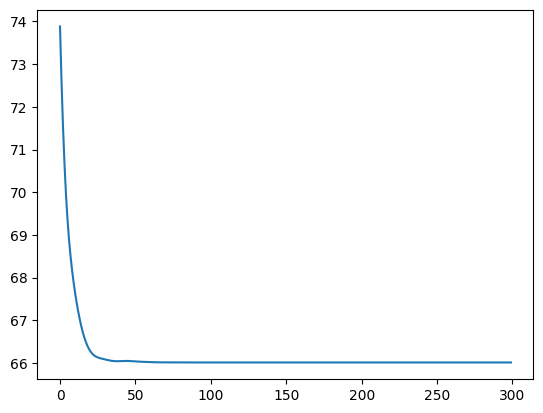

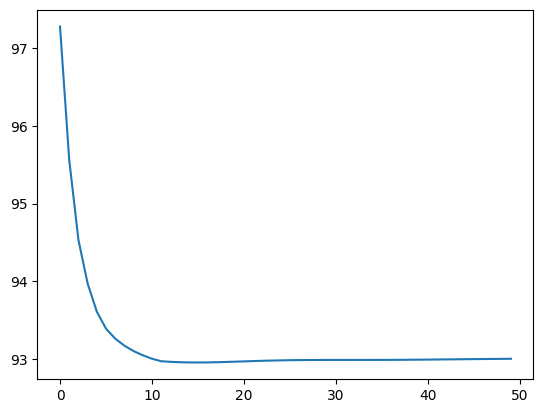

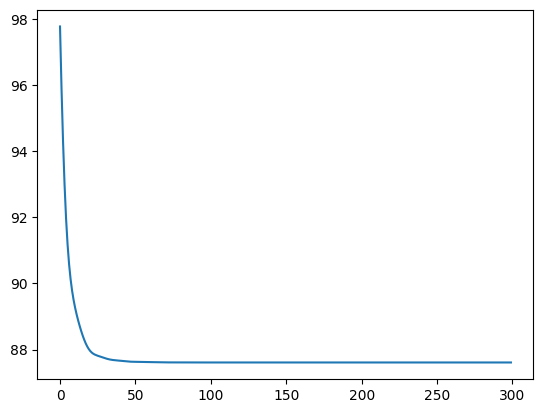

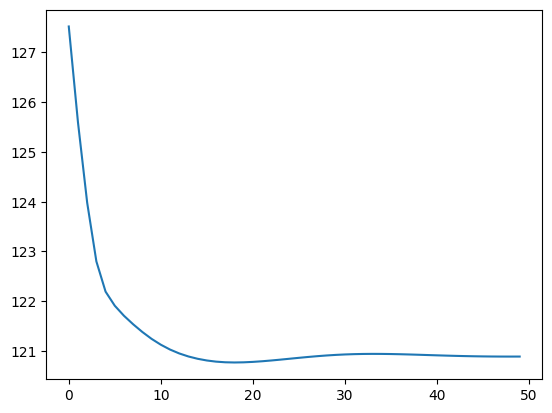

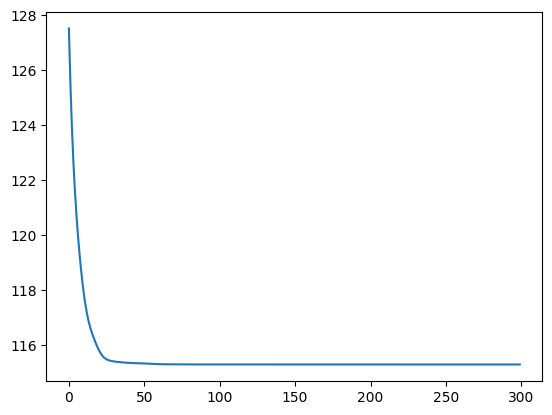

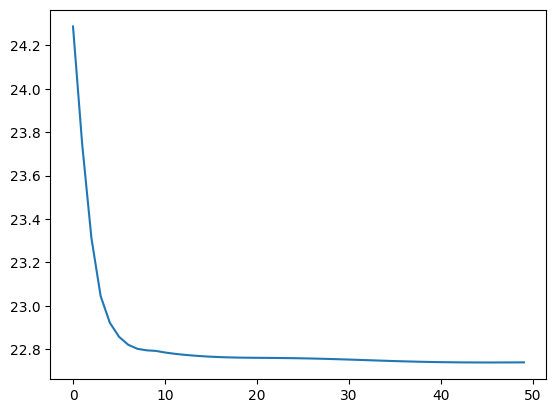

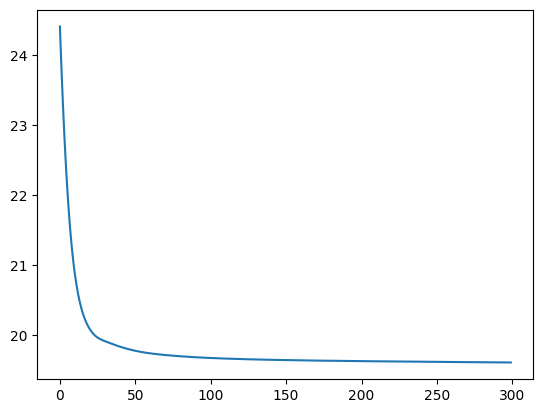

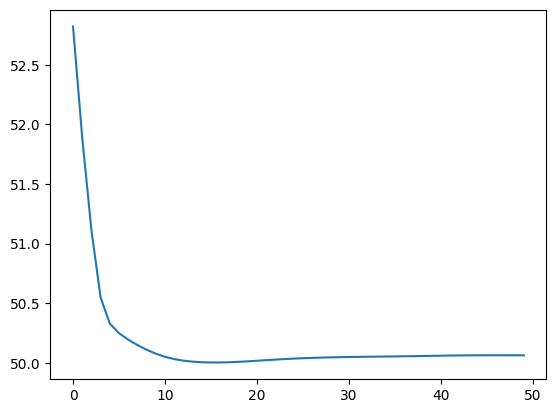

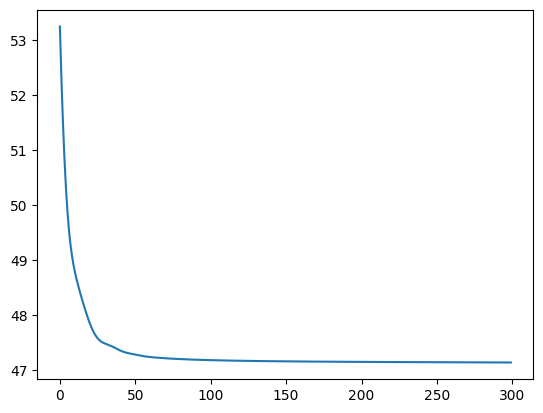

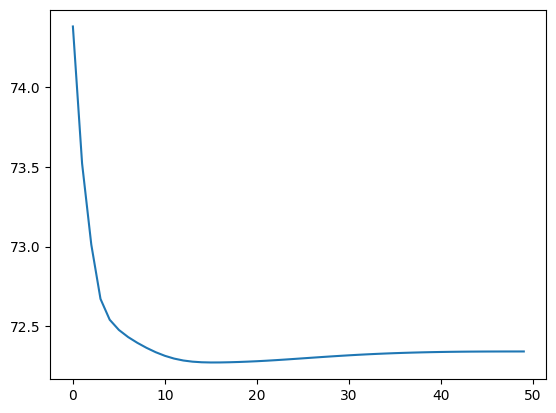

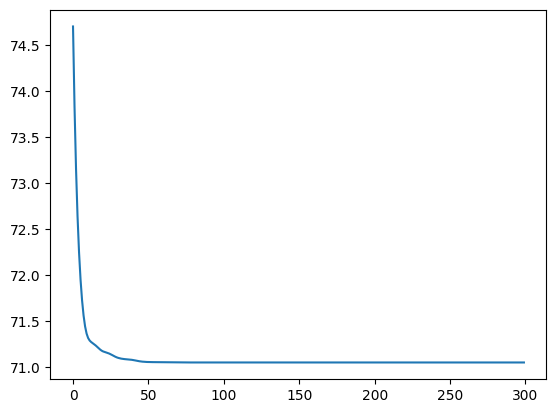

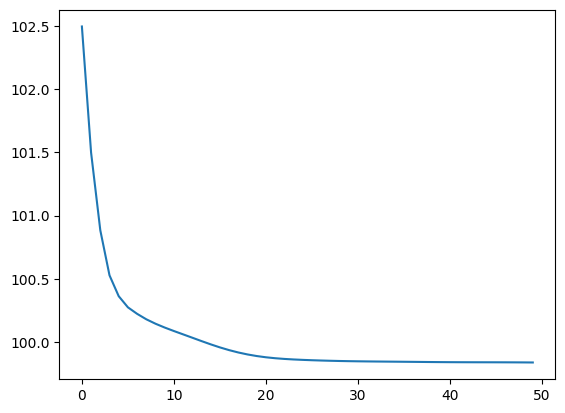

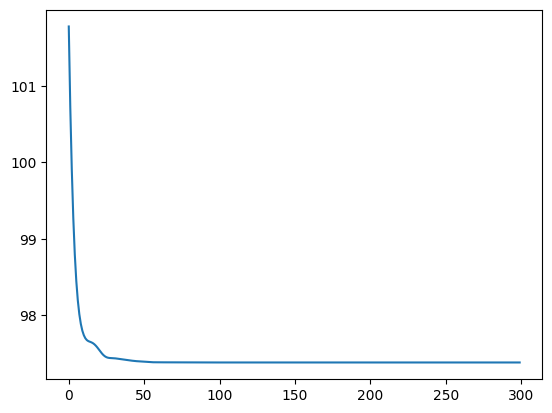

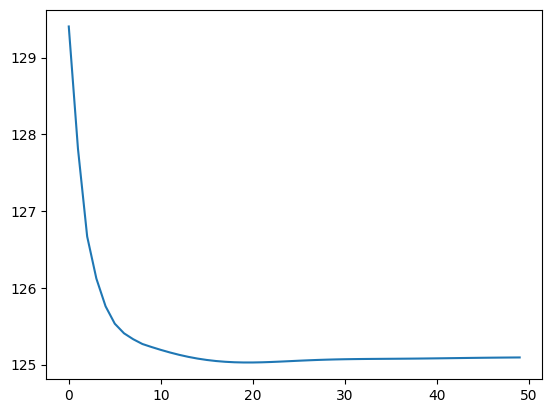

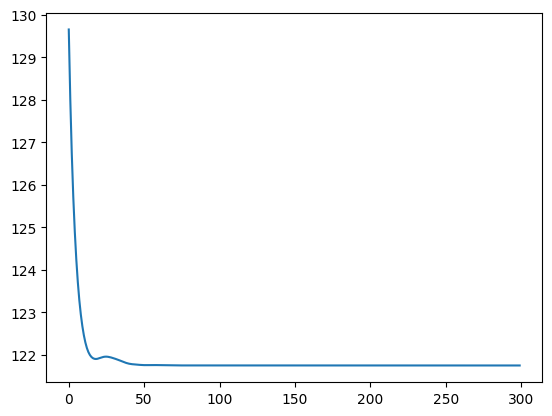

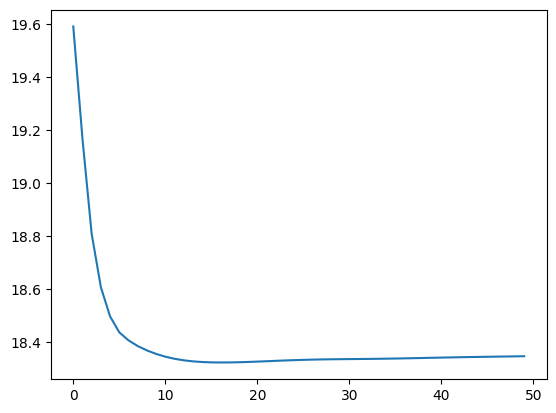

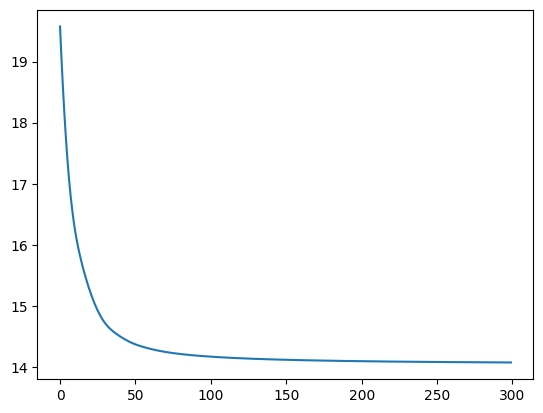

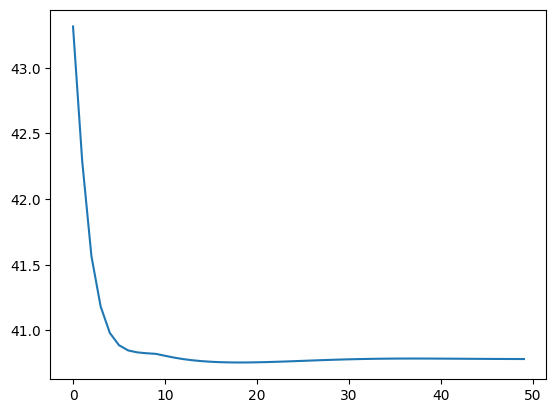

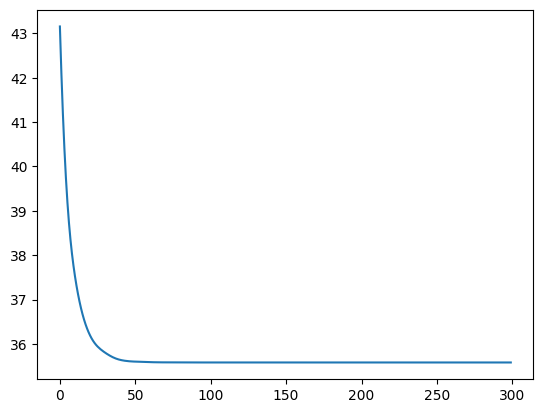

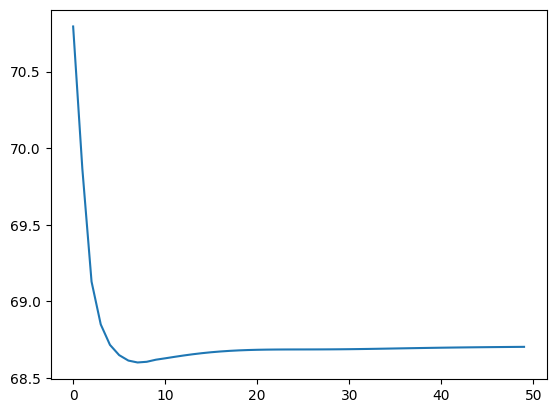

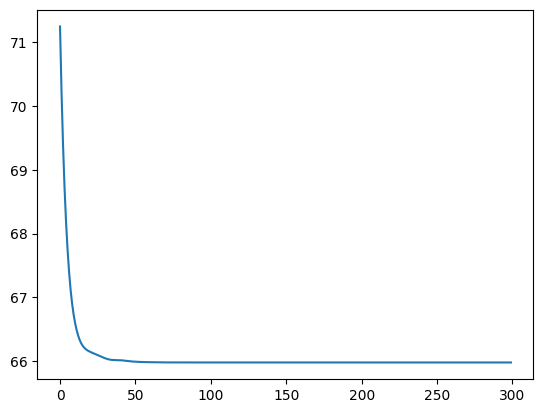

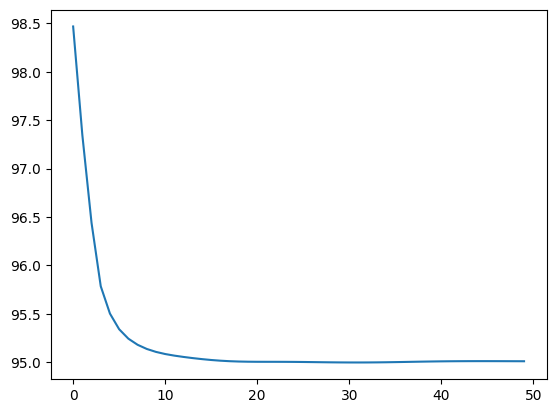

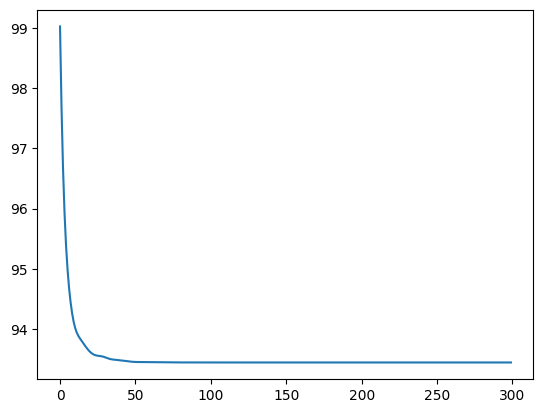

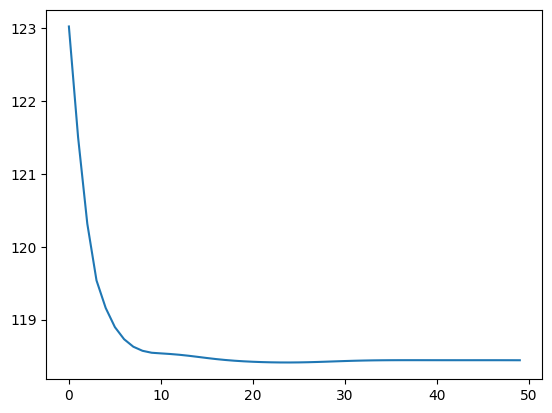

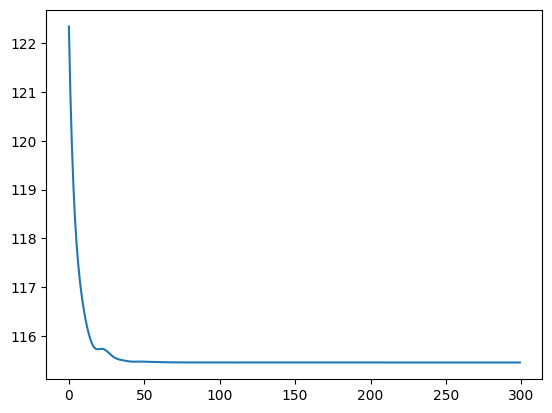

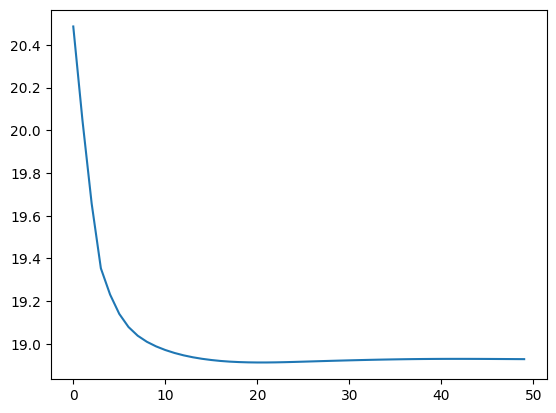

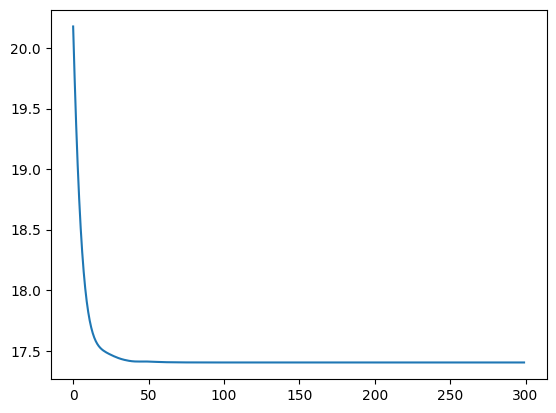

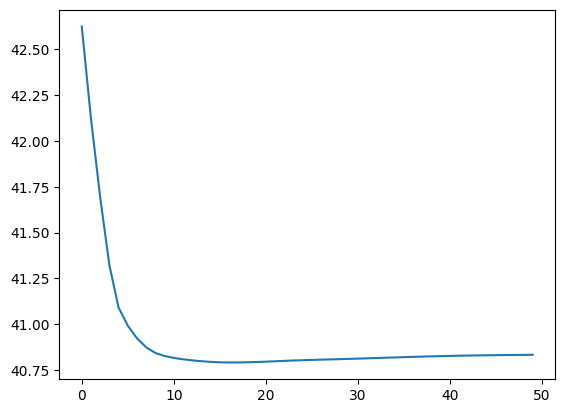

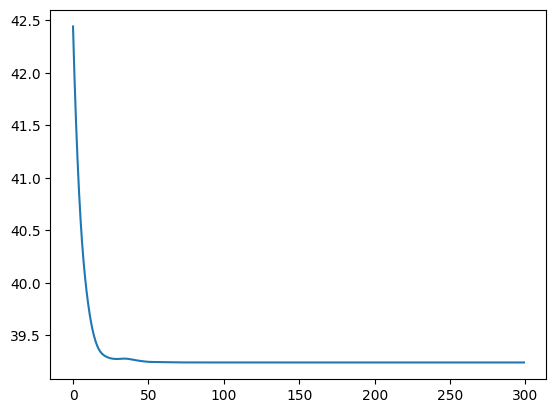

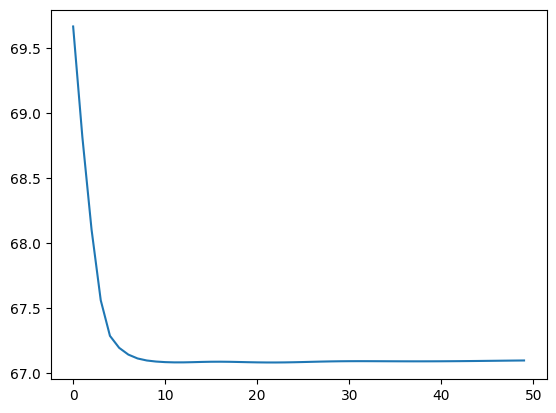

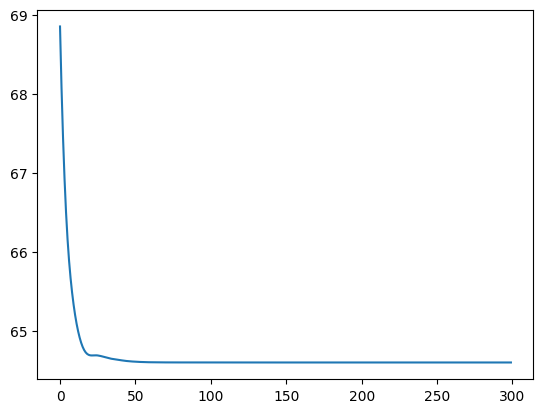

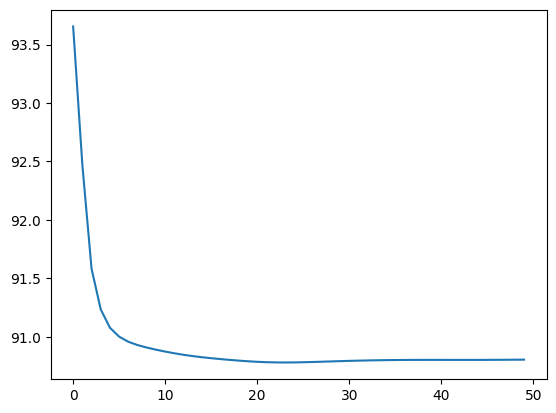

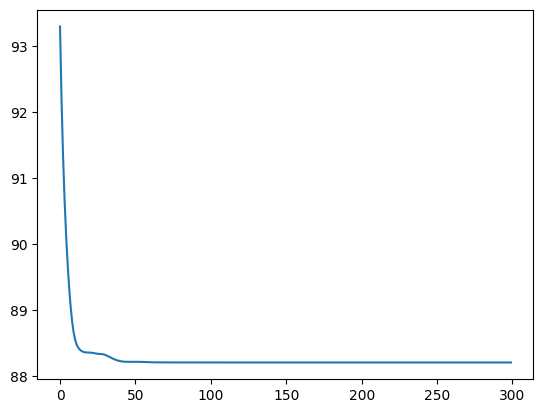

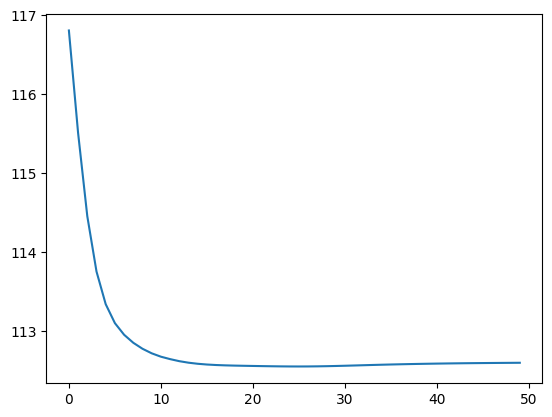

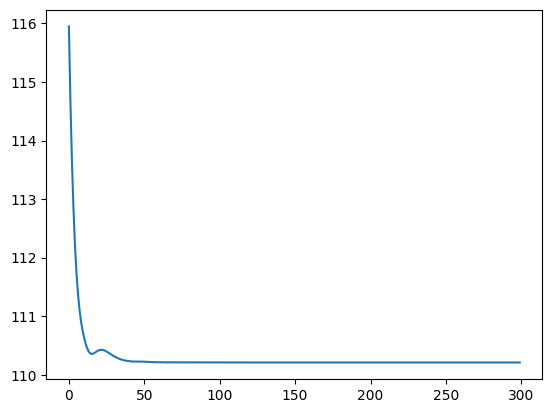

In [154]:
X = torch.zeros(5,T)
Y = torch.zeros(5,T)
e_full_nuc = np.zeros(5)
e_full_ls = np.zeros(5)

for i in range(10):
    e_idx = 0
    idx1 = 0
    idx2 = 0
    for t in range(T):
        x = X_design_full[:,t]
        y = torch.sigmoid(W_true @ x) + 0.5*torch.randn(5)
        #y = W_true @ x + 0.5*torch.randn(5)
        X[:,t] = x
        Y[:,t] = y
        if np.mod(t,20) == 0 and t > 0:
            W_hat = fit_glm_nuc(X[:,:t],Y[:,:t],1.1,50)
            #e_design.append(torch.linalg.norm(W_hat - W_true).detach().cpu().numpy())
            e_full_nuc[e_idx] += torch.linalg.norm(W_hat - W_true).detach().cpu().numpy() / 10
            W_hat = fit_glm(X[:,:t],Y[:,:t],300)
            e_full_ls[e_idx] += torch.linalg.norm(W_hat - W_true).detach().cpu().numpy() / 10
            e_idx += 1

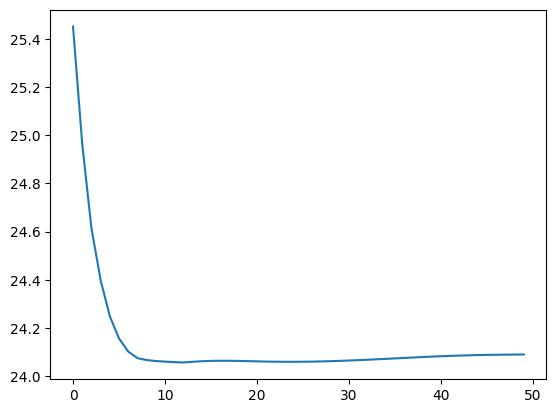

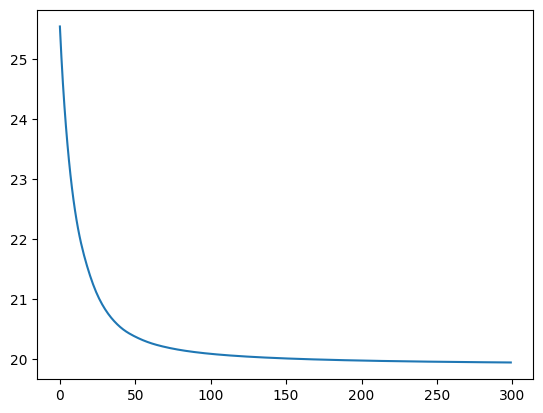

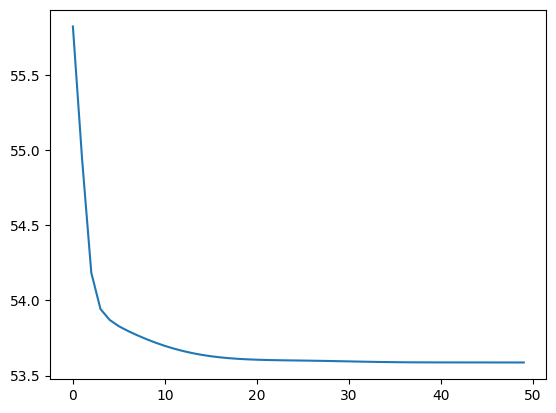

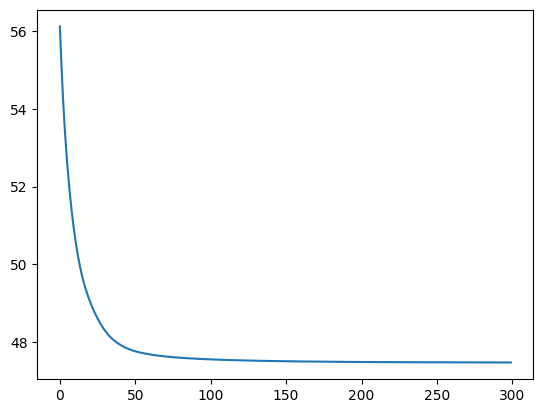

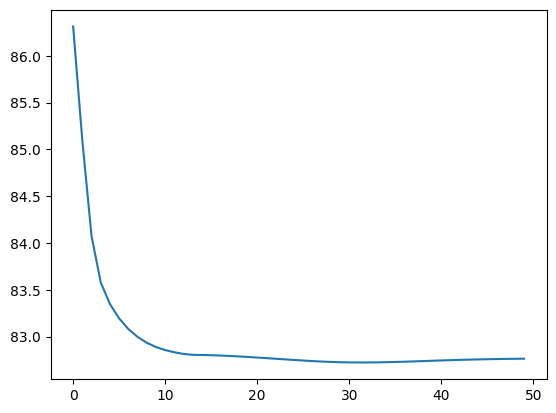

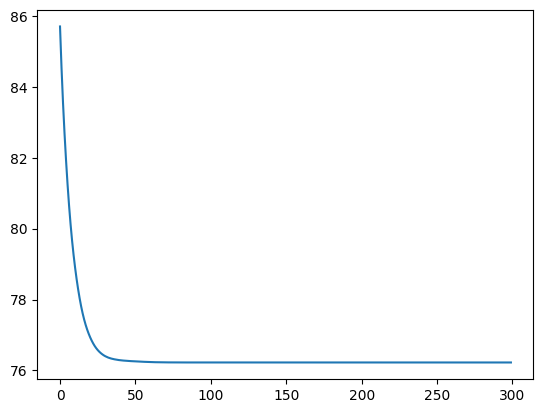

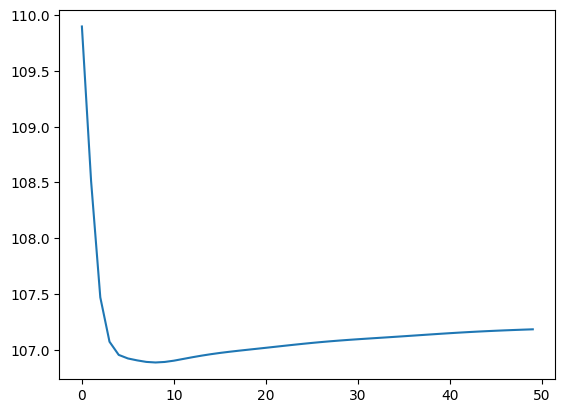

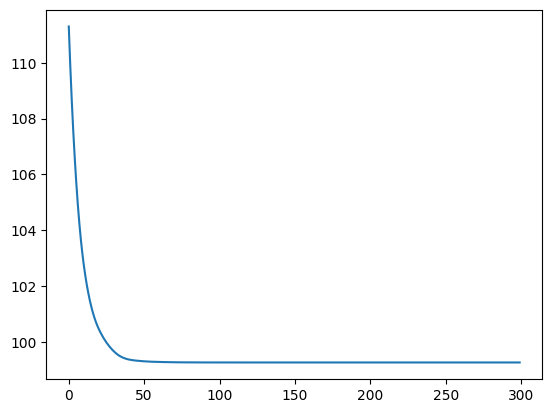

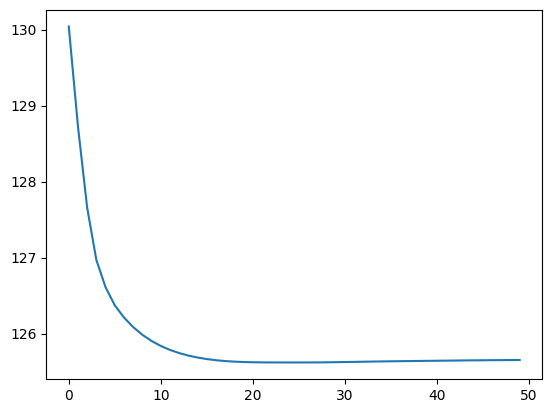

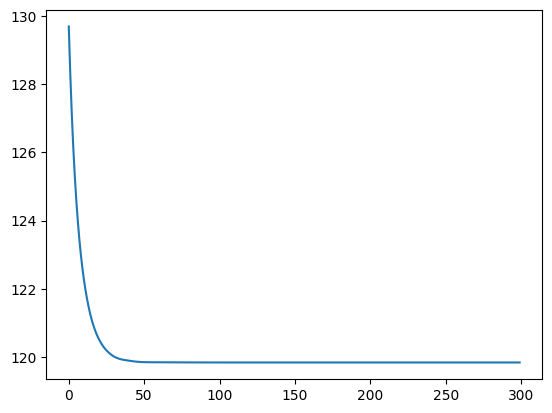

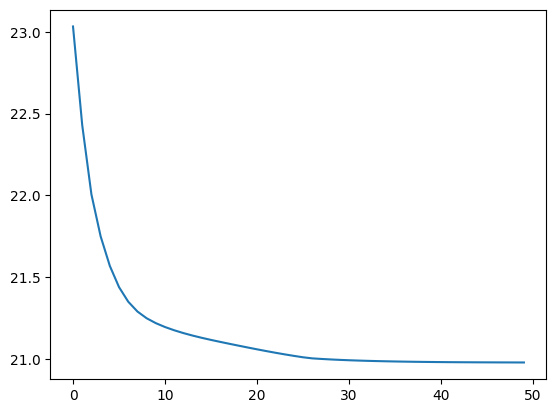

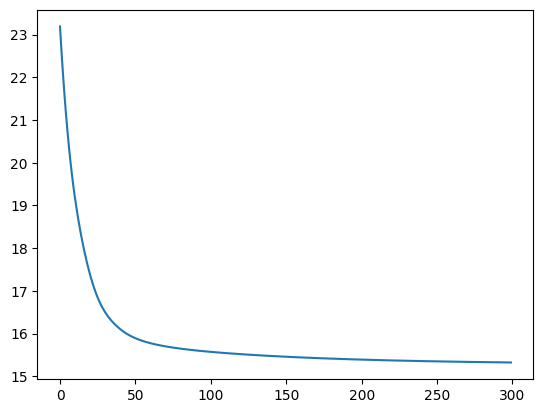

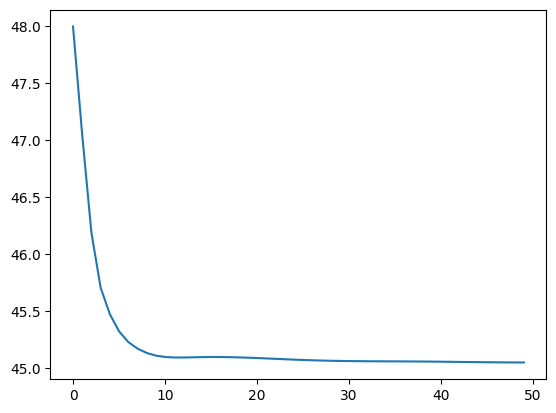

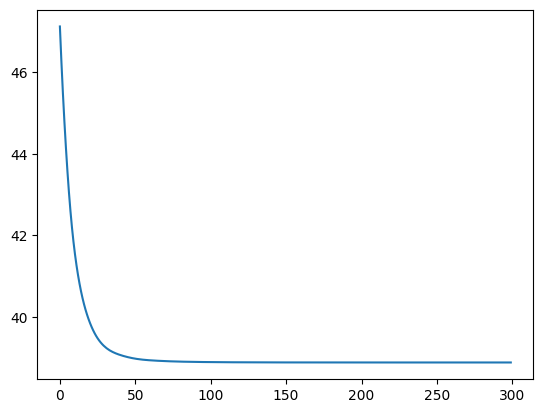

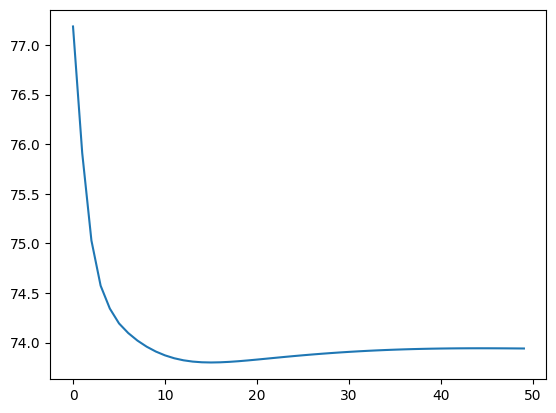

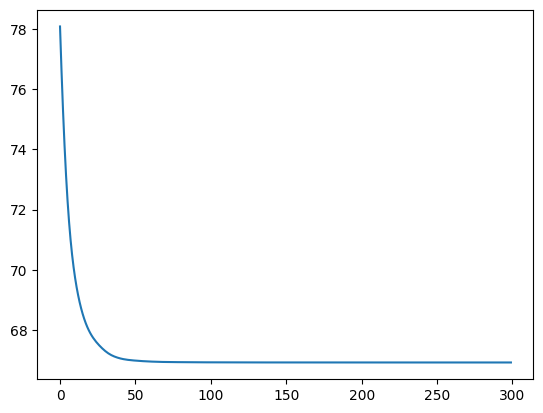

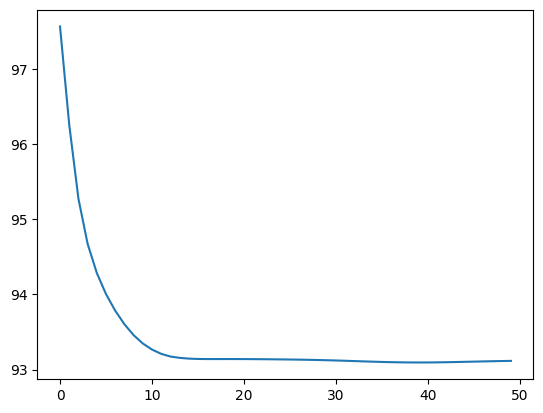

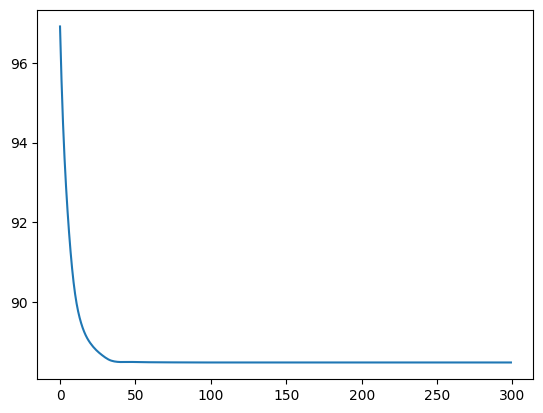

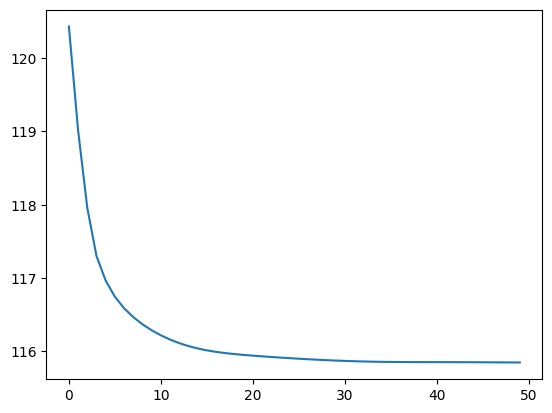

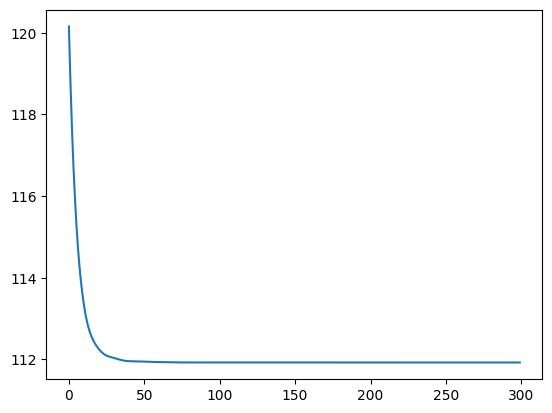

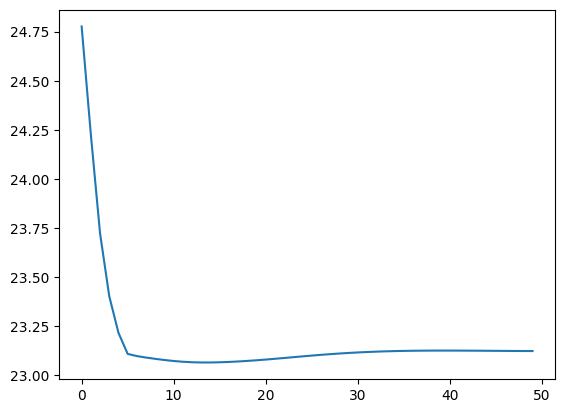

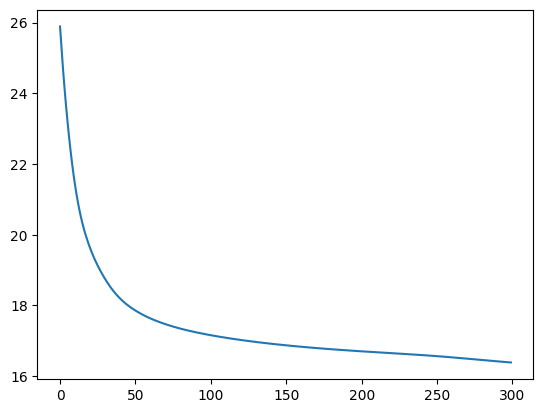

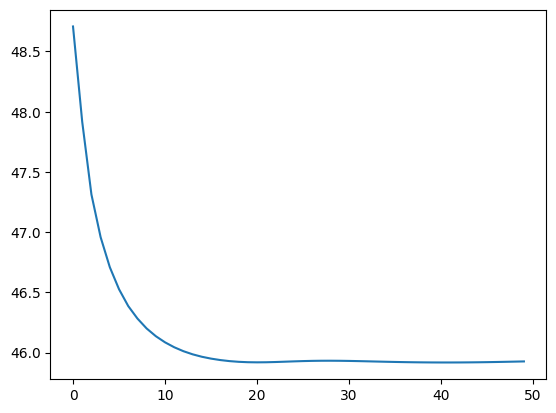

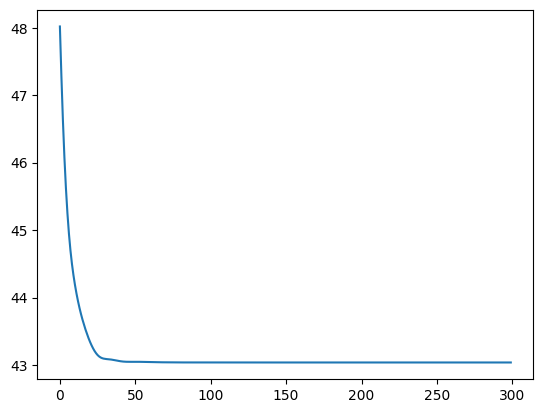

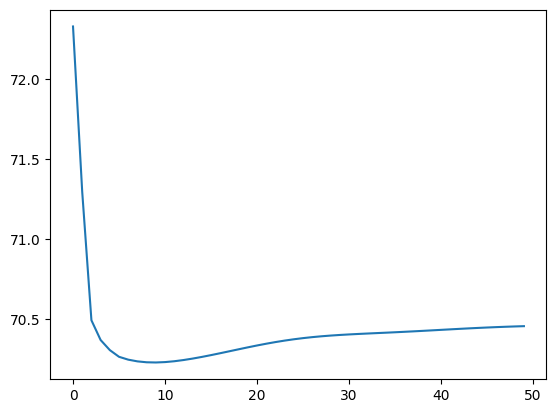

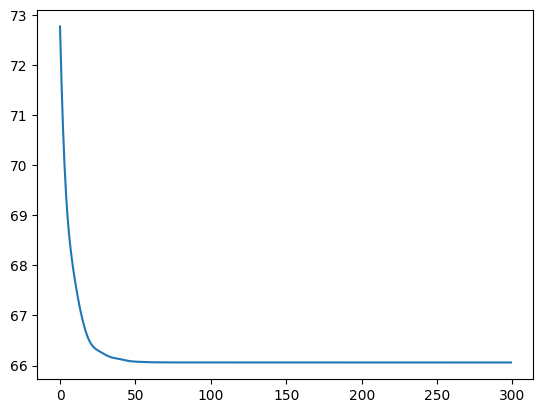

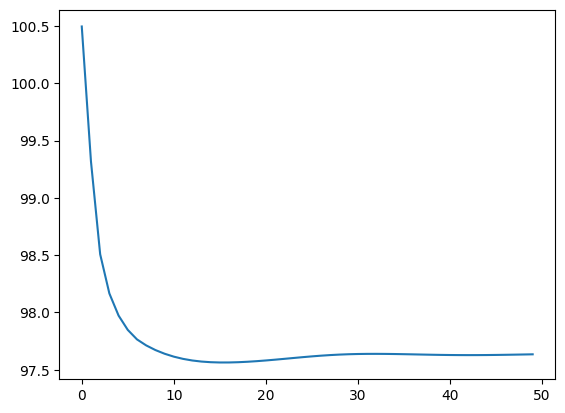

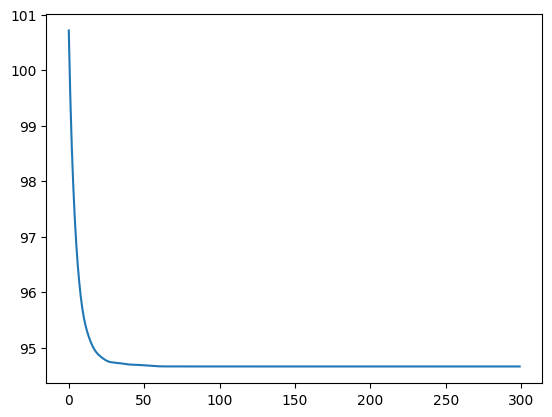

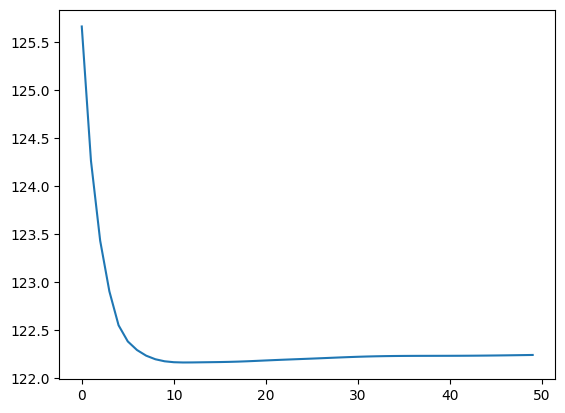

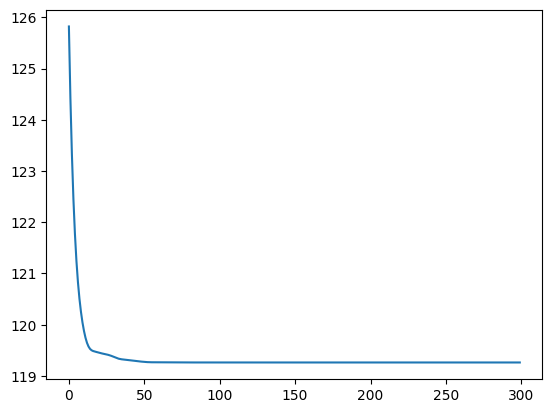

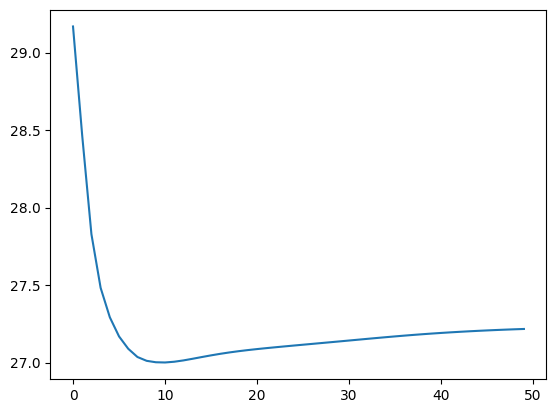

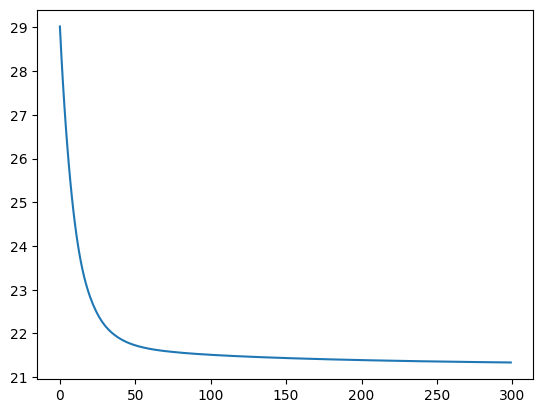

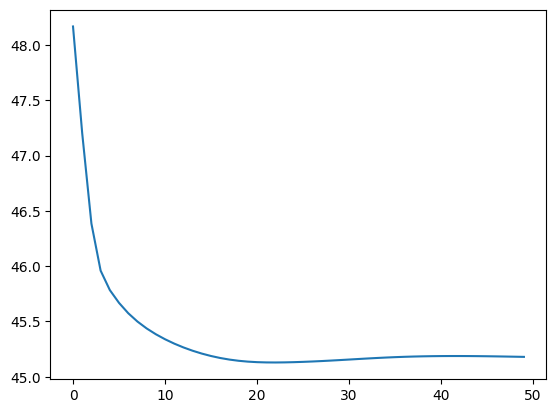

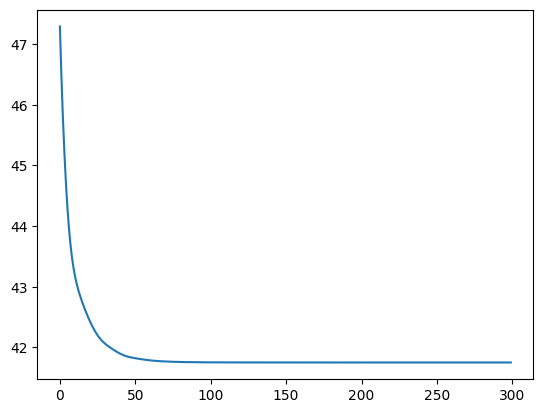

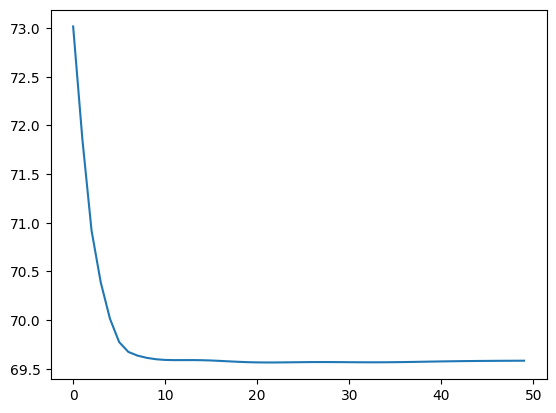

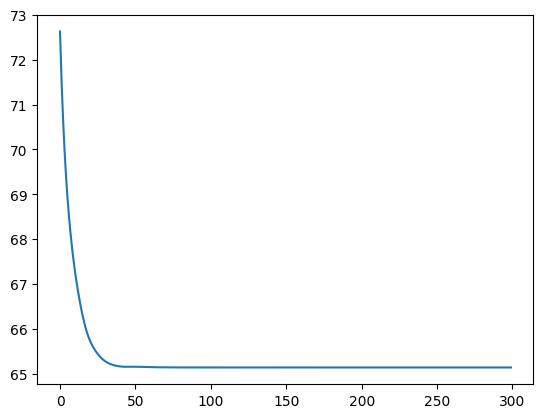

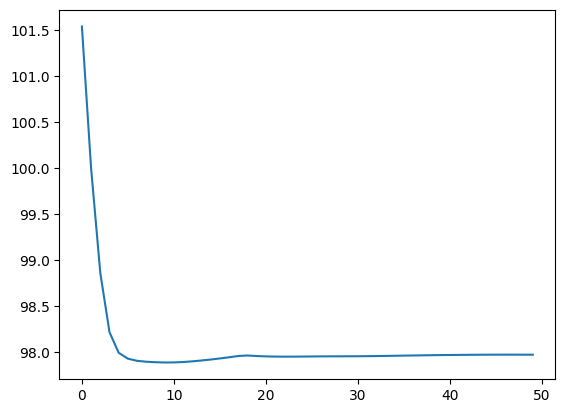

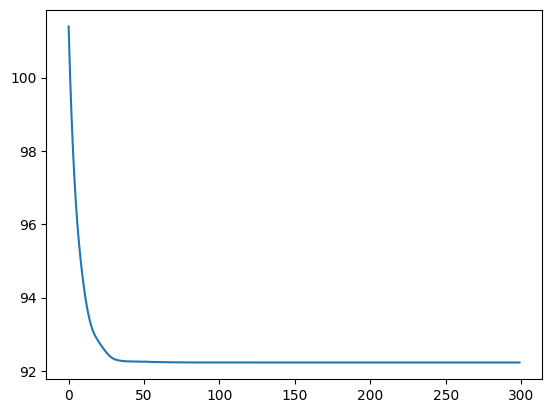

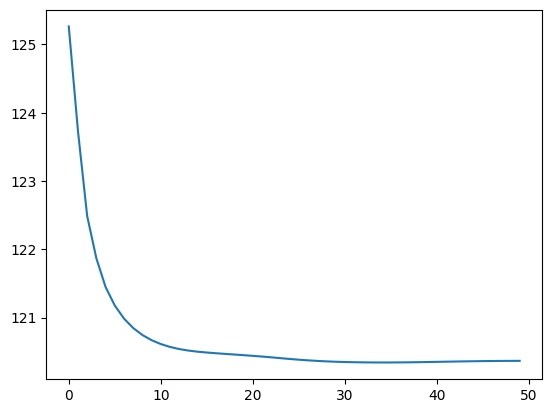

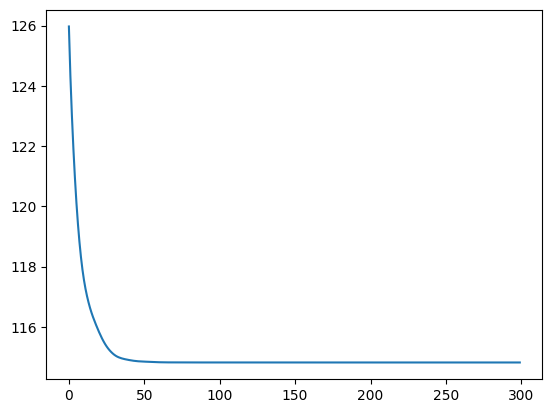

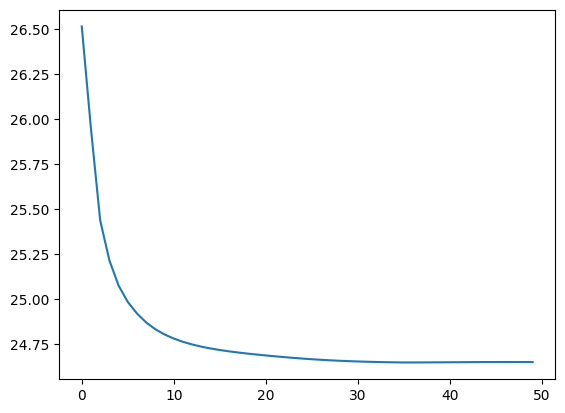

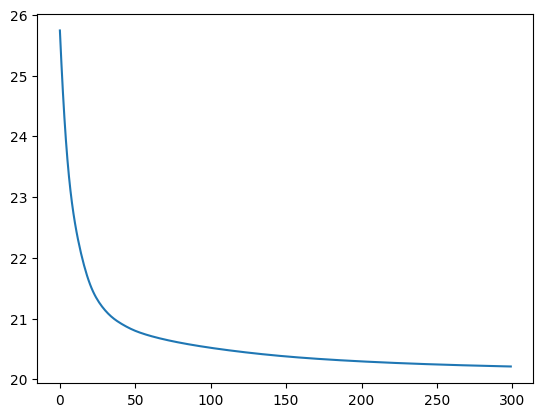

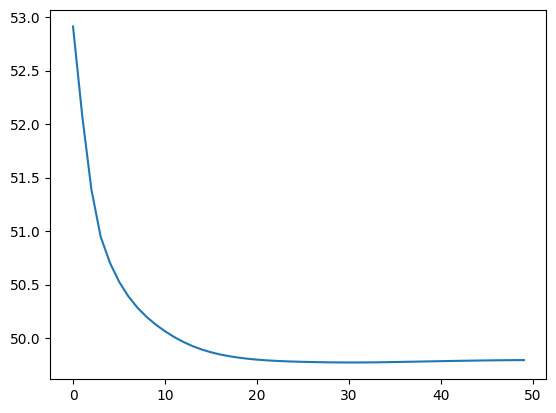

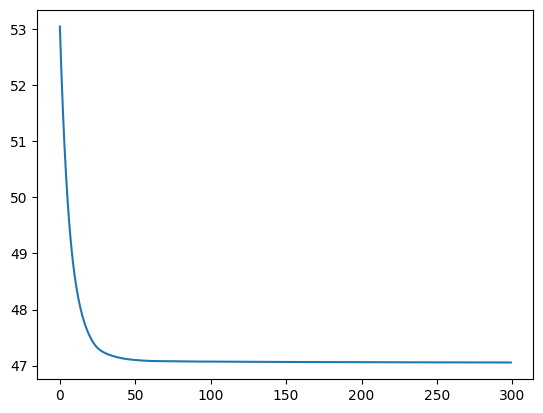

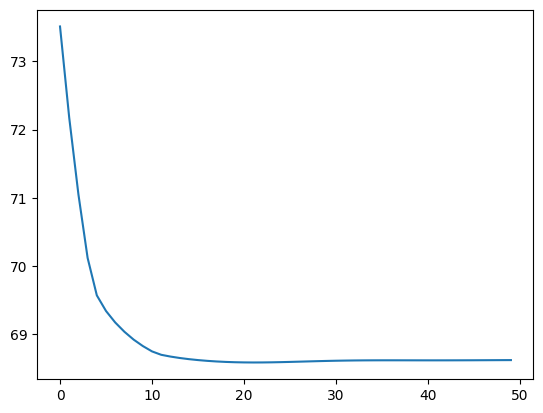

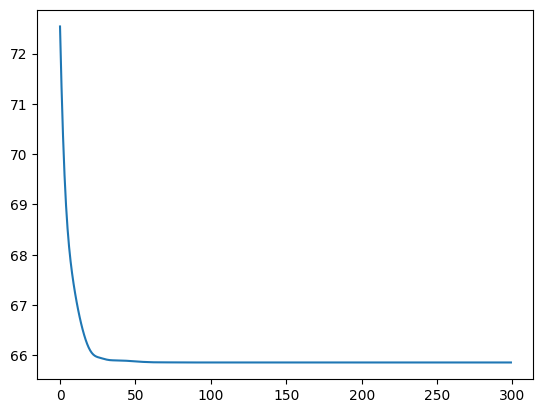

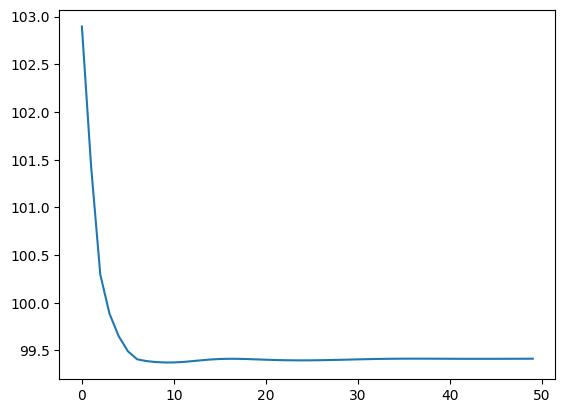

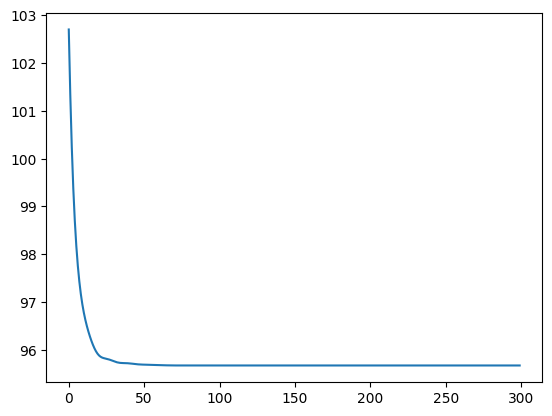

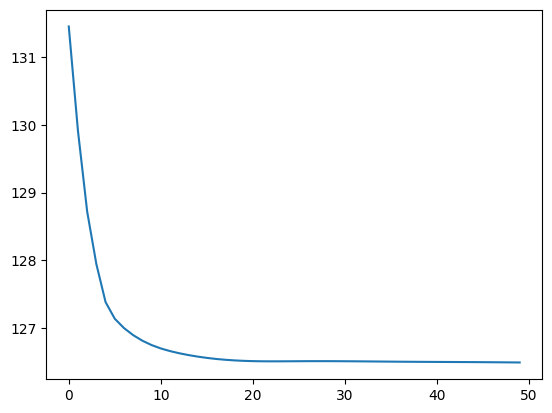

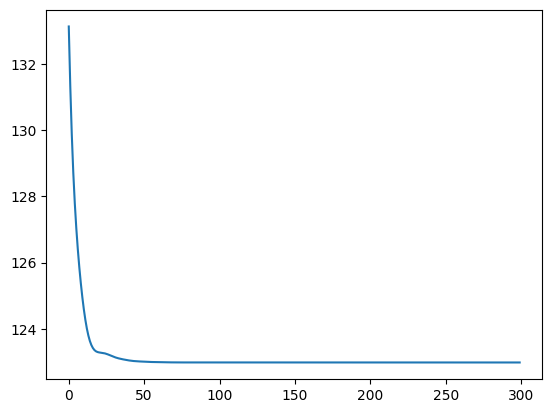

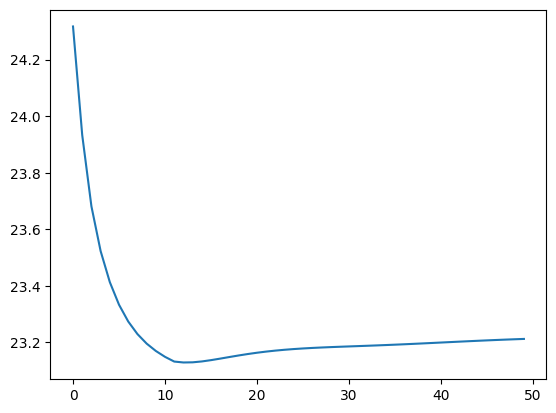

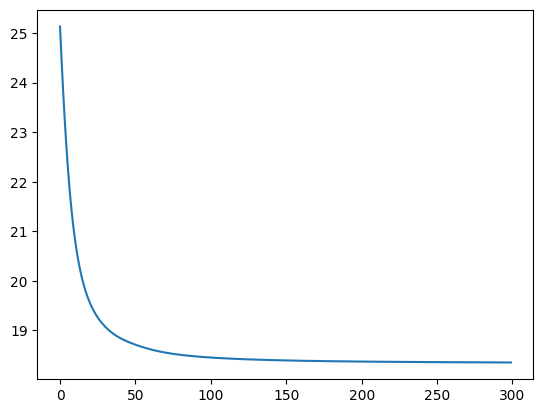

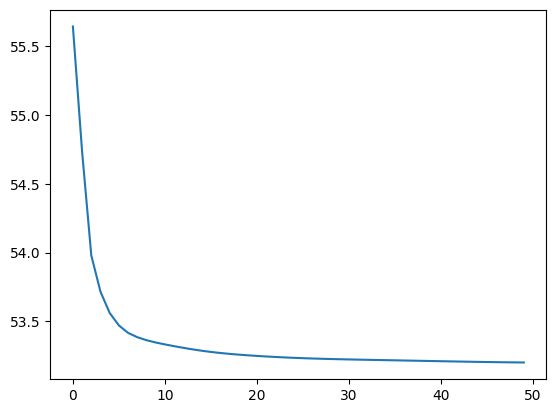

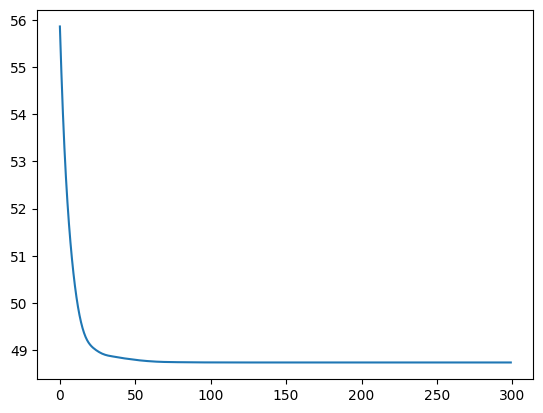

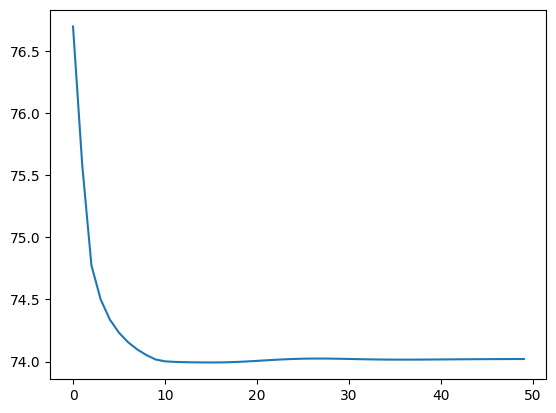

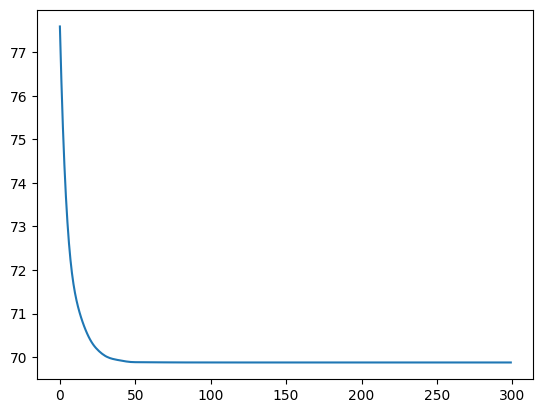

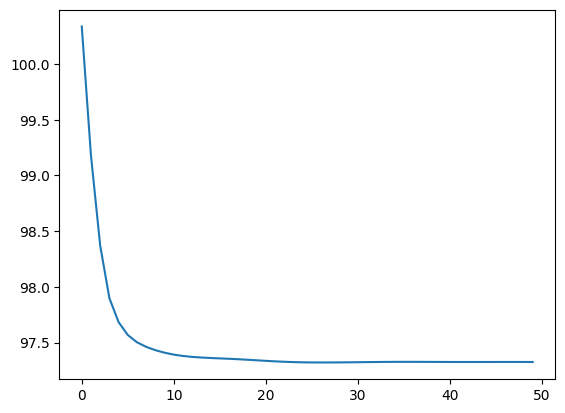

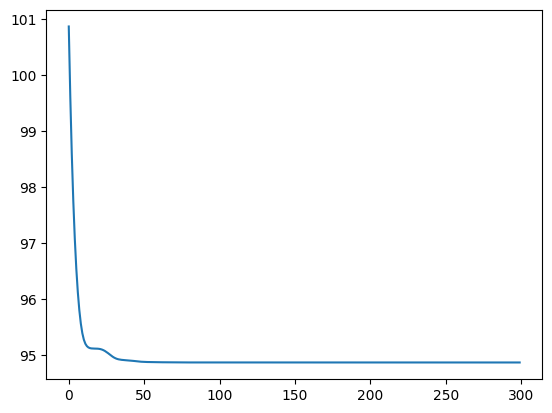

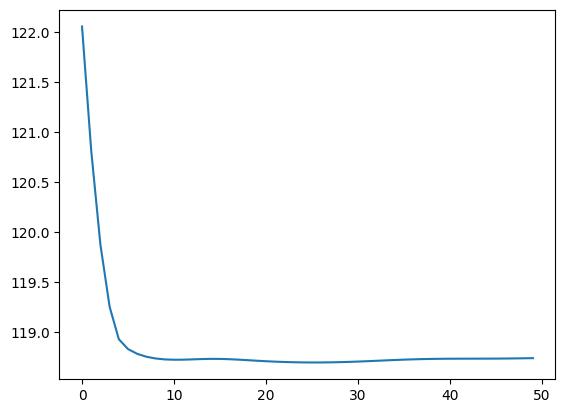

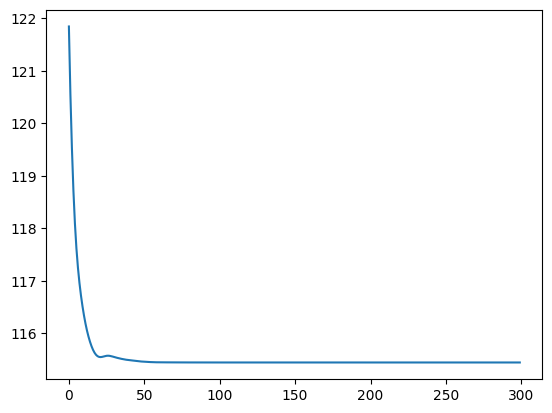

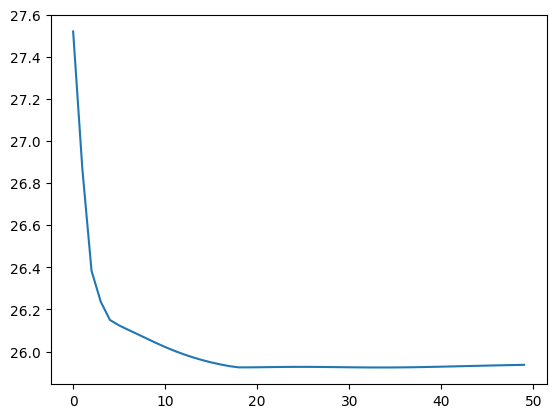

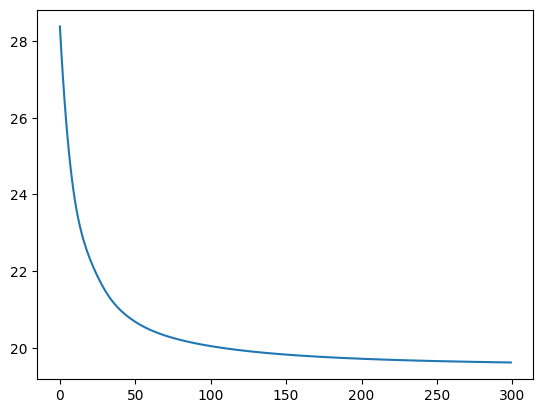

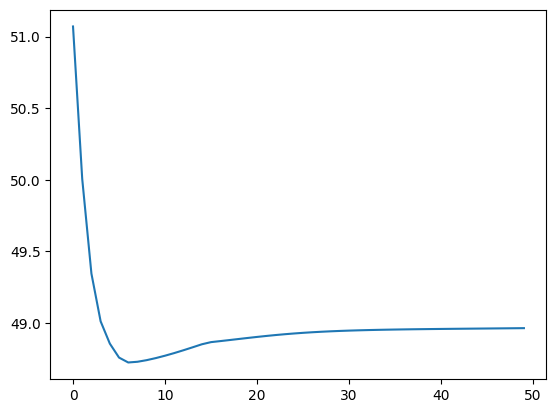

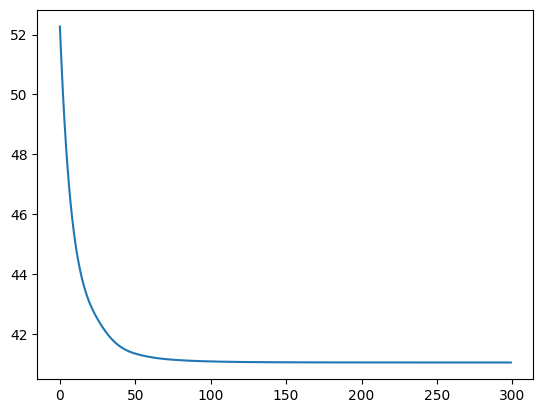

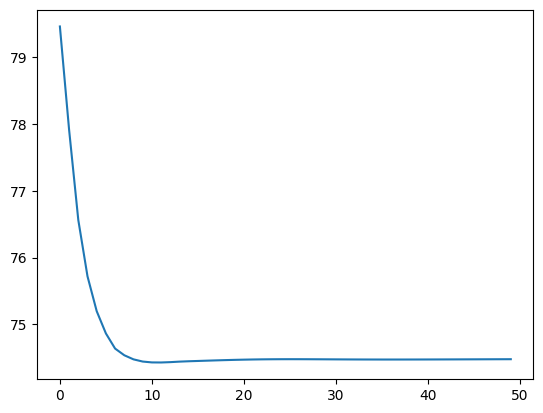

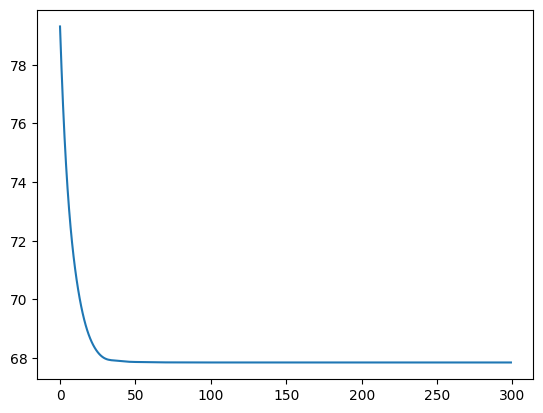

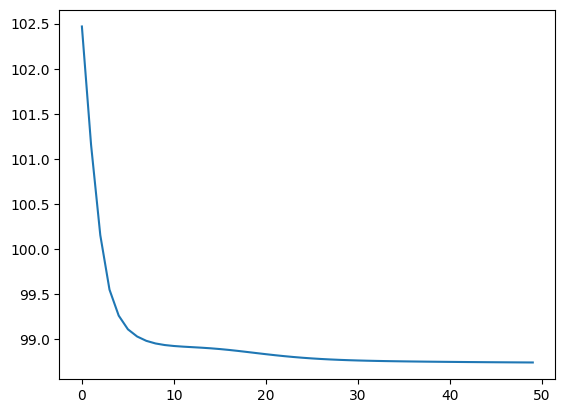

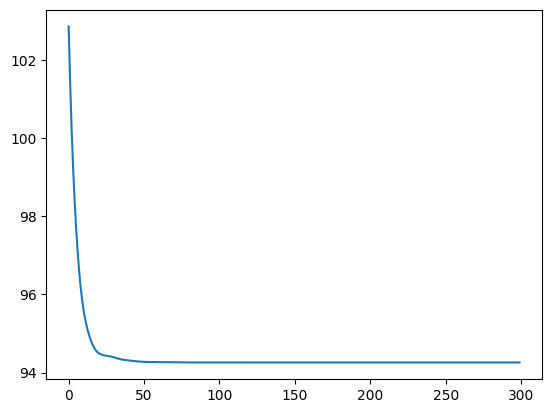

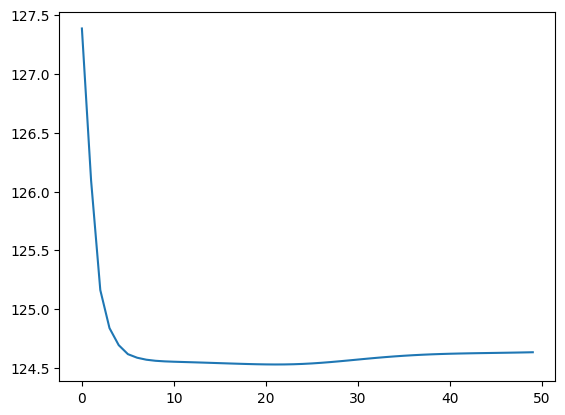

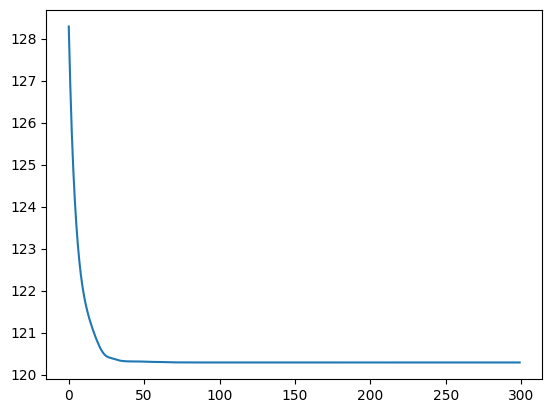

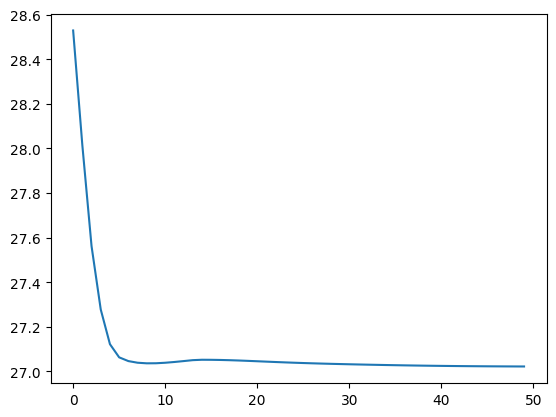

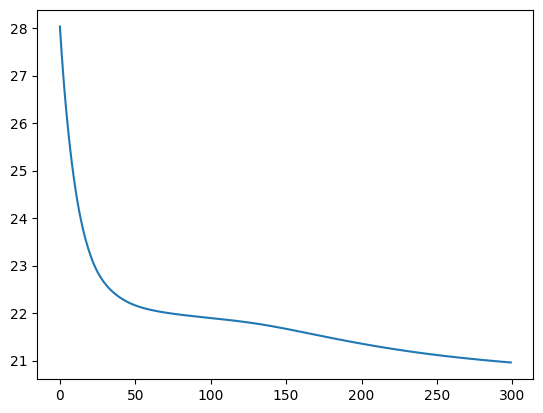

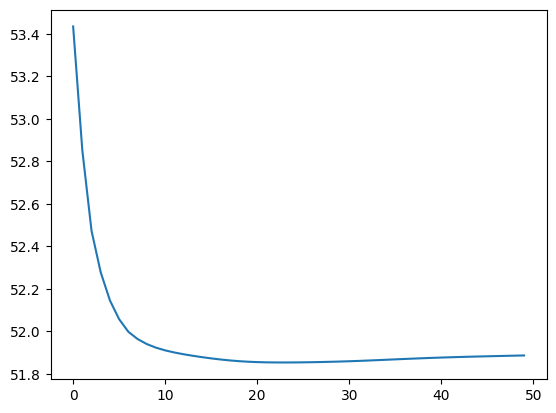

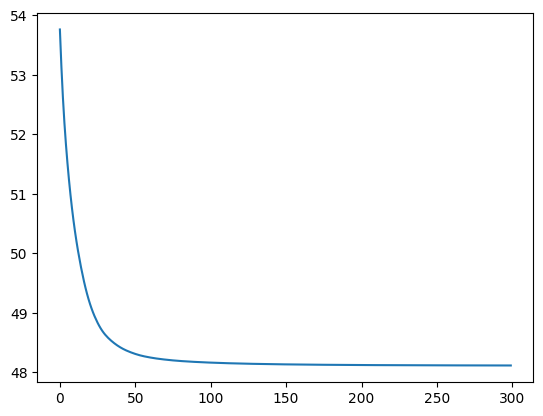

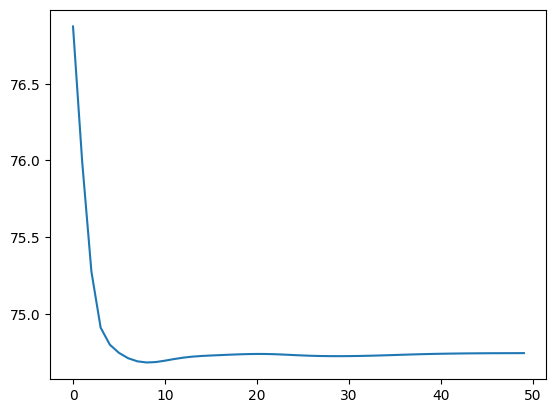

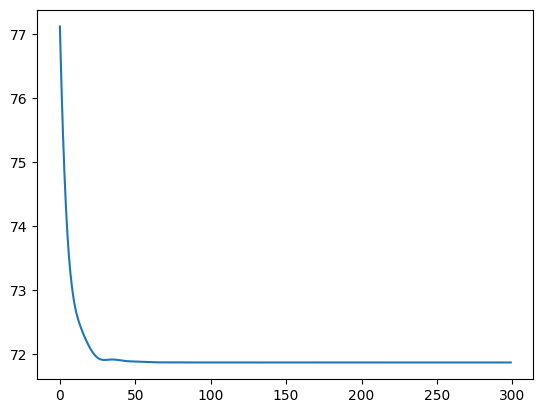

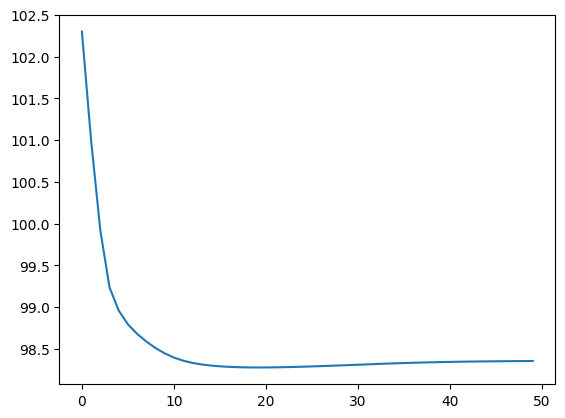

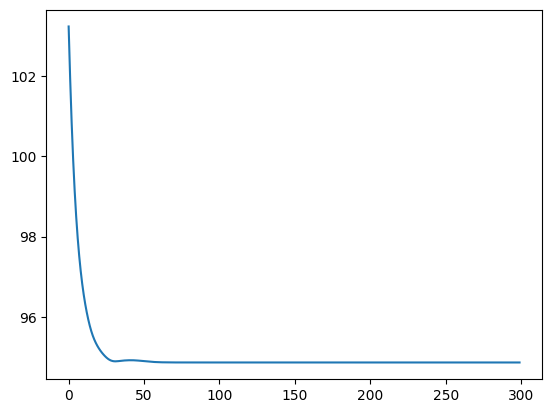

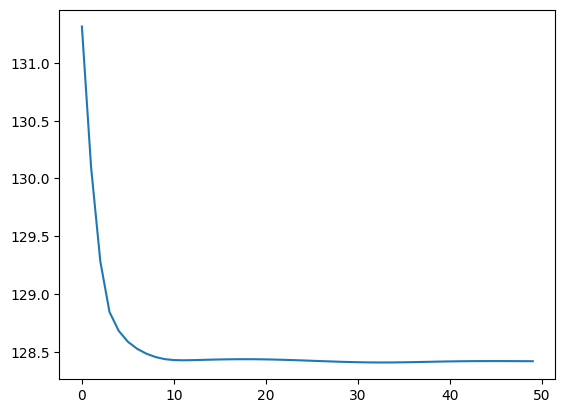

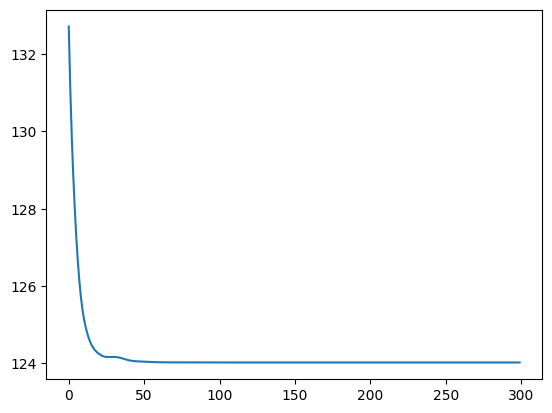

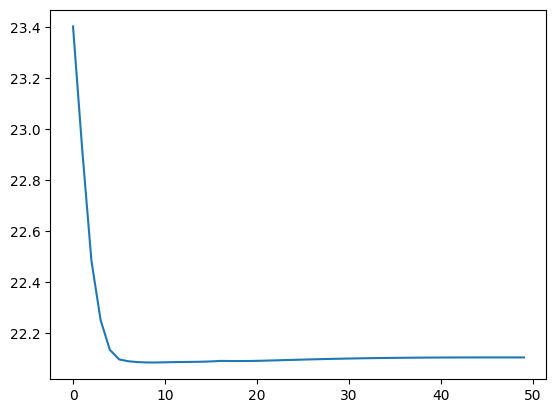

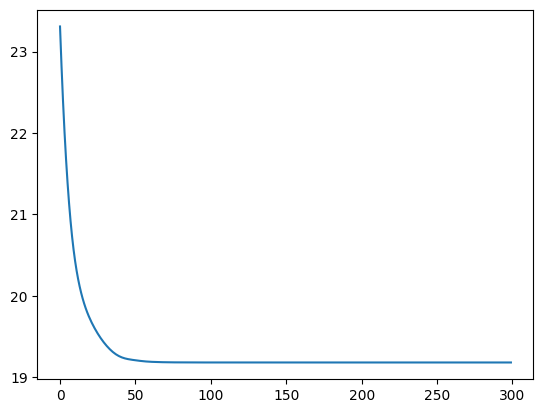

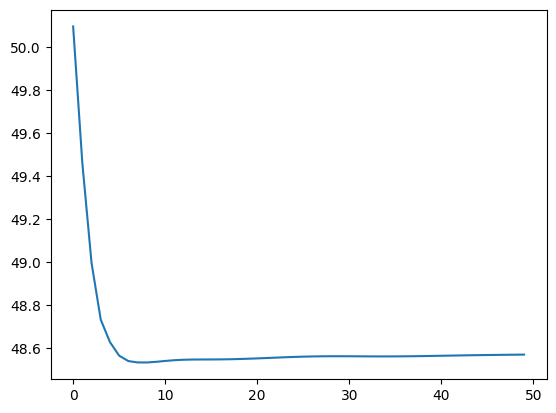

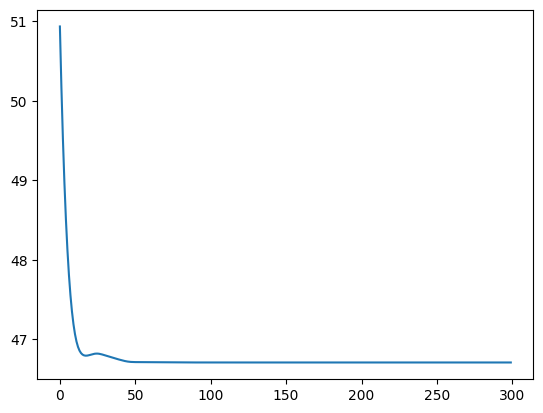

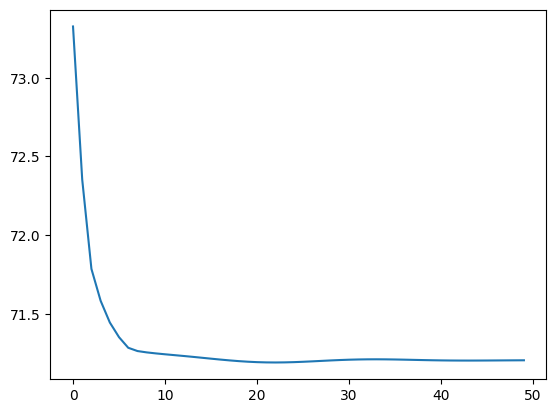

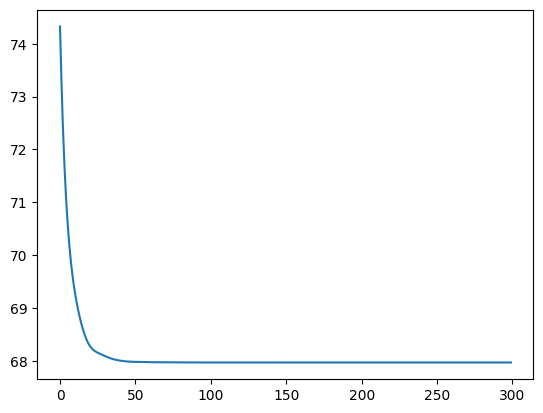

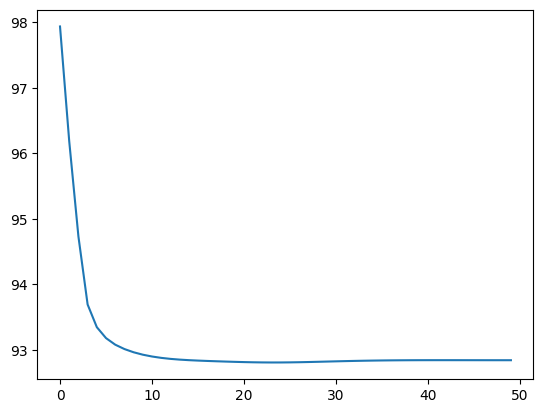

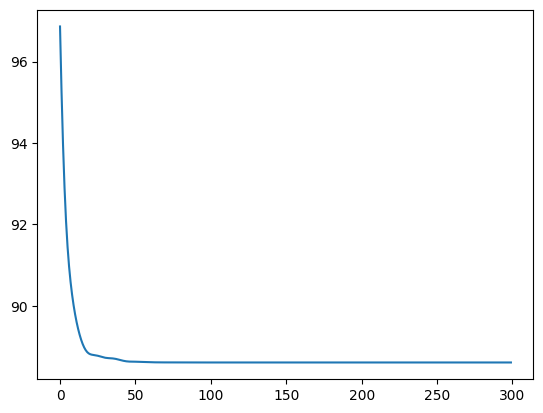

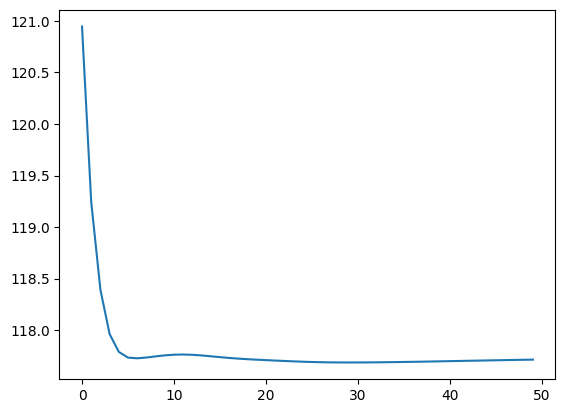

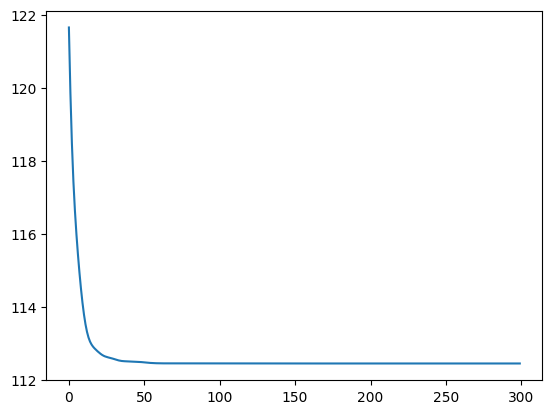

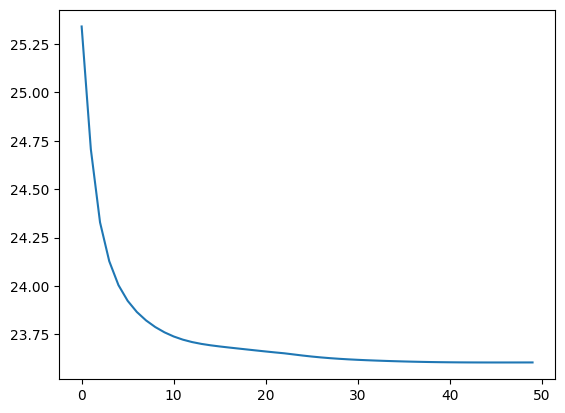

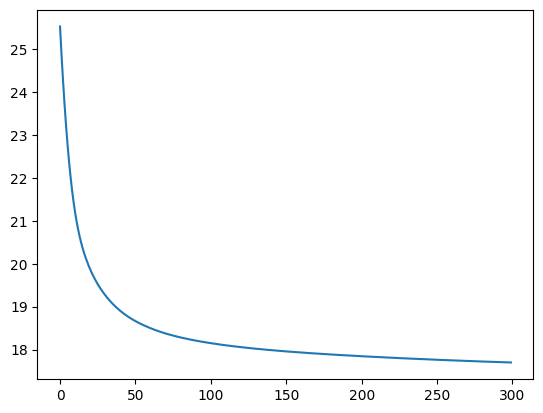

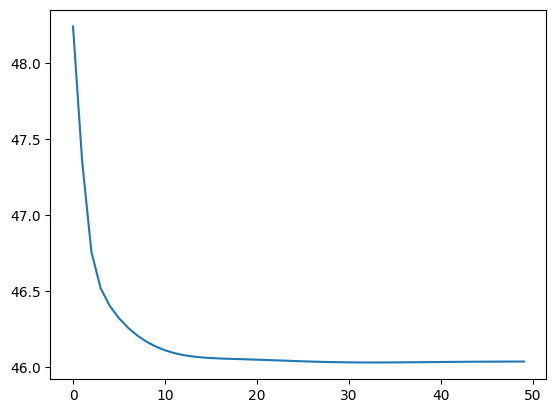

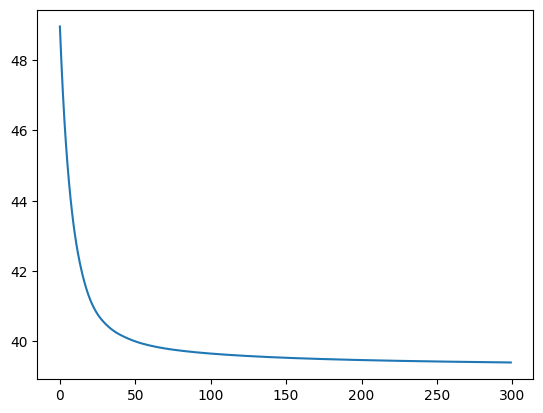

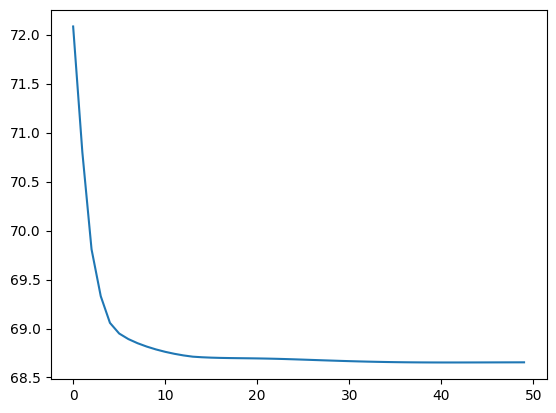

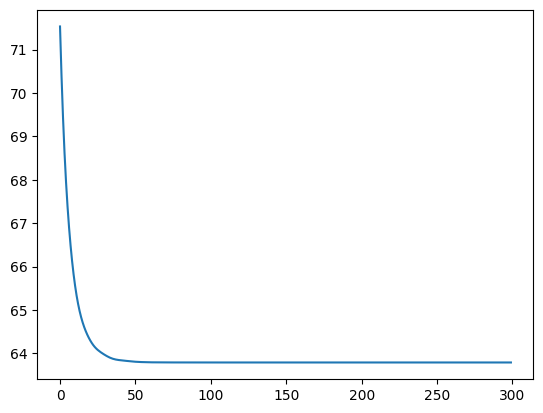

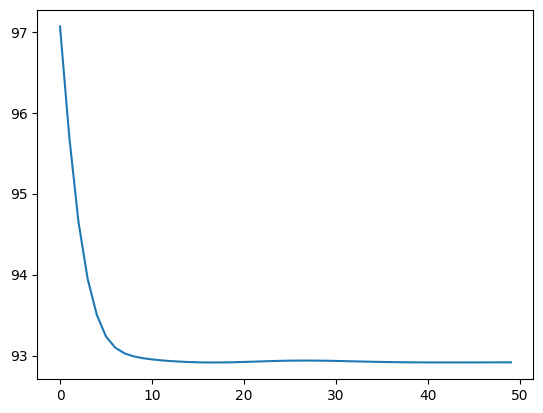

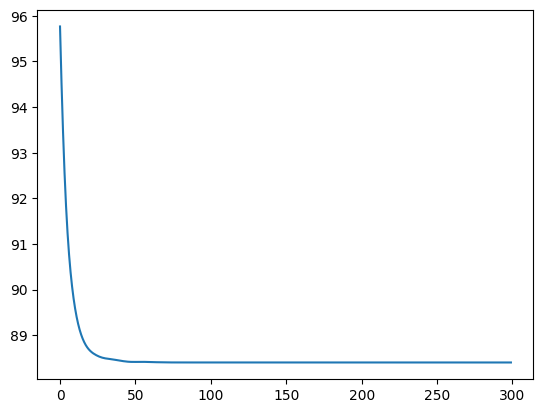

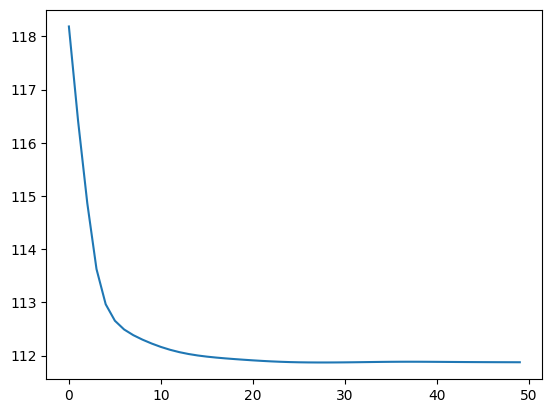

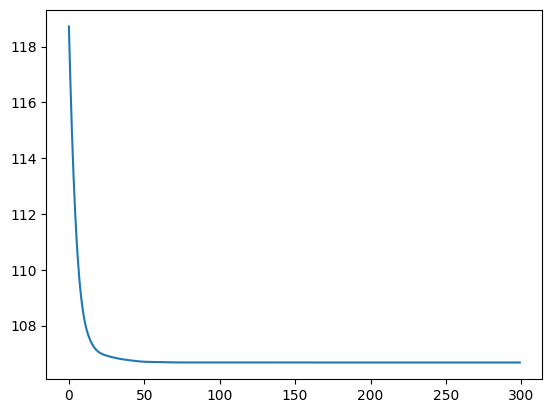

In [158]:
X = torch.zeros(5,T)
Y = torch.zeros(5,T)
e_nosig_nuc = np.zeros(5)
e_nosig_ls = np.zeros(5)

for i in range(10):
    e_idx = 0
    idx1 = 0
    idx2 = 0
    for t in range(T):
        x = X_design_nosig[:,t]
        y = torch.sigmoid(W_true @ x) + 0.5*torch.randn(5)
        #y = W_true @ x + 0.5*torch.randn(5)
        X[:,t] = x
        Y[:,t] = y
        if np.mod(t,20) == 0 and t > 0:
            W_hat = fit_glm_nuc(X[:,:t],Y[:,:t],1.1,50)
            #e_design.append(torch.linalg.norm(W_hat - W_true).detach().cpu().numpy())
            e_nosig_nuc[e_idx] += torch.linalg.norm(W_hat - W_true).detach().cpu().numpy() / 10
            W_hat = fit_glm(X[:,:t],Y[:,:t],300)
            e_nosig_ls[e_idx] += torch.linalg.norm(W_hat - W_true).detach().cpu().numpy() / 10
            e_idx += 1

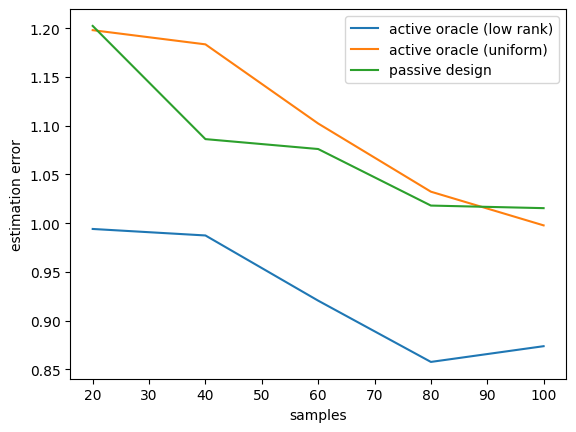

In [160]:
#plt.plot(e_passive,label='passive')
t = [20,40,60,80,100]
plt.plot(t,e_lr_nuc,label='active oracle (low rank)')
#plt.plot(e_lr_ls,label='low rank, ls')
plt.plot(t,e_full_nuc,label='active oracle (uniform)')
plt.plot(t,e_nosig_nuc,label='passive design')
#plt.plot(e_full_ls,label='full, ls')
plt.xlabel('samples')
plt.ylabel('estimation error')
plt.legend()
plt.show()

# Testing relative weight of diag vs not diag (unrelated to above) 

In [78]:
def compute_transfer_matrix2(Ahat,rollout_len,k=5):
    d = Ahat.shape[0]
    avg_connect_ark = np.zeros((d,d))
    #rollout_len = 15
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t] 
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

def compute_transfer_gt(Ast_new, k):
    transfer_gt = compute_transfer_matrix2(Ast_new, rollout_len=15, k=k)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=14, k=k)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=13, k=k)
    return transfer_gt


def load_lowrank_Ahat(rank):
    params = np.load('./estimated_parameters/Ahat_D_U_V_low_rank_' + str(rank) + '.npz.npy', allow_pickle=True)[()]
    num_neurons = 663
    d = 663
    k = 4
    Ast_new = np.zeros((num_neurons,2*k*num_neurons+1))
    for i in range(2*k):
        if i < k:
            Ast_new[:,i*num_neurons:(i+1)*num_neurons] = np.diag(params['alpha'][i]) + params['W_u'][i] @ params['W_v'][i].T
        else:
            Ast_new[:,i*num_neurons:(i+1)*num_neurons] = np.diag(params['beta'][i-k]) + params['B_u'][i-k] @ params['B_v'][i-k].T
    transfer_gt = compute_transfer_gt(Ast_new, k=k)
    return transfer_gt

def load_full_Ahat():
    Ast = np.load('./estimated_parameters/AR5_estimate.npy')
    num_neurons = 663
    d = 663
    k = 5
    Ast_new = np.zeros((num_neurons,2*k*num_neurons+1))
    for i in range(2*k):
        Ast_new[:,i*num_neurons:(i+1)*num_neurons] = Ast[0:num_neurons,i*d:i*d+num_neurons]
    Ast_new[:,-1] = Ast[0:num_neurons,-1]
    transfer_gt = compute_transfer_gt(Ast_new, k=k)
    return transfer_gt

#Ahat = load_lowrank_Ahat(35)
Ahat = load_full_Ahat()

1.5745395349872942 0.24355810169895856 1.581202434419959


Text(0.5, 1.0, 'off diag')

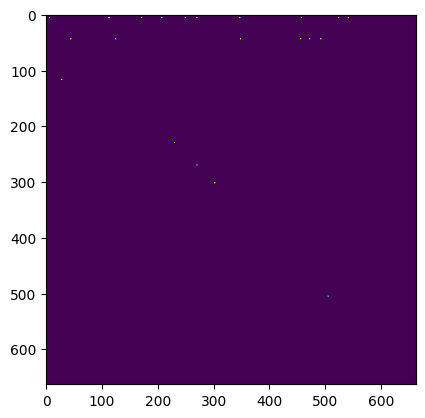

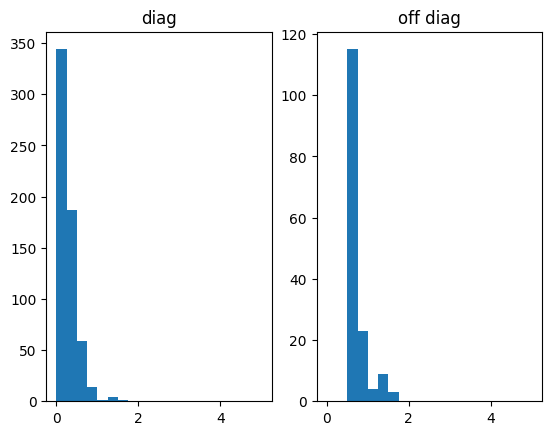

In [79]:
plt.imshow(Ahat>1, norm=colors.Normalize(vmin=0.0, vmax=.2))
Ahat_diag = np.diag(Ahat)
Ahat_offdiag = Ahat - np.diag(np.diag(Ahat))
print(np.max(Ahat_diag),np.mean(Ahat_diag),np.max(Ahat_offdiag))

plt.figure()
plt.subplot(1,2,1)
plt.hist(Ahat_diag,bins=20,range=(0,5))
plt.title('diag')
plt.subplot(1,2,2)
plt.hist(Ahat_offdiag[Ahat_offdiag>0.5].flatten(),bins=20,range=(0,5))
plt.title('off diag')